# Drivers credtit scores

I will explain this notebook in English and then in Spanish, usually separating languagues with |

Voy a explicar esta notebook en Ingles y español, generalmente separando con un |

This project was developed and asked for a company that gives loans to drivers of Apps that can not have access to the financial system. The goal was to develop a Scoring system, that will give drivers a Score that will tell us how likely they'll are to fall in default if they take a loan with the company.

Drivers connect there apps to the company giving information of the drivers history of earnings, the trips, distances and more information they have made on their driving apps. Also, there's information of the history they have with the company.


|||||||||||||||||||||||||||||||


Este proyecto fue desarrollado y solicitado por una empresa que otorga préstamos a conductores de aplicaciones que no pueden acceder al sistema financiero. El objetivo era desarrollar un sistema de puntuación que brindara a los conductores una puntuación que nos indicaría qué tan probable es que caigan en incumplimiento si toman un préstamo con la empresa.

Los conductores conectan sus aplicaciones a la empresa proporcionando información sobre el historial de ganancias de los conductores, los viajes, las distancias y más información que hayan realizado en sus aplicaciones de conducción. Además, hay información sobre el historial que tienen con la empresa.

## Import libraries | Importo librerias

In [327]:
# Import some libraries and connect to the database from GCP | Importo librerias y conecto a la base de datos de GCP

from google.cloud import bigquery
from google.colab import auth
import requests
import gspread
from google.auth import default
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import warnings
warnings.filterwarnings("ignore")

auth.authenticate_user()

project_id = 'onyx-rainfall-363418'

client = bigquery.Client(project=project_id)
dataset_name = 'Driving_score'

In [328]:
def NullPercentage(df):
    """
    Returns a summary of the number of records per column in a DataFrame, and
    the percentage of null values in each one. It also returns
    the data type of each column.

    Arguments:
    df (pandas dataframe): DataFrame to analyze

    """
    types = df.dtypes

    df_nulls = pd.DataFrame(types, columns=['Data_Types'])
    df_nulls['%_Null'] = round(df.isnull().sum() / len(df) * 100, 2)
    df_nulls['Qty_Null'] = round(df.isnull().sum(), 2)
    df_nulls['Qty_No_Null'] = round(df.count(), 2)
    df_nulls['Total_Records'] = len(df)

    return df_nulls


## Fetching the data from BigQuery | Traemos los datos de bigquery

Bringing information from the tables pre-consulted on Google Big Query, just bringing on information appropiate for performing this drivers scoring

||||

Traemos la informacion de las tablas de la base de datos de GCP, previamente los datos fueron consultados en Google Big Query para poder traer la información apropiada para desarrollar el Score de los conductores

In [329]:
company_driver = 'CompanyDriver'

sql_query_creditos = f'''
SELECT IDDriver as driverId,
       IDCompany as Platform,
       Status as DriverStatus,
       Rating
FROM `{project_id}.{dataset_name}..{company_driver}`
'''

dfCompanyDriver = client.query(sql_query_creditos).to_dataframe()

In [330]:
#Creditos means credits in Spanish

creditos = 'Creditos'

sql_query_creditos = f'''
SELECT ID as creditId,
       IDCliente as driverId,
       IDProducto,
       IDMoneda,
       Fecha,
       Importe,
       Cuotas,
       Vencimiento,
       Estado as estadoCredtito,
       Cobrado,
       Pendiente
FROM `{project_id}.{dataset_name}..{creditos}`
'''

dfCreditos = client.query(sql_query_creditos).to_dataframe()

In [331]:
# Cuotas means installments in Spanish

cuotas = 'Cuotas'

sql_query_creditos = f'''
SELECT ID as cuotaId,
       IDcredito as creditId,
       Cuota,
       Importe,
       Vencimiento,
       Cobrado,
       Pendiente,
       estado as estadoCuota,
       TimeStamp,
       PaymentDate,
       PunitoriosImpuestos,
       IDRefinanciadoEn,
       IDRefinanciacion,
       EsAdelanto
       FROM `{project_id}.{dataset_name}..{cuotas}`
'''

dfCuotas = client.query(sql_query_creditos).to_dataframe()

# Meaning of the following words in Spanish:


#       Cuota: Installment | Importe: Amount | Vencimiento: Due date | Cobrado: Paid |Pendiente: Pending |estadoCuota: installmentStatus |TimeStamp: Timestamp
#       PunitoriosImpuestos: Late fees/taxes | IDRefinanciadoEn: Refinanced in ID |IDRefinanciacion: Refinancing ID |EsAdelanto: IsAdvance |

In [332]:
dolar_blue = 'dolarblue'

sql_query_creditos = f'''
SELECT day as dia,
       type as tipo_de_cambio,
       value_buy as valor_compra,
       value_sell as valor_venta,
       FROM `{project_id}.{dataset_name}..{dolar_blue}`
'''

dfDolar_blue = client.query(sql_query_creditos).to_dataframe()

In [333]:
driverArrear = 'DriverArrearDetail'

sql_query_creditos = f'''
SELECT driverId,
       date as FechaArrear,
       installmentId as cuotaId,
       arrearStatusId,
       daysOfArrear
FROM `{project_id}.{dataset_name}..{driverArrear}`
'''

dfDriverArrear = client.query(sql_query_creditos).to_dataframe()

In [334]:
earnings = 'earnings'

sql_query_creditos = f'''
SELECT IDDriver as driverId,
       IDCompany as Platform,
       Ano,
       Mes,
       Dia,
       earnings
FROM `{project_id}.{dataset_name}..{earnings}`
'''

dfEarnings = client.query(sql_query_creditos).to_dataframe()

In [335]:
trips = 'trips'
sql_query_creditos = f'''
SELECT ID as idTrip,
       IDDriver as driverId,
       IDCompany as platform_id,
       IDType,
       StartDate,
       Amount,
       Commissions,
       Duration,
       Distance,
       Status,
       OtherInfo
FROM `{project_id}.{dataset_name}..{trips}`
'''

dfTrips = client.query(sql_query_creditos).to_dataframe()

In [336]:
weekly = 'weekly_earnings'

sql_query_creditos = f'''
SELECT customer_id as driverId,
       year,
       week,
       platform_id,
       amount,
       cash_amount,
       card_amount,
       card_percentage,
       cash_percentage,
       total_trips
FROM `{project_id}.{dataset_name}..{weekly}`
'''

dfWeekly_Earnings = client.query(sql_query_creditos).to_dataframe()

In [337]:
dfWeekly_Earnings['year'].unique().tolist()

[2023, 2024]

In [338]:
# Unification of tables bureau_score_results and bureau_scores | Unifico las tablas bureau_score_results and bureau_scores

sql_query_creditos = f'''

SELECT bsr.score_id,
       bs.customer_id as driverId,
       bsr.score as scoreBureau,
       bsr.status as statusBureau,
       bsr.risk_level as riskBureau,
       bsr.created_at as date
FROM `onyx-rainfall-363418.Driving_score.bureau_score_results` bsr
LEFT JOIN `onyx-rainfall-363418.Driving_score.bureau_scores` bs ON bsr.score_id = bs.id;

'''

dfBureau_Scores = client.query(sql_query_creditos).to_dataframe()

In [339]:
dfCuotas.head(1)

cuotaId  creditId  Cuota  Importe               Vencimiento  Cobrado  \
0        1         1      1  3000.59 2022-01-18 14:12:31+00:00  3000.59   

   Pendiente  estadoCuota                        TimeStamp  \
0        0.0            3 2022-01-13 14:12:31.500000+00:00   

                PaymentDate  PunitoriosImpuestos  IDRefinanciadoEn  \
0 2022-01-18 14:12:31+00:00                  0.0              <NA>   

   IDRefinanciacion  EsAdelanto  
0              <NA>        <NA>

In [340]:
# Convert datetime columns to timezone-unaware datetime objects | Convertir a tipo de dato Fecha en las columnas que correspondan

dfCreditos['Fecha'] = dfCreditos['Fecha'].dt.tz_localize(None)
dfCreditos['Vencimiento'] = dfCreditos['Vencimiento'].dt.tz_localize(None)
dfCuotas['Vencimiento'] = dfCuotas['Vencimiento'].dt.tz_localize(None)
dfCuotas['TimeStamp'] = dfCuotas['TimeStamp'].dt.tz_localize(None)
dfCuotas['PaymentDate'] = dfCuotas['PaymentDate'].dt.tz_localize(None)
#dfDriverArrear['FechaArrear'] = dfDriverArrear['FechaArrear'].dt.tz_localize(None)
dfTrips['StartDate'] = dfTrips['StartDate'].dt.tz_localize(None)
dfBureau_Scores['date'] = dfBureau_Scores['date'].dt.tz_localize(None)

## Transformation to dolar blue | Transformación a Dolar Blue

In Argentina, where both the company and drivers operate, the persistently high inflation rates significantly impact the value of earnings, loans, and every financial measure. To ensure a fair comparison of prices and maintain financial stability, it becomes imperative to convert these values into a more stable currency, such as the USD Dollar.

The Argentine Peso is notorious for its susceptibility to inflation, which can render financial calculations unreliable and make long-term planning challenging. Therefore, opting for a stronger and more stable currency like the USD Dollar provides a reliable benchmark against which to gauge financial performance and make informed decisions.

Moreover, between 2019 and 2023, the official exchange rate often diverged from the actual market rate, known as the "Dolar Blue." This unofficial market rate became the de facto standard for pricing and accessing currency, highlighting the necessity of adopting a more accurate and reliable currency conversion method.

By utilizing API to fetch real-time exchange rate data, we can mitigate the effects of currency fluctuations and accurately translate monetary values into USD Dollars. This approach not only enhances transparency and consistency in financial reporting but also safeguards against the volatility inherent in the Argentine Peso.


||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

En Argentina, donde tanto la empresa como los conductores operan, las persistentemente altas tasas de inflación impactan significativamente el valor de las ganancias, los préstamos y todas las medidas financieras. Para asegurar una comparación justa de precios y mantener la estabilidad financiera, se vuelve imperativo convertir estos valores a una moneda más estable, como el Dólar estadounidense (USD).

El Peso argentino es conocido por su susceptibilidad a la inflación, lo que puede hacer que los cálculos financieros sean poco confiables y dificultar la planificación a largo plazo. Por lo tanto, optar por una moneda más fuerte y estable como el Dólar estadounidense proporciona un punto de referencia confiable para evaluar el rendimiento financiero y tomar decisiones informadas.

Además, entre 2019 y 2023, el tipo de cambio oficial a menudo divergió del tipo de cambio de mercado real, conocido como "Dólar Blue". Este tipo de cambio de mercado no oficial se convirtió en el estándar de facto para fijar precios y acceder a la moneda, lo que destaca la necesidad de adoptar un método de conversión de moneda más preciso y confiable.

Al utilizar una API para obtener datos de tipo de cambio en tiempo real, podemos mitigar los efectos de las fluctuaciones monetarias y traducir con precisión los valores monetarios a Dólares estadounidenses. Este enfoque no solo mejora la transparencia y consistencia en los informes financieros, sino que también protege contra la volatilidad inherente al Peso argentino.

In [341]:
# The dolar blue table brought from the Big Query wasn't completed. That's why we connect this API to fecth the daily Dolar Blue rate | La tabla de dolar Blue de GCP no tenia el total de los valores, es por eso que realizamos la conexion y traemos todos los valores que necesitamos desde la API.
dfDolar_blue.tail()

dia tipo_de_cambio  valor_compra  valor_venta
4800 2023-08-31 00:00:00+00:00           Blue         725.0        735.0
4801 2023-09-13 00:00:00+00:00           Blue         725.0        735.0
4802 2023-09-20 00:00:00+00:00           Blue         725.0        735.0
4803 2024-01-10 00:00:00+00:00           Blue        1100.0       1150.0
4804 2024-01-30 00:00:00+00:00           Blue        1165.0       1215.0

In [342]:
# Alpha Advantage API to fetch the exchange rate | Api de Alpha Advantage para traer los tipos de cambio

#!pip install pandasql
import numpy as np
import pandas as pd
import json


from datetime import datetime, timedelta
#from pandasql import sqldf
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from google.colab import auth
auth.authenticate_user()
print('Authenticated')
from google.cloud import bigquery
project_id = 'onyx-rainfall-363418'
client = bigquery.Client(project = project_id)



Authenticated


In [343]:
!pip3 install --upgrade 'sqlalchemy<2.0'
!pip install flask_sqlalchemy

  Using cached SQLAlchemy-1.4.52-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.29
    Uninstalling SQLAlchemy-2.0.29:
      Successfully uninstalled SQLAlchemy-2.0.29
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask-sqlalchemy 3.1.1 requires sqlalchemy>=2.0.16, but you have sqlalchemy 1.4.52 which is incompatible.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.52 which is incompatible.
  Using cached SQLAlchemy-2.0.29-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.52
    Uninstalling SQLAlchemy-1.4.52:
      Successfully uninstalled SQLAlchemy-1.4.52


In [344]:
import pandas as pd
import requests
import gspread
from google.auth import default
from oauth2client.client import GoogleCredentials


# Defining web URL to extract data from Alpha Vantage API with your API key | Ruta de donde se extrae la informacion de la API
url = 'https://www.alphavantage.co/query?function=FX_daily&from_symbol=USD&to_symbol=ARS&apikey=015F7ID53YKMWVU2&outputsize=full'

# Perform a GET request to the Alpha Vantage API and retrieve the data as a JSON object
response = requests.get(url)
data = response.json()

# Convert the data to a DataFrame using pandas
df_dolarblue_ok = pd.DataFrame.from_dict(data['Time Series FX (Daily)'], orient='index')
df_dolarblue_ok = df_dolarblue_ok.astype(float)

# Reorganize the DataFrame into the desired structure
df_dolarblue_ok = df_dolarblue_ok.reset_index()
df_dolarblue_ok.rename(columns= {'index': 'Fecha'}, inplace=True)

# Reduce the dataset according to the available data
start_date = '2022-01-01'
df_dolarblue_ok = df_dolarblue_ok[df_dolarblue_ok['Fecha'] >= start_date]

# Drop columns that are not useful and retain only the closing price of the day

df_dolarblue_ok = df_dolarblue_ok.drop(columns = ['1. open', '2. high', '3. low'])
df_dolarblue_ok.head(3)

# Transform to date type "Fecha" that is "date" in Spanish
df_dolarblue_ok['Fecha'] = pd.to_datetime(df_dolarblue_ok['Fecha'])

# Extract the date and format it
df_dolarblue_ok['Formatted_Date'] = df_dolarblue_ok['Fecha'].dt.strftime('%Y-%m-%d')
df_dolarblue_ok.head()



Fecha  4. close Formatted_Date
0 2024-04-17     869.0     2024-04-17
1 2024-04-16     868.5     2024-04-16
2 2024-04-15     868.0     2024-04-15
3 2024-04-12     866.5     2024-04-12
4 2024-04-11     865.5     2024-04-11

In [345]:
# Example that some weekday data is missing, that's why what's below is considered. Market do not operate in holidays and weekdays | Ejemplo de que faltan algunas fechas, el mercado no opera fines de semana ni feriados
df_dolarblue_ok[df_dolarblue_ok['4. close']=='2022-08-21']
df_dolarblue_ok[df_dolarblue_ok['4. close']=='2023-04-30']

Empty DataFrame
Columns: [Fecha, 4. close, Formatted_Date]
Index: []

In [346]:
# weekdays are missing, so we need to get the last measured value with method fillna during merge | Dias de semana faltan, ´por eso vamos a completar los valores faltantes con los anteriores registros

#np.sort(df_dolarblue_ok['Formatted_Date'].unique())

#### Credits to dollar | Creditos a Dolar

In [347]:
dfCreditos.head(1)

creditId  driverId  IDProducto  IDMoneda               Fecha  Importe  \
0        89        44           1         1 2022-04-18 16:54:37   2984.0   

   Cuotas         Vencimiento  estadoCredtito  Cobrado  Pendiente  
0       1 2022-05-18 16:54:37               6      0.0     2984.0

In [348]:
creditos_p_dolarizacion = dfCreditos.shape[0]
print("Previous quantity of lines before convertion to Dollar: ", creditos_p_dolarizacion) # | Cantidad de lineas previa a la conversion a Dolar:

#np.sort(dfCreditos['Formatted_Date'].unique())

Previous quantity of lines before convertion to Dollar:  2053


In [349]:
#  creating a column to enable the merge and fetch the exchange rate for the date in order to convert everything to USD.
dfCreditos
# Assuming 'Fecha' is a datetime column
dfCreditos['Fecha'] = pd.to_datetime(dfCreditos['Fecha'])

# Extract the date and format it
dfCreditos['Formatted_Date'] = dfCreditos['Fecha'].dt.strftime('%Y-%m-%d')
dfCreditos.head()

creditId  driverId  IDProducto  IDMoneda               Fecha  Importe  \
0        89        44           1         1 2022-04-18 16:54:37   2984.0   
1       274        96           1         1 2022-07-04 15:23:18   2500.0   
2       277        96           1         1 2022-07-04 16:45:19   2585.0   
3       278        96           1         1 2022-07-04 17:28:34   2638.0   
4       314       120           1         1 2022-07-14 08:34:33   4642.0   

   Cuotas         Vencimiento  estadoCredtito  Cobrado  Pendiente  \
0       1 2022-05-18 16:54:37               6      0.0     2984.0   
1       1 2022-08-04 15:23:18               6      0.0     2500.0   
2       1 2022-08-04 16:45:19               6      0.0     2585.0   
3       1 2022-08-04 17:28:34               6      0.0     2638.0   
4       1 2022-08-14 08:34:33               6      0.0     4642.0   

  Formatted_Date  
0     2022-04-18  
1     2022-07-04  
2     2022-07-04  
3     2022-07-04  
4     2022-07-14

In [350]:
# Merge with 'Fecha' to get the value and trasnform it
# Convert 'Fecha' columns to datetime if not already
dfCreditos['Formatted_Date'] = pd.to_datetime(dfCreditos['Formatted_Date'])
df_dolarblue_ok['Fecha'] = pd.to_datetime(df_dolarblue_ok['Fecha'])

# Merge based on different column names
# Forward-fill missing values in the 'Value' column based on the last available value

dfCreditos = pd.merge(dfCreditos, df_dolarblue_ok, left_on='Formatted_Date', right_on='Fecha', how='left')
dfCreditos['4. close'] = dfCreditos['4. close'].fillna(method='ffill')

# Perform convertion to USD
dfCreditos['Importe_usd'] = dfCreditos['Importe'] / dfCreditos['4. close'.strip()]
dfCreditos.head(2)

creditId  driverId  IDProducto  IDMoneda             Fecha_x  Importe  \
0        89        44           1         1 2022-04-18 16:54:37   2984.0   
1       274        96           1         1 2022-07-04 15:23:18   2500.0   

   Cuotas         Vencimiento  estadoCredtito  Cobrado  Pendiente  \
0       1 2022-05-18 16:54:37               6      0.0     2984.0   
1       1 2022-08-04 15:23:18               6      0.0     2500.0   

  Formatted_Date_x    Fecha_y  4. close Formatted_Date_y  Importe_usd  
0       2022-04-18 2022-04-18  113.6300       2022-04-18    26.260671  
1       2022-07-04 2022-07-04  125.9699       2022-07-04    19.846011

In [351]:
# Removal of extra columns. 'Fecha_y', '4. close', 'Formatted_Date',

dfCreditos = dfCreditos.rename(columns={'Fecha_x': 'Fecha', 'Formatted_Date_x': 'Formatted_Date'})
dfCreditos = dfCreditos.drop(columns =['Importe', 'Fecha_y', '4. close', 'Formatted_Date_y'])
dfCreditos.head(3)

creditId  driverId  IDProducto  IDMoneda               Fecha  Cuotas  \
0        89        44           1         1 2022-04-18 16:54:37       1   
1       274        96           1         1 2022-07-04 15:23:18       1   
2       277        96           1         1 2022-07-04 16:45:19       1   

          Vencimiento  estadoCredtito  Cobrado  Pendiente Formatted_Date  \
0 2022-05-18 16:54:37               6      0.0     2984.0     2022-04-18   
1 2022-08-04 15:23:18               6      0.0     2500.0     2022-07-04   
2 2022-08-04 16:45:19               6      0.0     2585.0     2022-07-04   

   Importe_usd  
0    26.260671  
1    19.846011  
2    20.520775

In [352]:
dfCreditos.estadoCredtito.unique()

<IntegerArray>
[6, 5, 7, 4, 8]
Length: 5, dtype: Int64

In [353]:
# Sample DataFrame dfCreditos
dfCreditos_merge = pd.DataFrame({
    'estadoCredtito': [1, 2, 3, 4, 5, 6, 7, 8, 9]
})

# Rename the column
dfCreditos.rename(columns={'estadoCredtito': 'Estado_Credito'}, inplace=True)

# Dictionary mapping status codes to labels
status_labels = {
    1: 'PENDIENTE', # Pending
    2: 'OTORGADO', # Granted
    3: 'RECHAZADO', # Rejected
    4: 'EN CURSO', # On going
    5: 'FINALIZADO', # Completed
    6: 'EN MORA', # In Arrears
    7: 'CANCELADO', # Cancel
    8: 'ARREPENTIMIENTO', #Regret
    9: 'PERDIDA' # Loss
}

# Create a DataFrame from the dictionary
df_status_labels = pd.DataFrame(list(status_labels.items()), columns=['Estado_Credito', 'Status_credito'])

# Merge the DataFrames
dfCreditos = pd.merge(dfCreditos, df_status_labels, on='Estado_Credito')

dfCreditos.head()


creditId  driverId  IDProducto  IDMoneda               Fecha  Cuotas  \
0        89        44           1         1 2022-04-18 16:54:37       1   
1       274        96           1         1 2022-07-04 15:23:18       1   
2       277        96           1         1 2022-07-04 16:45:19       1   
3       278        96           1         1 2022-07-04 17:28:34       1   
4       314       120           1         1 2022-07-14 08:34:33       1   

          Vencimiento  Estado_Credito  Cobrado  Pendiente Formatted_Date  \
0 2022-05-18 16:54:37               6      0.0     2984.0     2022-04-18   
1 2022-08-04 15:23:18               6      0.0     2500.0     2022-07-04   
2 2022-08-04 16:45:19               6      0.0     2585.0     2022-07-04   
3 2022-08-04 17:28:34               6      0.0     2638.0     2022-07-04   
4 2022-08-14 08:34:33               6      0.0     4642.0     2022-07-14   

   Importe_usd Status_credito  
0    26.260671        EN MORA  
1    19.846011        EN MORA  
2    20.520775        EN MORA  
3    20.941511        EN MORA  
4    36.265625        EN MORA

In [354]:
# Checking that transformations to USD were ok | Checkeo de que las transformaciones fueron realizadas correctamente
#np.sort(dfCreditos['Importe_usd'].unique())
#dfCreditos[dfCreditos['Importe_usd'].isna()]
print("Previous lines before transofrmation to USD: ", creditos_p_dolarizacion) #| Cantidad de lineas previa a la conversion a Dolar:

print("Lines after transformation to USD: ", dfCreditos.shape[0]) #| Cantidad de lineas posterior a la conversion a Dolar:


Previous lines before transofrmation to USD:  2053
Lines after transformation to USD:  2053


####  Dollarize Installments | Dolarizar Cuotas

In [355]:
cuotas_p_dolarizacion = dfCuotas.shape[0]
print("Previous lines before transofrmation to USD: ", cuotas_p_dolarizacion) # | Cantidad de lineas previas a la dolarizacion

Previous lines before transofrmation to USD:  6510


In [356]:
dfCuotas.head(2)
# Assuming 'Fecha' is a datetime column
dfCuotas['TimeStamp'] = pd.to_datetime(dfCuotas['TimeStamp'])

# Extract the date and format it
dfCuotas['Formatted_Date'] = dfCuotas['TimeStamp'].dt.strftime('%Y-%m-%d')
dfCuotas.head(2)

cuotaId  creditId  Cuota  Importe         Vencimiento  Cobrado  Pendiente  \
0        1         1      1  3000.59 2022-01-18 14:12:31  3000.59        0.0   
1        5         5      1  3000.59 2022-01-25 19:46:55  3000.59        0.0   

   estadoCuota               TimeStamp         PaymentDate  \
0            3 2022-01-13 14:12:31.500 2022-01-18 14:12:31   
1            3 2022-01-19 19:46:55.870 2022-01-25 19:46:55   

   PunitoriosImpuestos  IDRefinanciadoEn  IDRefinanciacion  EsAdelanto  \
0                  0.0              <NA>              <NA>        <NA>   
1                  0.0              <NA>              <NA>        <NA>   

  Formatted_Date  
0     2022-01-13  
1     2022-01-19

In [357]:
# Merge with 'Fecha' to get the value and trasnform it
# Convert 'Fecha' columns to datetime if not already
dfCuotas['Formatted_Date'] = pd.to_datetime(dfCuotas['Formatted_Date'])
df_dolarblue_ok['Fecha'] = pd.to_datetime(df_dolarblue_ok['Fecha'])

# Merge based on different column names
dfCuotas = pd.merge(dfCuotas, df_dolarblue_ok, left_on='Formatted_Date', right_on='Fecha', how='left')
dfCuotas['4. close'] = dfCuotas['4. close'].fillna(method='ffill')

# Dolarize values
dfCuotas['Importe_usd'] = dfCuotas['Importe'] / dfCuotas['4. close'.strip()]
dfCuotas.head(2)

cuotaId  creditId  Cuota  Importe         Vencimiento  Cobrado  Pendiente  \
0        1         1      1  3000.59 2022-01-18 14:12:31  3000.59        0.0   
1        5         5      1  3000.59 2022-01-25 19:46:55  3000.59        0.0   

   estadoCuota               TimeStamp         PaymentDate  \
0            3 2022-01-13 14:12:31.500 2022-01-18 14:12:31   
1            3 2022-01-19 19:46:55.870 2022-01-25 19:46:55   

   PunitoriosImpuestos  IDRefinanciadoEn  IDRefinanciacion  EsAdelanto  \
0                  0.0              <NA>              <NA>        <NA>   
1                  0.0              <NA>              <NA>        <NA>   

  Formatted_Date_x      Fecha  4. close Formatted_Date_y  Importe_usd  
0       2022-01-13 2022-01-13    103.76       2022-01-13    28.918562  
1       2022-01-19 2022-01-19    104.14       2022-01-19    28.813040

In [358]:
# Removal of extra columns. 'Fecha_y', '4. close', 'Formatted_Date',

dfCuotas = dfCuotas.rename(columns={'Fecha_x': 'Fecha', 'Formatted_Date_x': 'Formatted_Date'})
dfCuotas = dfCuotas.drop(columns =['Importe', 'Fecha', '4. close',  'Formatted_Date_y'])
dfCuotas.head(3)

cuotaId  creditId  Cuota         Vencimiento  Cobrado  Pendiente  \
0        1         1      1 2022-01-18 14:12:31  3000.59        0.0   
1        5         5      1 2022-01-25 19:46:55  3000.59        0.0   
2        7         7      1 2022-01-31 23:55:36  8001.56        0.0   

   estadoCuota               TimeStamp         PaymentDate  \
0            3 2022-01-13 14:12:31.500 2022-01-18 14:12:31   
1            3 2022-01-19 19:46:55.870 2022-01-25 19:46:55   
2            3 2022-01-24 23:55:36.053 2022-01-31 23:55:36   

   PunitoriosImpuestos  IDRefinanciadoEn  IDRefinanciacion  EsAdelanto  \
0                  0.0              <NA>              <NA>        <NA>   
1                  0.0              <NA>              <NA>        <NA>   
2                  0.0              <NA>              <NA>        <NA>   

  Formatted_Date  Importe_usd  
0     2022-01-13    28.918562  
1     2022-01-19    28.813040  
2     2022-01-24    76.591940

In [359]:
# Checking transformations were ok | Check que corrio todas las transformaciones a USD

print("Previuos lines before transformation to USD: ", cuotas_p_dolarizacion) #  | Cantidad de lineas previas a la dolarizacion
print("Lines after transformation to USD: ", dfCuotas.shape[0]) # | Cantidad de lineas posterior a la dolarizacion

Previuos lines before transformation to USD:  6510
Lines after transformation to USD:  6510


#### Dollarize Earnigns | Dolarizar Earnings

In [360]:
earnings_p_dolarizacion = dfEarnings.shape[0]
print("Previous lines before convertion to Dollars: ", earnings_p_dolarizacion) # | Cantidad de lineas previas a la dolarizacion

Previous lines before convertion to Dollars:  145911


In [361]:
dfEarnings
# Combine columns year-moth-day to create "Formatted_date". | Combine 'Ano', 'Mes', and 'Dia' columns to create 'Formatted_date'
dfEarnings['Formatted_date'] = pd.to_datetime(dfEarnings[['Ano', 'Mes', 'Dia']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')
dfEarnings['Formatted_date'] = pd.to_datetime(dfEarnings['Formatted_date'])

dfEarnings.head(2)

driverId  Platform   Ano  Mes  Dia  earnings Formatted_date
0        61         1  2022    7   27   3629.66     2022-07-27
1       120         1  2022    7   27   3629.66     2022-07-27

In [362]:
# Merge with 'Fecha' (date) to bring the value and make the transformation. | Merge con 'Fecha' para poder traer el valor y transformarlo

# Merge based on different column names
dfEarnings = pd.merge(dfEarnings, df_dolarblue_ok, left_on='Formatted_date', right_on='Fecha', how='left')
dfEarnings['4. close'] = dfEarnings['4. close'].fillna(method='ffill')

# Transofrmation to dollars |  Dolarizo valores
dfEarnings['earnings_usd'] = dfEarnings['earnings'] / dfEarnings['4. close'.strip()]
dfEarnings.head(2)


driverId  Platform   Ano  Mes  Dia  earnings Formatted_date      Fecha  \
0        61         1  2022    7   27   3629.66     2022-07-27 2022-07-27   
1       120         1  2022    7   27   3629.66     2022-07-27 2022-07-27   

   4. close Formatted_Date  earnings_usd  
0     130.9     2022-07-27     27.728495  
1     130.9     2022-07-27     27.728495

In [363]:
# Removal of extra columns: 'Fecha', '4. close', 'Formatted_Date', | Saco columnas extras. 'Fecha', '4. close', 'Formatted_Date',

dfEarnings = dfEarnings.drop(columns =['earnings', '4. close', 'Formatted_date'])
dfEarnings.head(3)

driverId  Platform   Ano  Mes  Dia      Fecha Formatted_Date  earnings_usd
0        61         1  2022    7   27 2022-07-27     2022-07-27     27.728495
1       120         1  2022    7   27 2022-07-27     2022-07-27     27.728495
2        19         1  2022    7   27 2022-07-27     2022-07-27     38.246906

In [364]:
# Check that transformations to USD were ok. | Check que corrio todas las transformaciones a USD

print("Previous lines before transformation to USD: ", earnings_p_dolarizacion) # | Cantidad de lineas previas a la dolarizacion
print("Lines after transformation to USD: ", dfEarnings.shape[0]) # | Cantidad de lineas posterior a la dolarizacion

Previous lines before transformation to USD:  145911
Lines after transformation to USD:  145911


#### Dollarize Trips | Dolarizar Trips

In [365]:
trips_p_dolarizacion = dfTrips.shape[0]
print("Previous lines bbefore transformation to USD: ", trips_p_dolarizacion)# | Cantidad de lineas previas a la dolarizacion

Previous lines bbefore transformation to USD:  109892


In [366]:
dfTrips.head(2)
# Assuming 'Fecha' is a datetime column
dfTrips['StartDate'] = pd.to_datetime(dfTrips['StartDate'])

# Extract the date and format it
dfTrips['Formatted_Date'] = dfTrips['StartDate'].dt.strftime('%Y-%m-%d')

dfTrips.head()

idTrip  driverId  platform_id  IDType               StartDate  Amount  \
0      15         1            1       1 2023-10-31 15:26:51.750   110.0   
1      21         1            1       1 2023-10-31 15:26:51.750   352.0   
2      28         1            1       1 2023-11-03 15:26:51.750  9075.0   
3      34         1            1       1 2023-11-06 15:26:51.750  6186.0   
4      52         1            1       1 2023-11-08 15:26:51.750  9233.0   

  Commissions  Duration  Distance  Status OtherInfo Formatted_Date  
0        None      5051      91.5       1      None     2023-10-31  
1        None      3455      97.8       1      None     2023-10-31  
2        None       313      84.3       1      None     2023-11-03  
3        None       235       3.1       1      None     2023-11-06  
4        None      8908       8.4       1      None     2023-11-08

In [367]:
# Merge con 'Fecha' to extract the value and transform to USD. | Merge con 'Fecha' para poder traer el valor y transformarlo
dfTrips['Formatted_Date'] = pd.to_datetime(dfTrips['Formatted_Date'])
# Merge based on different column names
dfTrips = pd.merge(dfTrips, df_dolarblue_ok, left_on='Formatted_Date', right_on='Fecha', how='left')
dfTrips['4. close'] = dfTrips['4. close'].fillna(method='ffill')
# Convert 'Commissions' column to float, handling non-numeric values
dfTrips['Commissions'] = pd.to_numeric(dfTrips['Commissions'], errors='coerce').astype(float)

# Dollarize values . | Dolarizo valores
dfTrips['Amount_usd'] = dfTrips['Amount'] / dfTrips['4. close'.strip()]
dfTrips['Commissions_usd'] = dfTrips['Commissions'] / dfTrips['4. close'.strip()]
dfTrips.head(2)


idTrip  driverId  platform_id  IDType               StartDate  Amount  \
0      15         1            1       1 2023-10-31 15:26:51.750   110.0   
1      21         1            1       1 2023-10-31 15:26:51.750   352.0   

   Commissions  Duration  Distance  Status OtherInfo Formatted_Date_x  \
0          NaN      5051      91.5       1      None       2023-10-31   
1          NaN      3455      97.8       1      None       2023-10-31   

       Fecha  4. close Formatted_Date_y  Amount_usd  Commissions_usd  
0 2023-10-31    349.95       2023-10-31    0.314331              NaN  
1 2023-10-31    349.95       2023-10-31    1.005858              NaN

In [368]:
# Removal of extra columns 'Fecha', '4. close', 'Formatted_Date'. | Saco columnas extras. 'Fecha', '4. close', 'Formatted_Date',
dfTrips = dfTrips.rename(columns={'Formatted_Date_x': 'Formatted_Date'})
dfTrips = dfTrips.drop(columns =['Amount','Commissions','Fecha', '4. close', 'Formatted_Date_y'])
dfTrips.head(3)

idTrip  driverId  platform_id  IDType               StartDate  Duration  \
0      15         1            1       1 2023-10-31 15:26:51.750      5051   
1      21         1            1       1 2023-10-31 15:26:51.750      3455   
2      28         1            1       1 2023-11-03 15:26:51.750       313   

   Distance  Status OtherInfo Formatted_Date  Amount_usd  Commissions_usd  
0      91.5       1      None     2023-10-31    0.314331              NaN  
1      97.8       1      None     2023-10-31    1.005858              NaN  
2      84.3       1      None     2023-11-03   25.932276              NaN

In [369]:
# Check that the transofrmation was ok. | Check que corrio todas las transformaciones a USD

print("Previous lines before transformation to USD: ", trips_p_dolarizacion) # | Cantidad de lineas previas a la dolarizacion
print("Lines after transformation to USD: ", dfTrips.shape[0]) # | Cantidad de lineas posterior a la dolarizacion

Previous lines before transformation to USD:  109892
Lines after transformation to USD:  109892


#### Dollarize Weekly Earnings | Dolarizar Weekly Earnings

In [370]:
weekly_earnings_p_dolarizacion = dfWeekly_Earnings.shape[0]
print("Previous lines before transformation to USD: ", weekly_earnings_p_dolarizacion) # | Cantidad de lineas previas a la dolarizacion

Previous lines before transformation to USD:  17103


In [371]:
# New dataframe of dolar blue to modify for weekly, because we see that the dates are not all of them, they dont include weekends nor holidays, so we take the previous currenct to fill the missing values
#  | | Nuevo df de dlar blue para modificar weekly, vemos que los fds no trae fechas, entonces hay que tomar el TC del dia anterior, osea del viernes para el fds
df_2_dbok = df_dolarblue_ok

# Complete the missing dates . | Completo las fechas que me faltan

# Convert the 'Fecha' column to datetime format
df_2_dbok['Fecha'] = pd.to_datetime(df_2_dbok['Fecha'])

# Create a complete date range
date_range = pd.date_range(start=df_2_dbok['Fecha'].min(), end=df_2_dbok['Fecha'].max(), freq='D')

# Create a DataFrame with the complete date range
complete_df = pd.DataFrame({'Fecha': date_range})

# Merge the complete date range DataFrame with the original DataFrame
merged_df = pd.merge( complete_df,df_2_dbok, on='Fecha', how='left')

# Forward-fill missing values in the '4. close' column
merged_df['4. close'] = merged_df['4. close'].fillna(method='ffill')

# Display the modified DataFrame
merged_df.head(8)


Fecha  4. close Formatted_Date
0 2022-01-03    102.90     2022-01-03
1 2022-01-04    103.09     2022-01-04
2 2022-01-05    103.04     2022-01-05
3 2022-01-06    103.22     2022-01-06
4 2022-01-07    103.28     2022-01-07
5 2022-01-08    103.28            NaN
6 2022-01-09    103.28            NaN
7 2022-01-10    103.45     2022-01-10

In [372]:
# Bring the dates to transform the date for performing later the marge. | me traigo solo las fechas e formato para el cruce
merged_df['Formatted_Date'] = merged_df['Fecha'].dt.strftime('%Y-%m-%d')
merged_df.tail(8)

Fecha  4. close Formatted_Date
828 2024-04-10     865.0     2024-04-10
829 2024-04-11     865.5     2024-04-11
830 2024-04-12     866.5     2024-04-12
831 2024-04-13     866.5     2024-04-13
832 2024-04-14     866.5     2024-04-14
833 2024-04-15     868.0     2024-04-15
834 2024-04-16     868.5     2024-04-16
835 2024-04-17     869.0     2024-04-17

In [373]:
from datetime import datetime, timedelta

# Assuming dfWeekly_Earnings is your DataFrame

# Convert 'year' column to integer
dfWeekly_Earnings['year'] = dfWeekly_Earnings['year'].astype(int)

# Function to calculate the date based on year and week (with Monday as the start of the week)
def calculate_date(row):
    start_of_year = datetime.strptime(f'{int(row["year"])}-01-01', '%Y-%m-%d')
    week_start = start_of_year + timedelta(weeks=row['week'] - 1)

    # If the calculated date is not Monday, adjust to the next Monday
    while week_start.weekday() != 0:  # 0 represents Monday
        week_start += timedelta(days=1)

    return week_start.strftime('%Y-%m-%d')

# Apply the function to create 'Formatted_date' column
dfWeekly_Earnings['Formatted_date'] = dfWeekly_Earnings.apply(calculate_date, axis=1)

# Print the resulting DataFrame
dfWeekly_Earnings.head(3)


driverId  year  week platform_id    amount  cash_amount  card_amount  \
0       342  2023    18        didi  94282.51     81179.83     13102.68   
1       342  2023    19        didi  97025.23     80396.56     16628.67   
2       342  2023    20        didi  40084.86     35801.11      4283.75   

   card_percentage  cash_percentage  total_trips Formatted_date  
0        13.897254        86.102746        167.0     2023-05-01  
1        17.138501        82.861499        123.0     2023-05-08  
2        10.686703        89.313297         60.0     2023-05-15

In [374]:
#np.sort(dfWeekly_Earnings['Formatted_date'].unique())

In [375]:
# Check of a random date to see if they match. | Checkeo de fecha particular para ver que coinciden

# 2023-02-27
# Define the start and end dates
start_date = '2023-02-24'
end_date = '2023-03-05'

# Create a boolean mask to filter the desired date range
date_mask = (merged_df['Fecha'] >= start_date) & (merged_df['Fecha'] <= end_date)

# Use the boolean mask to filter the DataFrame
desired_dates_df = merged_df[date_mask]
desired_dates_df.Formatted_Date.iloc[3]


'2023-02-27'

In [376]:
# 2023-02-27
# Define the start and end dates
start_date = '2023-02-24'
end_date = '2023-03-05'

# Create a boolean mask to filter the desired date range
date_mask = (dfWeekly_Earnings['Formatted_date'] >= start_date) & (dfWeekly_Earnings['Formatted_date'] <= end_date)

# Use the boolean mask to filter the DataFrame
w_desired_dates_df = dfWeekly_Earnings[date_mask]
w_desired_dates_df.Formatted_date.iloc[3]

'2023-02-27'

In [377]:
w_desired_dates_df.Formatted_date.iloc[3] == desired_dates_df.Formatted_Date.iloc[3]

True

In [378]:
## Check if i have the dates in merged_df of dfweekly

unique_dates_merged = np.sort(merged_df["Formatted_Date"].unique())
unique_dates_dfWeekly = np.sort(dfWeekly_Earnings['Formatted_date'].unique())

# Find the dates that are in unique_dates_dfWeekly but not in unique_dates_merged
missing_dates = np.setdiff1d(unique_dates_dfWeekly, unique_dates_merged)

# Display the missing dates
print("Missing Dates:", missing_dates)


Missing Dates: []


In [379]:
# Merge with 'Fecha' to bring USD value for transformation of pesos to USD. | Merge con 'Fecha' para poder traer el valor y transformarlo

dfWeekly_Earnings['Formatted_date'] = pd.to_datetime(dfWeekly_Earnings['Formatted_date'])
merged_df['Formatted_Date'] = pd.to_datetime(merged_df['Formatted_Date'])

# Merge based on different column names
dfWeekly_Earnings = pd.merge(dfWeekly_Earnings, merged_df, left_on='Formatted_date', right_on='Formatted_Date', how='left')

# Convert 'Commissions' column to float, handling non-numeric values
dfWeekly_Earnings['amount'] = pd.to_numeric(dfWeekly_Earnings['amount'], errors='coerce').astype(float)
dfWeekly_Earnings['cash_amount'] = pd.to_numeric(dfWeekly_Earnings['cash_amount'], errors='coerce').astype(float)
dfWeekly_Earnings['card_amount'] = pd.to_numeric(dfWeekly_Earnings['card_amount'], errors='coerce').astype(float)
dfWeekly_Earnings['total_trips'] = pd.to_numeric(dfWeekly_Earnings['total_trips'], errors='coerce').astype(int)



# Transformation to USD. | Dolarizo valores
dfWeekly_Earnings['amount_usd'] = dfWeekly_Earnings['amount'] / dfWeekly_Earnings['4. close'.strip()]
dfWeekly_Earnings['cash_amount_usd'] = dfWeekly_Earnings['cash_amount'] / dfWeekly_Earnings['4. close'.strip()]
dfWeekly_Earnings['card_amount_usd'] = dfWeekly_Earnings['card_amount'] / dfWeekly_Earnings['4. close'.strip()]

dfWeekly_Earnings.head(2)

driverId  year  week platform_id    amount  cash_amount  card_amount  \
0       342  2023    18        didi  94282.51     81179.83     13102.68   
1       342  2023    19        didi  97025.23     80396.56     16628.67   

   card_percentage  cash_percentage  total_trips Formatted_date      Fecha  \
0        13.897254        86.102746          167     2023-05-01 2023-05-01   
1        17.138501        82.861499          123     2023-05-08 2023-05-08   

   4. close Formatted_Date  amount_usd  cash_amount_usd  card_amount_usd  
0    222.67     2023-05-01  423.418108       364.574617         58.84349  
1    227.60     2023-05-08  426.297144       353.236204         73.06094

In [380]:
# Removal of extra columns: 'Fecha', '4. close', 'Formatted_Date' | Saco columnas extras. 'Fecha', '4. close', 'Formatted_Date',

dfWeekly_Earnings = dfWeekly_Earnings.drop(columns =['amount','cash_amount','card_amount','Formatted_Date', '4. close', 'Formatted_date'])
dfWeekly_Earnings.head(3)

driverId  year  week platform_id  card_percentage  cash_percentage  \
0       342  2023    18        didi        13.897254        86.102746   
1       342  2023    19        didi        17.138501        82.861499   
2       342  2023    20        didi        10.686703        89.313297   

   total_trips      Fecha  amount_usd  cash_amount_usd  card_amount_usd  
0          167 2023-05-01  423.418108       364.574617        58.843490  
1          123 2023-05-08  426.297144       353.236204        73.060940  
2           60 2023-05-15  173.828534       155.251995        18.576539

In [381]:
dfWeekly_Earnings['Fecha'] = dfWeekly_Earnings['Fecha'].dt.tz_localize(None)
dfWeekly_Earnings.to_excel("dfWeekly_Earnings.xlsx")

In [382]:
# Check that transformation were ok. | Check que corrio todas las transformaciones a USD

print("Lines before transformation to USD: ", weekly_earnings_p_dolarizacion) # | Cantidad de lineas previas a la dolarizacion
print("Lines after transformation to USD: ", dfWeekly_Earnings.shape[0]) # | Cantidad de lineas posterior a la dolarizacion

Lines before transformation to USD:  17103
Lines after transformation to USD:  17103


## First model idea | Prueba piloto idea modelo

There should be two paths for the score; on one hand, the drivers who have previously been in arrears, and on the other hand, those who haven't.

- Credits --> Does the amount tell us something about whether there will be arrears or not? Not for the previous score, but credit ranges for user types based on their score.
- Earnings --> It should tell us something about how that driver behaves. Cash/card. Amount.
- Trips --> It should show us the % of credibility and the driver's earnings. Distance traveled, duration together can give us earnings and how reliable a driver can be.
- App usage duration --> It should give us an indication of how the driver behaves.
- Bureau --> Include it in the score calculation.
- Driver's age.

See how these variables can influence the score. Based on the performance of drivers who fell into arrears and see if it gives us a correlation of something interesting, try the correlation of variables of those who were in arrears and everything together as well. Start deciphering what indication each variable can give us in terms of weight to be able to create a score, considering the two paths.

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Que hayan dos caminos para el score por un lado, los drivers que ya etuvieron en mora y por otro lado los que no.

- Creditos --> El importe nos dice algo de si va o no a tener mora? No para el score previo, pero rangos de $ creditos para los tipos de usuarios en base a su score.
- Earnings --> Nos tiene que decir algo de como se comporta ese driver. Cash/card. Amount
- Trips --> Nos tiene que mostrar el % de credibilidad y las ganancias del driver. Distancia recorrida, duracion en conjunto nos puede dar que ganancias y que tan confiable puede ser un driver-
- Antiguedad de uso app --> Nos tiene que dar un indicio de como se comporta el driver
- Bureau --> Tomarlo en el calculo de score
- Edad del driver.


Ver como estas variables pueden influir en el score. Basarse en como performaron los drivers que cayeron en mora y ver si nos da una correlacion de algo interesante, probar correlacion de variable de los que estuvieron en mora y todo juntos tambien. Ir descufrando que nos puede dar el indicio de peso por variable para poder armar un score, considerando los dos caminos

**UPDATE** --> In the end, there has to be only one score model for everyone. However, it should weigh different scenarios that can provide scores to these different customer clusters. For example, it's not the same for a driver who has more than 10 completed credits as one who is just starting out. It's not the same for someone who has already defaulted as someone who has never been in arrears.

Correlate the variables to assign a weight and focus on the variables that are important for granting this scoring.

|||||||||||||||||||||||||||||||||||||||||||||||||||


**UPDATE** --> Al final, tiene que ser 1 solo modelo de score para todos. Pero que si prepondere los distintos escenarios que pueden dar score a estos diferentes clusteres de clientes, por ejemplo, no es lo mismo un driver que tiene + de 10 creditos finalizados, que uno que recien arranca. No es lo mismo, uno que ya tuvo mora al que nunca entro en mora.

Correlacionar las variables para poder otorgar un peso y centralizarce en las variables que son de importancia para poder otorgar este scoring

## Grouping by week. | Agrupación por semana

We group the dataframes by week to analyze the information with this time frame, in order to later perform correlations between the different variables, attempting to decipher and construct a credit score for the drivers in question.

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Agrupamos por semana los dataframes para poder analizar la informacion con dicha temporalidad para poder luego realizar las correlaciones entre las distintas variables para intentar descifrar y poder armar un score crediticio de los drivers en cuestion

#### Weekly Earnings (2)

Correcting the features of 'card_percentage' and 'cash_percentage' because they are not uniform, in some cases we have 13% and 87% and in other cases we have 0.13 and 0.87.

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Arreglando las columnas 'card_percentage' y 'cash_percentage' porque no todas tienen el mismo criterio uniforme, en algunos casos tenemos valores 13 y 87 y en otros casos 0.13 y 0.87

In [383]:
dfWeekly_Earnings.head(1)

driverId  year  week platform_id  card_percentage  cash_percentage  \
0       342  2023    18        didi        13.897254        86.102746   

   total_trips      Fecha  amount_usd  cash_amount_usd  card_amount_usd  
0          167 2023-05-01  423.418108       364.574617         58.84349

In [384]:
dfWeekly_Earnings2 = dfWeekly_Earnings.copy()

In [385]:
dfWeekly_Earnings2.sample(5)

driverId  year  week platform_id  card_percentage  cash_percentage  \
12301      1553  2023    52        uber         0.000000         0.000000   
15952       695  2024     4        uber         1.000000         0.000000   
16131       997  2023    46        uber         1.000000         0.000000   
3926       1572  2024     2        didi         8.823422        91.176578   
7622        301  2023    21        didi         0.000000         0.000000   

       total_trips      Fecha  amount_usd  cash_amount_usd  card_amount_usd  
12301            0 2023-12-25    0.000000         0.000000         0.000000  
15952            9 2024-01-22   79.271975         0.000000        79.271975  
16131          129 2023-11-13  601.485842         0.000000       601.485842  
3926            37 2024-01-08   64.031382        58.381623         5.649759  
7622             0 2023-05-22    0.000000         0.000000         0.000000

In [386]:
# Sort the DataFrame by 'Fecha' column
dfWeekly_Earnings2 = dfWeekly_Earnings2.sort_values(by='Fecha')
dfWeekly_Earnings2 = dfWeekly_Earnings2.drop(columns = ['year','week','platform_id'])
dfWeekly_Earnings2.sample(5)

driverId  card_percentage  cash_percentage  total_trips      Fecha  \
13135      1762         0.000000         0.000000            0 2023-11-27   
8227        564         0.000000         0.000000            0 2023-09-18   
8455         98         0.000000         0.000000            0 2023-08-21   
6452        469         0.000000         0.000000            0 2023-05-01   
421          10        95.139773         4.860227           68 2023-10-02   

       amount_usd  cash_amount_usd  card_amount_usd  
13135    0.000000         0.000000         0.000000  
8227     0.000000         0.000000         0.000000  
8455     0.000000         0.000000         0.000000  
6452     0.000000         0.000000         0.000000  
421    312.787284        15.202172       297.585112

In [387]:
# The payment percentage column is not uniform. I'm summing them up to see which sum to 1 and which sum to 100 to unify and verify that the % card variable is consistent
# with the model. I believe there were cases where it could be 0.13 card 0.87 cash or even expressed as 13/87

# | | La columna de porcentajes de pago no esta uniformemente. Hago la suma para ver cuales suman 1 y cuales 100 para poder unificar y verificar que la varibale de % de tarjeta este acorde al modelo.. Creo
# que habia casos donde podian estar con 0.13 card 0.87 cash o mismo podria estar como 13/87
dfWeekly_Earnings2["Suma_de_porcentajes"] = dfWeekly_Earnings2["card_percentage"] + dfWeekly_Earnings2["cash_percentage"]

print("Total lines in the df: ", dfWeekly_Earnings2.shape[0]) # | Total lineas en el df
print("Lines that sum 100% percent (not desirable): ", dfWeekly_Earnings2[dfWeekly_Earnings2["Suma_de_porcentajes"] == 100].shape[0]) # | Lineas que suman 100 en los porcentajes (no deseable)
print("Lines that sum 1% percen (desirable): ", dfWeekly_Earnings2[dfWeekly_Earnings2["Suma_de_porcentajes"] == 1].shape[0]) # | Lineas que suman 1 en los porcentajes (deseable)
print("Lines that sum 0% percent (irrelevant): ", dfWeekly_Earnings2[dfWeekly_Earnings2["Suma_de_porcentajes"] == 0].shape[0]) # | Lineas que suman 0 en los porcentajes (no relevante)

Total lines in the df:  17103
Lines that sum 100% percent (not desirable):  4813
Lines that sum 1% percen (desirable):  2470
Lines that sum 0% percent (irrelevant):  9166


In [388]:
dfWeekly_Earnings2[dfWeekly_Earnings2["Suma_de_porcentajes"] != 100].sample(6)

driverId  card_percentage  cash_percentage  total_trips      Fecha  \
6660        489             0.00             0.00            0 2023-05-08   
6391        467             0.00             0.00            0 2023-08-21   
3713       1357            -0.05             1.05            6 2023-11-27   
16288      1121             1.00             0.00           88 2023-12-11   
8323        326             0.00             0.00            0 2023-10-30   
4502        333             0.00             0.00            0 2023-09-04   

       amount_usd  cash_amount_usd  card_amount_usd  Suma_de_porcentajes  
6660     0.000000         0.000000         0.000000                  0.0  
6391     0.000000         0.000000         0.000000                  0.0  
3713    31.210475        32.762223        -1.551748                  1.0  
16288  576.289111         0.000000       576.289111                  1.0  
8323     0.000000         0.000000         0.000000                  0.0  
4502     0.000000         0.000000         0.000000                  0.0

In [389]:
# There is some cases different to 0.1 and 100. Weird. | Hay casos distintos a 0,1 y 100. Raro

dfWeekly_Earnings2[~dfWeekly_Earnings2['Suma_de_porcentajes'].isin([0, 1, 100])].Suma_de_porcentajes.unique()

# As we can see it's not so weird, it could be for decimals but here we could see that values are ok. | como vemos ahi no es raro, debe ser por decimales que no toma eso como exacto 0,1 o 100.

array([100., 100., 100., 100., 100., 100., 100., 100., 100.,   1.])

In [390]:
dfWeekly_Earnings2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17103 entries, 5106 to 17102
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   driverId             17103 non-null  Int64         
 1   card_percentage      17103 non-null  float64       
 2   cash_percentage      17103 non-null  float64       
 3   total_trips          17103 non-null  int64         
 4   Fecha                17103 non-null  datetime64[ns]
 5   amount_usd           17103 non-null  float64       
 6   cash_amount_usd      17103 non-null  float64       
 7   card_amount_usd      17103 non-null  float64       
 8   Suma_de_porcentajes  17103 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(6), int64(1)
memory usage: 1.3 MB


In [391]:
# Function to normalize card_percentage and cash_percentage
def normalize_percentages(row):
    if row['Suma_de_porcentajes'] != 1:
        row['card_percentage'] /= 100
        row['cash_percentage'] /= 100
    return row

# Apply the function to relevant rows
dfWeekly_Earnings2 = dfWeekly_Earnings2.apply(normalize_percentages, axis=1)

In [392]:
# Check to see if it worked. |  check de que funciono
dfWeekly_Earnings2[dfWeekly_Earnings2['Suma_de_porcentajes']== 100].sample(4)

driverId  card_percentage  cash_percentage  total_trips      Fecha  \
1501        505         0.275135         0.724865           35 2023-05-08   
13991        47         1.000000         0.000000           49 2023-05-08   
2051        565         0.558960         0.441040           10 2023-09-18   
95          301        -0.019574         1.019574           34 2023-04-17   

       amount_usd  cash_amount_usd  card_amount_usd  Suma_de_porcentajes  
1501   105.303910        76.331151        28.972759                100.0  
13991  407.688928         0.000000       407.688928                100.0  
2051    83.062380        36.633805        46.428576                100.0  
95     122.073300       124.462726        -2.389426                100.0

In [393]:
# Works correctly. | realmente funciona
dfWeekly_Earnings2["nueva_suma_%"] = dfWeekly_Earnings2['card_percentage'] + dfWeekly_Earnings2['cash_percentage']
dfWeekly_Earnings2[dfWeekly_Earnings2['Suma_de_porcentajes']== 100].sample(4)

driverId  card_percentage  cash_percentage  total_trips      Fecha  \
14582       493         1.000000         0.000000           18 2023-07-31   
13964       175         1.000000         0.000000            1 2023-04-10   
262         362         0.229428         0.770572           49 2023-04-03   
3095        145         0.075045         0.924955           66 2023-09-18   

       amount_usd  cash_amount_usd  card_amount_usd  Suma_de_porcentajes  \
14582   43.189827         0.000000        43.189827                100.0   
13964   15.387860         0.000000        15.387860                100.0   
262    197.608016       152.271180        45.336836                100.0   
3095   204.721817       189.358508        15.363309                100.0   

       nueva_suma_%  
14582           1.0  
13964           1.0  
262             1.0  
3095            1.0

In [394]:
print(f'Minimun date: ',dfWeekly_Earnings2['Fecha'].min()) # | Fecha minima
print(f'Max date: ',dfWeekly_Earnings2['Fecha'].max())# | Fecha maxima

Minimun date:  2023-02-27 00:00:00
Max date:  2024-02-19 00:00:00


In [395]:
dfWeekly_Earnings2.shape

(17103, 10)

#### Weekly Earnings + Credits | Weekly Earnings + Creditos

In [396]:
df_sem_creditos = dfCreditos
df_sem_creditos['Fecha'] = pd.to_datetime(df_sem_creditos['Fecha'])

# Format column "Fecha" as a string with format 'YYYY-MM-DD'. | Formatear la columna 'Fecha' como una cadena con el formato 'YYYY-MM-DD'
df_sem_creditos['Fecha'] = df_sem_creditos['Fecha'].dt.strftime('%Y-%m-%d')
df_sem_creditos['Fecha'] = pd.to_datetime(df_sem_creditos['Fecha'])
df_sem_creditos = df_sem_creditos.drop(columns = 'Formatted_Date')
df_sem_creditos.head(1)

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
0        89        44           1         1 2022-04-18       1   

          Vencimiento  Estado_Credito  Cobrado  Pendiente  Importe_usd  \
0 2022-05-18 16:54:37               6      0.0     2984.0    26.260671   

  Status_credito  
0        EN MORA

In [397]:
df_sem_creditos = df_sem_creditos.sort_values('Fecha')

# Get the Monday of the week for each date in the 'fecha' column. | Obtén el lunes de la semana para cada fecha en la columna 'fecha'
df_sem_creditos['Fecha'] = df_sem_creditos['Fecha'] - pd.to_timedelta(df_sem_creditos['Fecha'].dt.dayofweek, unit='D')

In [398]:
df_sem_creditos.shape

(2053, 12)

In [399]:
df_sem_creditos = df_sem_creditos.sort_values(by='Fecha')
df_sem_creditos.head(5)

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
1391         1         5           3         1 2022-01-10       1   
968          3         1           1         1 2022-01-10       1   
969          4         5           1         1 2022-01-10       1   
2051         2         1           3         1 2022-01-10       1   
1392         5         5           3         1 2022-01-17       1   

             Vencimiento  Estado_Credito  Cobrado  Pendiente  Importe_usd  \
1391 2022-02-13 14:12:31               5      0.0        0.0    28.912876   
968  2022-02-14 15:31:31               5      0.0        0.0     9.630200   
969  2022-02-14 15:39:43               5      0.0        0.0    40.523883   
2051 2022-02-14 14:16:54               8      0.0        0.0    28.890601   
1392 2022-02-19 19:46:55               5      0.0        0.0    28.807375   

       Status_credito  
1391       FINALIZADO  
968        FINALIZADO  
969        FINALIZADO  
2051  ARREPENTIMIENTO  
1392       FINALIZADO

In [400]:
df_sem_creditos[df_sem_creditos['driverId'] == 381]

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
1210      1511       381           1         1 2023-05-29       1   
31        1603       381           1         1 2023-07-03       1   

             Vencimiento  Estado_Credito  Cobrado  Pendiente  Importe_usd  \
1210 2023-06-05 03:00:00               5   1460.0     0.0000     6.079534   
31   2023-07-10 03:00:00               6      0.0  5489.5618    14.871099   

     Status_credito  
1210     FINALIZADO  
31          EN MORA

In [401]:
dfWeekly_Earnings2[dfWeekly_Earnings2['driverId'] == 381].head(5)

driverId  card_percentage  cash_percentage  total_trips      Fecha  \
5106       381              0.0              0.0            0 2023-02-27   
5125       381              0.0              0.0            0 2023-02-27   
5091       381              0.0              0.0            0 2023-02-27   
5099       381              0.0              0.0            0 2023-03-06   
5129       381              0.0              0.0            0 2023-03-06   

      amount_usd  cash_amount_usd  card_amount_usd  Suma_de_porcentajes  \
5106         0.0              0.0              0.0                  0.0   
5125         0.0              0.0              0.0                  0.0   
5091         0.0              0.0              0.0                  0.0   
5099         0.0              0.0              0.0                  0.0   
5129         0.0              0.0              0.0                  0.0   

      nueva_suma_%  
5106           0.0  
5125           0.0  
5091           0.0  
5099           0.0  
5129           0.0

In [402]:
print(df_sem_creditos.shape)
print(dfWeekly_Earnings2.shape)

(2053, 12)
(17103, 10)


In [403]:
df_week_credit = pd.merge(df_sem_creditos, dfWeekly_Earnings2, how = 'outer', on = ['driverId','Fecha'])

In [404]:
df_week_credit.shape

(19207, 20)

In [405]:
df_prueba_weekly = dfWeekly_Earnings

In [406]:
# Sort the DataFrame by 'Fecha' column
df_prueba_weekly = df_prueba_weekly.sort_values(by='Fecha')
columnas_drop = ['year','week','platform_id','card_percentage','cash_percentage']         # elimino card y cash % para poder unir el df con el de earnings_weekly de trips y complementar las fechas
df_prueba_weekly = df_prueba_weekly.drop(columns = columnas_drop)
df_prueba_weekly.head(5)


driverId  total_trips      Fecha  amount_usd  cash_amount_usd  \
5106        381            0 2023-02-27    0.000000         0.000000   
360          31           10 2023-02-27   51.701763         8.841913   
5486        399            0 2023-02-27    0.000000         0.000000   
36           31           10 2023-02-27   51.701763         8.841913   
14123       374            5 2023-02-27   41.990904         0.000000   

       card_amount_usd  
5106          0.000000  
360          42.859851  
5486          0.000000  
36           42.859851  
14123        41.990904

#### Trips (OtherInfo)

In [407]:
dfTrips.head(1)

idTrip  driverId  platform_id  IDType               StartDate  Duration  \
0      15         1            1       1 2023-10-31 15:26:51.750      5051   

   Distance  Status OtherInfo Formatted_Date  Amount_usd  Commissions_usd  
0      91.5       1      None     2023-10-31    0.314331              NaN

In [408]:
df_semanal_trips = dfTrips.sort_values('StartDate')

# Get the Monday of the week for each date in the 'fecha' column. | Obtén el lunes de la semana para cada fecha en la columna 'fecha'
df_semanal_trips['Fecha'] = df_semanal_trips['StartDate'] - pd.to_timedelta(df_semanal_trips['StartDate'].dt.dayofweek, unit='D')

# Remove duplicates, so that we have one value per week. | Elimina duplicados para obtener solo un registro por semana
df_semanal_trips = df_semanal_trips.drop_duplicates('Fecha')

In [409]:
columnas_drop = ['platform_id','StartDate','Status','Formatted_Date','Amount_usd','Commissions_usd']
df_semanal_trips = df_semanal_trips.drop(columns = columnas_drop)

In [410]:
df_semanal_trips.sample(5)

idTrip  driverId  IDType  Duration  Distance  \
79342  168362        67       1         0       NaN   
28997  142903        23       1       420       0.7   
22871  332896       350       1      1197       5.2   
83589  212264       119       1       886       NaN   
29268  183087       105       1       480       4.5   

                                               OtherInfo               Fecha  
79342  {"cash_received":0,"is_cash_payment":false,"tr... 2022-05-02 06:50:03  
28997       {"cash_received":240,"is_cash_payment":true} 2022-05-09 03:17:19  
22871  {"type":"ride","timezone":null,"payment_method... 2023-05-15 01:14:25  
83589       {"cash_received":288,"is_cash_payment":true} 2022-08-15 01:50:30  
29268       {"cash_received":670,"is_cash_payment":true} 2022-05-16 01:33:27

In [411]:
df_semanal_trips['Fecha'] = pd.to_datetime(df_semanal_trips['Fecha'])

# Formatting column 'Fecha' to 'YYYY-MM-DD'. | Formatear la columna 'Fecha' como una cadena con el formato 'YYYY-MM-DD'
df_semanal_trips['Fecha'] = df_semanal_trips['Fecha'].dt.strftime('%Y-%m-%d')

In [412]:
df_semanal_trips = df_semanal_trips.sort_values(by='Fecha')
df_semanal_trips.head(5)

idTrip  driverId  IDType  Duration  Distance  \
25724  134795        15       1       420       1.3   
70348  136308        15       1       747       NaN   
75799  191041        86       1       981       NaN   
93965  158482        53       1      1556       NaN   
71178  151981        42       1      1196       NaN   

                                          OtherInfo       Fecha  
25724  {"cash_received":142,"is_cash_payment":true}  2021-12-27  
70348  {"cash_received":234,"is_cash_payment":true}  2021-12-27  
75799   {"cash_received":85,"is_cash_payment":true}  2021-12-27  
93965   {"cash_received":0,"is_cash_payment":false}  2021-12-27  
71178  {"cash_received":158,"is_cash_payment":true}  2021-12-27

##### Extraction of information from Other info | Sacamos la informacion de OtherInfo

In [413]:
# Code for knowing all the different key values of the column OtherInfo. | Codigo para saber todas las claves diferentes de la columna OtherInfo

all_dicts = [json.loads(row) for row in df_semanal_trips['OtherInfo'] if pd.notna(row)]       # Obtains all dictionaties of OtherInfo. | obtiene todos los diccionarios de OtherInfo

all_keys = set(key for row_dict in all_dicts for key in row_dict)                             # Extract the dictionaries keys. | extrae todas las keys

all_keys

{'cash_amount',
 'cash_received',
 'currency',
 'is_cash_payment',
 'payment_method',
 'timezone',
 'trip_timestamp',
 'type'}

In [414]:
def procesar_other_info(row, driver_id, fecha):                                                               # Unnest the dictionaries in OtherInfo. | desanidar los diccionarios de OtherInfo
    try:
        row_dict = json.loads(row)

        if 'cash_received' in row_dict and 'is_cash_payment' in row_dict:                                     # Check if keys exist in the dictionary row_dict. | verifica si las claves existen en el diccionario row_dict
            if row_dict['is_cash_payment']:                                                                   # if is_cash_payment = true then  cash_amount_usd = amount y card_amount_usd = 0. | si is_cash_payment = true entonces  cash_amount_usd = amount y card_amount_usd = 0
                return pd.Series({'cash_amount_usd': row_dict['cash_received'], 'card_amount_usd': 0,
                                  'driverId': driver_id, 'Fecha': fecha})
            else:
                return pd.Series({'cash_amount_usd': 0, 'card_amount_usd': row_dict['cash_received'],         # if is_cash_payment = false then cash_amount_usd = 0 y card_amount_usd = amount. | si is_cash_payment = false entonces  cash_amount_usd = 0 y card_amount_usd = amount
                                  'driverId': driver_id, 'Fecha': fecha})

        if 'payment_method' in row_dict and 'cash_amount' in row_dict:
            if row_dict['payment_method'] == 'cash':                                                          # if payment_method = cash, cash_amount_usd = amount y card_amount_usd = 0. | si payment_method = cash, cash_amount_usd = amount y card_amount_usd = 0
                return pd.Series({'cash_amount_usd': row_dict['cash_amount'], 'card_amount_usd': 0,
                                  'driverId': driver_id, 'Fecha': fecha})
            elif row_dict['payment_method'] == 'card':                                                        # if payment_method = card, cash_amount_usd = amount y card_amount_usd = 0- | si payment_method = card, cash_amount_usd = amount y card_amount_usd = 0
                return pd.Series({'cash_amount_usd': 0, 'card_amount_usd': row_dict['cash_amount'],
                                  'driverId': driver_id, 'Fecha': fecha})

    except:
        pass

    return pd.Series({'cash_amount_usd': 0, 'card_amount_usd': 0, 'driverId': driver_id, 'Fecha': fecha})     # Any other combination,cash_amount_usd = 0 and card_amount_usd= 0 . | cualquier otra combinacion , cash_amount_usd = 0 y card_amount_usd= 0

In [415]:
# Apply function and new df created. | Aplicar la función y crear un nuevo DataFrame
dfearnings_trips = df_semanal_trips[['driverId', 'Fecha', 'OtherInfo']].copy()
dfearnings_trips[['cash_amount_usd', 'card_amount_usd', 'driverId', 'Fecha']] = dfearnings_trips.apply(
    lambda row: procesar_other_info(row['OtherInfo'], row['driverId'], row['Fecha']), axis=1
)

dfearnings_trips = dfearnings_trips.drop(columns = 'OtherInfo')
dfearnings_trips.sample(3)

driverId       Fecha  cash_amount_usd  card_amount_usd
57024        66  2022-05-09              0.0              0.0
10482        30  2022-10-10            680.0              0.0
78044        96  2022-05-09            460.0              0.0

In [416]:
total = dfearnings_trips.count()
card_cash_0= dfearnings_trips[(dfearnings_trips['card_amount_usd'] == 0) & (dfearnings_trips['cash_amount_usd'] == 0)].count()       # cash y card = 0
card_cash_0_total = (card_cash_0 / total *100).round(2)

print(f'Hay un {card_cash_0_total["driverId"]} % percentage of records without values in the cash and card columns') # | de registros sin valores en la columna de cash y card
print(f'The dataframe dfTrips is since {dfearnings_trips["Fecha"].min()} until {dfearnings_trips["Fecha"].max()}') # | El dfTrips está desde    , hasta

Hay un 57.28 % percentage of records without values in the cash and card columns
The dataframe dfTrips is since 2021-12-27 until 2023-11-06


In [417]:
dfearnings_trips_filt = dfearnings_trips[(dfearnings_trips['Fecha'] >= '2022-01-01' ) & (dfearnings_trips['Fecha'] < '2023-02-28' )]                  # df filtrado solo con datos del 2022-01-01 al 2023-02-28
dfearnings_trips_filt= dfearnings_trips_filt[(dfearnings_trips_filt['card_amount_usd'] != 0) | (dfearnings_trips_filt['cash_amount_usd'] != 0)]       # df filtrado solo con valores !=0 en cash o card_amount_trips

In [418]:
dfearnings_trips_filt.head(2)

driverId       Fecha  cash_amount_usd  card_amount_usd
74567        96  2022-01-03             42.0              0.0
74568        96  2022-01-03             18.0              0.0

In [419]:
dfearnings_trips_filt[(dfearnings_trips_filt['driverId'] == 96) & (dfearnings_trips_filt['Fecha'] == '2022-01-03')].count()        # una prueba

driverId           47
Fecha              47
cash_amount_usd    47
card_amount_usd    47
dtype: int64

#### We group the filtered trips dataframe by week to merge it with Weekly Earnings. | Agrupamos por semana el df filtrado de trips para unirlo con Weekly Earnings

In [420]:
dfearnings_trips_filt['amount_usd'] = dfearnings_trips_filt['cash_amount_usd'] + dfearnings_trips_filt['card_amount_usd']
df_earnings_trips_pre = dfearnings_trips_filt.groupby(['driverId', 'Fecha']).size().reset_index(name='total_trips')       # Measure to show the amount of trips per driver per week. |  Calculamos la cantidad de viajes por conductor por semana

df_earnings_trips_weekly = dfearnings_trips_filt.groupby(['driverId', 'Fecha']).agg({                                     # Measure to show quantity earned per driver per week. | Calculamos la cantidad cobrada por conductor por semana
    'cash_amount_usd': 'sum',
    'card_amount_usd': 'sum',
    'amount_usd': 'sum'
}).reset_index()



In [421]:
print(df_earnings_trips_weekly.shape)
print(df_earnings_trips_pre.shape)


(1988, 5)
(1988, 3)


In [422]:
result_df = pd.merge(df_earnings_trips_weekly, df_earnings_trips_pre, on=['driverId', 'Fecha'], how = 'outer' )                            # Unimos las tablas de cantidad de viajes y $ cobrado

#### Temporal measurements and groupings | Medidas y agrupaciones temporales para calcular


With the complete dataframe in hand, we proceed with the calculation of the data from the previous 4 and 8 weeks. The company wants to calculate the score of the drivers not based on their entire history, but rather to calculate at the moment of running the score, to have more recent and updated dates, and look at the last 4 and 8 weeks.

|||||||||||||||||||||||||||||||||||||||||||||||||

 Ya con el dataframe completo, procedemos con el calculo de los datos previos de 4 y 8 semanas atras, la empresa quiere calcular el score de los drivers no por el total de su historia, si no que calcular al momento de correr  el score de los drivers tener fechas mas reales y actualizadas y mirar las ultimas 4 y 8 semanas

In [423]:
# Convert 'Fecha' to datetme. | Convertir 'Fecha' a formato de fecha
df_prueba_weekly['Fecha'] = pd.to_datetime(df_prueba_weekly['Fecha'])

# Order of df for 'driver_id' y 'Fecha' | |Ordenar el DataFrame por 'driver_id' y 'Fecha'
df_sorted = df_prueba_weekly.sort_values(by=['driverId', 'Fecha'])

# Function to calculate the average with special calculation for special cases. | funcion calcula el promedio con manejo de casos especiales
def custom_mean(x):
    if x.notna().sum() == 0:
        return x.iloc[0]  # If there's no data, returns the same values. | Si no hay datos, devolver el mismo valor
    elif x.notna().sum() == 1:
        return x.iloc[0]  # If there's only one value, returns the same value. | Si hay solo un dato, devolver el mismo valor
    else:
        return x.mean()  # If there's more than one value, returns the mean of values. | Si hay más de un dato, devolver el promedio


# Function that calculates the standard deviation with special calculation for special cases. | funcion calcula la std con manejo de casos especiales
def custom_std(x):
    if x.notna().sum() == 0:
        return None  # If there's no data, returns None. | Si no hay datos, devolver None
    elif x.notna().sum() == 1:
        return 0  # If there's only one value, returns 0 for the std dev. | Si hay solo un dato, devolver 0 para la desviación estándar
    else:
        return x.std()  # If there's more than one value, returns the std dev. | Si hay más de un dato, devolver la desviación estándar

# New feature for having average and standard deviations. | Calcular las columnas con promedio y desviación estándar personalizadas
df_sorted['cumsum_amount_8w'] = df_sorted.groupby(['driverId'])['amount_usd'].transform(lambda x: x.rolling(window=8, min_periods=1).sum().shift())
df_sorted['cumsum_amount_4w'] = df_sorted.groupby(['driverId'])['amount_usd'].transform(lambda x: x.rolling(window=4, min_periods=1).sum().shift())
df_sorted['cumsum_trips_8w'] = df_sorted.groupby(['driverId'])['total_trips'].transform(lambda x: x.rolling(window=8, min_periods=1).sum().shift())
df_sorted['cumsum_trips_4w'] = df_sorted.groupby(['driverId'])['total_trips'].transform(lambda x: x.rolling(window=4, min_periods=1).sum().shift())

df_sorted['avg_amount_8w'] = df_sorted.groupby(['driverId'])['amount_usd'].transform(lambda x: x.rolling(window=8, min_periods=1).apply(custom_mean).shift())
df_sorted['avg_amount_4w'] = df_sorted.groupby(['driverId'])['amount_usd'].transform(lambda x: x.rolling(window=4, min_periods=1).apply(custom_mean).shift())
df_sorted['avg_trips_8w'] = df_sorted.groupby(['driverId'])['total_trips'].transform(lambda x: x.rolling(window=8, min_periods=1).apply(custom_mean).shift())
df_sorted['avg_trips_4w'] = df_sorted.groupby(['driverId'])['total_trips'].transform(lambda x: x.rolling(window=4, min_periods=1).apply(custom_mean).shift())

df_sorted['sd_amount_8w'] = df_sorted.groupby(['driverId'])['amount_usd'].transform(lambda x: x.rolling(window=8, min_periods=1).apply(custom_std).shift())
df_sorted['sd_amount_4w'] = df_sorted.groupby(['driverId'])['amount_usd'].transform(lambda x: x.rolling(window=4, min_periods=1).apply(custom_std).shift())
df_sorted['sd_trips_8w'] = df_sorted.groupby(['driverId'])['total_trips'].transform(lambda x: x.rolling(window=8, min_periods=1).apply(custom_std).shift())
df_sorted['sd_trips_4w'] = df_sorted.groupby(['driverId'])['total_trips'].transform(lambda x: x.rolling(window=4, min_periods=1).apply(custom_std).shift())

In [424]:
# Check one driver

df_sorted[df_sorted['driverId']== 5]

driverId  total_trips      Fecha  amount_usd  cash_amount_usd  \
8423          5            0 2023-07-10    0.000000         0.000000   
8418          5            0 2023-07-17    0.000000         0.000000   
8422          5            0 2023-07-24    0.000000         0.000000   
8421          5            0 2023-07-31    0.000000         0.000000   
8420          5            0 2023-08-07    0.000000         0.000000   
8417          5            0 2023-08-14    0.000000         0.000000   
8419          5            0 2023-08-21    0.000000         0.000000   
2290          5            0 2023-08-28  478.488355        71.095871   
2292          5            0 2023-09-04  576.891429       117.657143   
2293          5            0 2023-09-11  484.068571       158.771429   
2295          5           25 2023-09-18  537.228175       205.715102   
11151         5            0 2023-09-25    0.000000         0.000000   
2299          5           91 2023-09-25  571.145714       195.685714   
2294          5           50 2023-10-02  287.441063        73.153308   
11152         5            0 2023-10-02    0.000000         0.000000   
11153         5            0 2023-10-09    0.000000         0.000000   
2296          5           74 2023-10-09  695.899414       257.036720   
11145         5            0 2023-10-16    0.000000         0.000000   
2297          5           66 2023-10-16  723.074506       237.258599   
2291          5           68 2023-10-23  621.374482       245.549364   
11165         5            0 2023-10-23    0.000000         0.000000   
11146         5            0 2023-10-23    0.000000         0.000000   
2303          5           92 2023-10-30  613.447635       233.861980   
11161         5            0 2023-10-30    0.000000         0.000000   
11156         5            0 2023-10-30    0.000000         0.000000   
11154         5            0 2023-11-06    0.000000         0.000000   
11160         5            0 2023-11-06    0.000000         0.000000   
2298          5           69 2023-11-06  614.697143       234.828571   
11147         5            0 2023-11-13    0.000000         0.000000   
11162         5            0 2023-11-13    0.000000         0.000000   
2300          5           75 2023-11-13  604.746121       236.991742   
2302          5           75 2023-11-20  560.198400       182.714863   
11158         5            0 2023-11-20    0.000000         0.000000   
11157         5            0 2023-11-20    0.000000         0.000000   
11150         5            0 2023-11-27    0.000000         0.000000   
11167         5            0 2023-11-27    0.000000         0.000000   
2305          5           82 2023-11-27  589.290988       214.375261   
2301          5           48 2023-12-04  601.271900       251.400193   
11163         5            0 2023-12-04    0.000000         0.000000   
11149         5            1 2023-12-04    0.000000         0.000000   
2304          5           38 2023-12-11  358.871431       127.476431   
11148         5            0 2023-12-11    0.000000         0.000000   
11166         5            0 2023-12-11    0.000000         0.000000   
2306          5           47 2023-12-18  275.363818       122.165462   
11164         5            0 2023-12-18    0.000000         0.000000   
11155         5            0 2023-12-18    0.000000         0.000000   
8426          5            0 2023-12-25    0.000000         0.000000   
3561          5           27 2023-12-25  166.913948        94.700217   
3566          5            1 2023-12-25    3.099720         2.416278   
3565          5           45 2024-01-01  206.956757       175.287130   
3567          5           33 2024-01-01  100.684470        69.283642   
8427          5            0 2024-01-01    0.000000         0.000000   
8424          5            0 2024-01-01    0.000000         0.000000   
3555          5           77 2024-01-01  342.421918       154.060239   
3556          5           65 2024-01-01  266.98

#### Trips

In [425]:
df_semanal_trips = df_semanal_trips.drop(columns = ['OtherInfo','idTrip'])
df_semanal_trips.head(1)

driverId  IDType  Duration  Distance       Fecha
25724        15       1       420       1.3  2021-12-27

In [426]:
df_grouped_trips = df_semanal_trips.groupby(['driverId', 'Fecha']).agg({
    'Duration': 'sum',
    'Distance': 'sum'
}).reset_index()

df_grouped_trips['Fecha'] = pd.to_datetime(df_grouped_trips['Fecha'])

df_sorted_trips = df_grouped_trips.sort_values(by=['driverId', 'Fecha'])

# Function to calculate the average with calculation for handling special cases. | funcion calcula el promedio con manejo de casos especiales
def custom_mean(x):
    if x.notna().sum() == 0:
        return x.iloc[0]  # If there's no data, returns the same value. | Si no hay datos, devolver el mismo valor
    elif x.notna().sum() == 1:
        return x.iloc[0]  # If there's only one value, retunrs the same value. | Si hay solo un dato, devolver el mismo valor
    else:
        return x.mean()  # If there's more than one value, returns the average. | Si hay más de un dato, devolver el promedio

# Function for calculating standard deviation with calculation for handling special cases. | Función para calcular la desviación estándar con manejo de casos especiales
def custom_std(x):
    if x.notna().sum() == 0:
        return x.iloc[0]  # If there's no data, return the same value. | Si no hay datos, devolver el mismo valor
    elif x.notna().sum() == 1:
        return 0  # If there's only one value, returns 0 for the std dev. | Si hay solo un dato, devolver 0 para la desviación estándar
    else:
        return x.std()  # If there's more than one value, return the std dev. | Si hay más de un dato, devolver la desviación estándar

# Calculate the columns with customized average and standard deviation. | Calcular las columnas con promedio y desviación estándar personalizadas
df_sorted_trips['cumsum_duration_prev_8w'] = df_sorted_trips.groupby(['driverId'])['Duration'].transform(lambda x: x.rolling(window=8, min_periods=1).sum().shift())
df_sorted_trips['cumsum_duration_prev_4w'] = df_sorted_trips.groupby(['driverId'])['Duration'].transform(lambda x: x.rolling(window=4, min_periods=1).sum().shift())
df_sorted_trips['cumsum_distance_prev_8w'] = df_sorted_trips.groupby(['driverId'])['Distance'].transform(lambda x: x.rolling(window=8, min_periods=1).sum().shift())
df_sorted_trips['cumsum_distance_prev_4w'] = df_sorted_trips.groupby(['driverId'])['Distance'].transform(lambda x: x.rolling(window=4, min_periods=1).sum().shift())

df_sorted_trips['avg_duration_8w'] = df_sorted_trips.groupby(['driverId'])['Duration'].transform(lambda x: x.rolling(window=8, min_periods=1).apply(custom_mean).shift())
df_sorted_trips['avg_duration_4w'] = df_sorted_trips.groupby(['driverId'])['Duration'].transform(lambda x: x.rolling(window=4, min_periods=1).apply(custom_mean).shift())
df_sorted_trips['avg_distance_8w'] = df_sorted_trips.groupby(['driverId'])['Distance'].transform(lambda x: x.rolling(window=8, min_periods=1).apply(custom_mean).shift())
df_sorted_trips['avg_distance_4w'] = df_sorted_trips.groupby(['driverId'])['Distance'].transform(lambda x: x.rolling(window=4, min_periods=1).apply(custom_mean).shift())

df_sorted_trips['sd_duration_8w'] = df_sorted_trips.groupby(['driverId'])['Duration'].transform(lambda x: x.rolling(window=8, min_periods=1).apply(custom_std).shift())
df_sorted_trips['sd_duration_4w'] = df_sorted_trips.groupby(['driverId'])['Duration'].transform(lambda x: x.rolling(window=4, min_periods=1).apply(custom_std).shift())
df_sorted_trips['sd_distance_8w'] = df_sorted_trips.groupby(['driverId'])['Distance'].transform(lambda x: x.rolling(window=8, min_periods=1).apply(custom_std).shift())
df_sorted_trips['sd_distance_4w'] = df_sorted_trips.groupby(['driverId'])['Distance'].transform(lambda x: x.rolling(window=4, min_periods=1).apply(custom_std).shift())

In [427]:
# Check one driver. | Reviso un driver

df_sorted_trips[df_sorted_trips['driverId'] == 5]

driverId      Fecha  Duration  Distance  cumsum_duration_prev_8w  \
5          5 2021-12-27     14346    119.99                      NaN   
6          5 2022-01-03     48073    446.34                  14346.0   
7          5 2022-01-10     56609    625.20                  62419.0   
8          5 2022-01-17     65753    526.60                 119028.0   
9          5 2022-01-24     48322    417.40                 184781.0   
10         5 2022-01-31     78901    583.50                 233103.0   
11         5 2022-02-07     63093    523.20                 312004.0   
12         5 2022-02-14     85886    743.80                 375097.0   
13         5 2022-02-21     77621    754.00                 460983.0   
14         5 2022-02-28     41971    281.80                 524258.0   
15         5 2022-03-07     42322    303.90                 518156.0   
16         5 2022-03-14     34667    215.90                 503869.0   
17         5 2022-03-21     18833    167.70                 472783.0   
18         5 2022-03-28     21080    198.00                 443294.0   
19         5 2022-04-25     10620     62.10                 385473.0   
20         5 2022-05-02     57230    376.50                 333000.0   
21         5 2022-05-09     55639    155.70                 304344.0   
22         5 2022-05-16     52908    129.70                 282362.0   
23         5 2022-05-23     49116    451.60                 293299.0   
24         5 2022-05-30     36027    260.10                 300093.0   
25         5 2022-06-06     66707    425.50                 301453.0   
26         5 2022-06-13     25593    197.80                 349327.0   
27         5 2022-06-20     47254    216.90                 353840.0   
28         5 2022-06-27     19693    142.40                 390474.0   
29         5 2022-07-04     19873     64.60                 352937.0   
30         5 2022-07-18     33203    253.50                 317171.0   
31         5 2022-07-25      5607     25.10                 297466.0   
32         5 2022-08-29     44940    307.70                 253957.0   
33         5 2022-09-05     45720    322.30                 262870.0   
34         5 2022-09-12     44700    333.70                 241883.0   
35         5 2022-09-19     87060    685.00                 260990.0   
36         5 2022-09-26     64440    495.10                 300796.0   
37         5 2022-10-03     58920    451.60                 345543.0   
38         5 2022-10-10     21720    177.00                 384590.0   
39         5 2022-10-17     44760    342.00                 373107.0   
40         5 2022-10-24     31920    236.00                 412260.0   
41         5 2022-10-31      5640     41.00                 399240.0   

    cumsum_duration_prev_4w  cumsum_distance_prev_8w  cumsum_distance_prev_4w  \
5                       NaN                      NaN                      NaN   
6                   14346.0                   119.99                   119.99   
7                   62419.0                   566.33                   566.33   
8                  119028.0                  1191.53                  1191.53   
9                  184781.0                  1718.13                  1718.13   
10                 218757.0                  2135.53                  2015.54   
11                 249585.0                  2719.03                  2152.70   
12                 256069.0                  3242.23                  2050.70   
13                 276202.0                  3986.03                  2267.90   
14                 305501.0                  4620.04                  2604.50   
15                 268571.0                  4455.50                  2302.80   
16                 247800.0                  4134.20                  2083.50   
17                 196581.0                  3823.50                  1555.60   
18                 137793.0                  3573.80                   969.30   
19                 116902.0                  3188.30

------------------------------------------------------------------------------------------------------

In [428]:
df_sorted.shape

(17103, 18)

In [429]:
df_sorted_trips.shape

(2765, 16)

#### Weekly earnings + Trips

In [430]:
print(df_sorted_trips.shape)
print(df_sorted.shape)

(2765, 16)
(17103, 18)


In [431]:
df_week_trips = pd.merge(df_sorted_trips,df_sorted, how = 'outer', on = ['driverId','Fecha'])

In [432]:
df_week_trips.head(5)

driverId      Fecha  Duration  Distance  cumsum_duration_prev_8w  \
0         1 2023-10-30       477      33.7                      NaN   
1         1 2023-11-06       678       8.8                    477.0   
2         4 2023-10-23      9084       7.8                      NaN   
3         4 2023-10-30      9404      26.8                   9084.0   
4         4 2023-11-06       202       2.2                  18488.0   

   cumsum_duration_prev_4w  cumsum_distance_prev_8w  cumsum_distance_prev_4w  \
0                      NaN                      NaN                      NaN   
1                    477.0                     33.7                     33.7   
2                      NaN                      NaN                      NaN   
3                   9084.0                      7.8                      7.8   
4                  18488.0                     34.6                     34.6   

   avg_duration_8w  avg_duration_4w  avg_distance_8w  avg_distance_4w  \
0              NaN              NaN              NaN              NaN   
1            477.0            477.0             33.7             33.7   
2              NaN              NaN              NaN              NaN   
3           9084.0           9084.0              7.8              7.8   
4           9244.0           9244.0             17.3             17.3   

   sd_duration_8w  sd_duration_4w  sd_distance_8w  sd_distance_4w  \
0             NaN             NaN             NaN             NaN   
1         0.00000         0.00000        0.000000        0.000000   
2             NaN             NaN             NaN             NaN   
3         0.00000         0.00000        0.000000        0.000000   
4       226.27417       226.27417       13.435029       13.435029   

   total_trips  amount_usd  cash_amount_usd  card_amount_usd  \
0          NaN         NaN              NaN              NaN   
1          NaN         NaN              NaN              NaN   
2          NaN         NaN              NaN              NaN   
3          NaN         NaN              NaN              NaN   
4          NaN         NaN              NaN              NaN   

   cumsum_amount_8w  cumsum_amount_4w  cumsum_trips_8w  cumsum_trips_4w  \
0               NaN               NaN              NaN              NaN   
1               NaN               NaN              NaN              NaN   
2               NaN               NaN              NaN              NaN   
3               NaN               NaN              NaN              NaN   
4               NaN               NaN              NaN              NaN   

   avg_amount_8w  avg_amount_4w  avg_trips_8w  avg_trips_4w  sd_amount_8w  \
0            NaN            NaN           NaN           NaN           NaN   
1            NaN            NaN           NaN           NaN           NaN   
2            NaN            NaN           NaN           NaN           NaN   
3            NaN            NaN           NaN           NaN           NaN   
4            NaN            NaN           NaN           NaN           NaN   

   sd_amount_4w  sd_trips_8w  sd_trips_4w  
0           NaN          NaN          NaN  
1           NaN          NaN          NaN  
2           NaN          NaN          NaN  
3           NaN          NaN          NaN  
4           NaN          NaN          NaN

In [433]:
NullPercentage(df_week_trips)

Data_Types  %_Null  Qty_Null  Qty_No_Null  \
driverId                          Int64    0.00         0        19724   
Fecha                    datetime64[ns]    0.00         0        19724   
Duration                          Int64   84.90     16745         2979   
Distance                        float64   84.90     16745         2979   
cumsum_duration_prev_8w         float64   86.08     16979         2745   
cumsum_duration_prev_4w         float64   86.08     16979         2745   
cumsum_distance_prev_8w         float64   86.08     16979         2745   
cumsum_distance_prev_4w         float64   86.08     16979         2745   
avg_duration_8w                 float64   86.08     16979         2745   
avg_duration_4w                 float64   86.08     16979         2745   
avg_distance_8w                 float64   86.08     16979         2745   
avg_distance_4w                 float64   86.08     16979         2745   
sd_duration_8w                  float64   86.08     16979         2745   
sd_duration_4w                  float64   86.08     16979         2745   
sd_distance_8w                  float64   86.08     16979         2745   
sd_distance_4w                  float64   86.08     16979         2745   
total_trips                     float64   13.29      2621        17103   
amount_usd                      float64   13.29      2621        17103   
cash_amount_usd                 float64   13.29      2621        17103   
card_amount_usd                 float64   13.29      2621        17103   
cumsum_amount_8w                float64   15.87      3131        16593   
cumsum_amount_4w                float64   15.87      3131        16593   
cumsum_trips_8w                 float64   15.87      3131        16593   
cumsum_trips_4w                 float64   15.87      3131        16593   
avg_amount_8w                   float64   15.87      3131        16593   
avg_amount_4w                   float64   15.87      3131        16593   
avg_trips_8w                    float64   15.87      3131        16593   
avg_trips_4w                    float64   15.87      3131        16593   
sd_amount_8w                    float64   15.87      3131        16593   
sd_amount_4w                    float64   15.87      3131        16593   
sd_trips_8w                     float64   15.87      3131        16593   
sd_trips_4w                     float64   15.87      3131        16593   

                         Total_Records  
driverId                         19724  
Fecha                            19724  
Duration                         19724  
Distance                         19724  
cumsum_duration_prev_8w          19724  
cumsum_duration_prev_4w          19724  
cumsum_distance_prev_8w          19724  
cumsum_distance_prev_4w          19724  
avg_duration_8w                  19724  
avg_duration_4w                  19724  
avg_distance_8w                  19724  
avg_distance_4w                  19724  
sd_duration_8w                   19724  
sd_duration_4w                   19724  
sd_distance_8w                   19724  
sd_distance_4w                   19724  
total_trips                      19724  
amount_usd                       19724  
cash_amount_usd                  19724  
card_amount_usd                  19724  
cumsum_amount_8w                 19724  
cumsum_amount_4w                 19724  
cumsum_trips_8w                  19724  
cumsum_trips_4w                  19724  
avg_amount_8w                    19724  
avg_amount_4w                    19724  
avg_trips_8w                     19724  
avg_trips_4w                     19724  
sd_amount_8w                     19724  
sd_amount_4w                     19724  
sd_trips_8w                      19724  
sd_trips_4w                      19724

In [434]:
df_week_trips = df_week_trips.dropna()

#### (Weekly earnings + Trips) + Creditos

In [435]:
#col = 'Formatted_Date'
#dfCreditos = dfCreditos.drop(columns = col)

df_semanal_creditos = dfCreditos
df_semanal_creditos['Fecha'] = pd.to_datetime(df_semanal_creditos['Fecha'])

# Format column "Fecha" (Date) as a string with 'YYYY-MM-DD'. |Formatear la columna 'Fecha' como una cadena con el formato 'YYYY-MM-DD'
df_semanal_creditos['Fecha'] = df_semanal_creditos['Fecha'].dt.strftime('%Y-%m-%d')
df_semanal_creditos['Fecha'] = pd.to_datetime(df_semanal_creditos['Fecha'])
df_semanal_creditos = df_semanal_creditos.drop(columns = 'Formatted_Date')
df_semanal_creditos.head(1)

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
0        89        44           1         1 2022-04-18       1   

          Vencimiento  Estado_Credito  Cobrado  Pendiente  Importe_usd  \
0 2022-05-18 16:54:37               6      0.0     2984.0    26.260671   

  Status_credito  
0        EN MORA

In [436]:
dfCreditos['Fecha'].min()

Timestamp('2022-01-13 00:00:00')

In [437]:
df_semanal_creditos = df_semanal_creditos.sort_values('Fecha')

# Obtain the Monday of the week for each date in the 'fecha'(date) column. | Obtén el lunes de la semana para cada fecha en la columna 'fecha'
df_semanal_creditos['Fecha'] = df_semanal_creditos['Fecha'] - pd.to_timedelta(df_semanal_creditos['Fecha'].dt.dayofweek, unit='D')

In [438]:
df_semanal_creditos.shape

(2053, 12)

In [439]:
df_semanal_creditos = df_semanal_creditos.sort_values(by='Fecha')
df_semanal_creditos.head(2)

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
1391         1         5           3         1 2022-01-10       1   
968          3         1           1         1 2022-01-10       1   

             Vencimiento  Estado_Credito  Cobrado  Pendiente  Importe_usd  \
1391 2022-02-13 14:12:31               5      0.0        0.0    28.912876   
968  2022-02-14 15:31:31               5      0.0        0.0     9.630200   

     Status_credito  
1391     FINALIZADO  
968      FINALIZADO

In [440]:
df_semanal_creditos['creditId'].duplicated().sum()

0

In [441]:
df_week_trips.head(1)

driverId      Fecha  Duration  Distance  cumsum_duration_prev_8w  \
120        10 2023-05-01     38580     312.0                 481310.0   

     cumsum_duration_prev_4w  cumsum_distance_prev_8w  \
120                 233213.0                   3632.1   

     cumsum_distance_prev_4w  avg_duration_8w  avg_duration_4w  \
120                   1736.8         60163.75         58303.25   

     avg_distance_8w  avg_distance_4w  sd_duration_8w  sd_duration_4w  \
120         454.0125            434.2    31366.116808    35643.839892   

     sd_distance_8w  sd_distance_4w  total_trips  amount_usd  cash_amount_usd  \
120      244.311583      276.492604          0.0         0.0              0.0   

     card_amount_usd  cumsum_amount_8w  cumsum_amount_4w  cumsum_trips_8w  \
120              0.0         272.18219         272.18219              0.0   

     cumsum_trips_4w  avg_amount_8w  avg_amount_4w  avg_trips_8w  \
120              0.0      34.022774      68.045547           0.0   

     avg_trips_4w  sd_amount_8w  sd_amount_4w  sd_trips_8w  sd_trips_4w  
120           0.0     96.230936    136.091095          0.0          0.0

In [442]:
df_sem_week_trip_credit = pd.merge(df_semanal_creditos, df_week_trips, how = 'left', on = ['driverId','Fecha'])

In [443]:
df_sem_week_trip_credit.head(10)

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
0         1         5           3         1 2022-01-10       1   
1         3         1           1         1 2022-01-10       1   
2         4         5           1         1 2022-01-10       1   
3         2         1           3         1 2022-01-10       1   
4         5         5           3         1 2022-01-17       1   
5         6         1           3         1 2022-01-17       1   
6         7         5           3         1 2022-01-24       1   
7         8         5           1         1 2022-01-24       1   
8         9         5           1         1 2022-01-24       1   
9        11         1           3         1 2022-01-24       1   

          Vencimiento  Estado_Credito  Cobrado  Pendiente  Importe_usd  \
0 2022-02-13 14:12:31               5      0.0        0.0    28.912876   
1 2022-02-14 15:31:31               5      0.0        0.0     9.630200   
2 2022-02-14 15:39:43               5      0.0        0.0    40.523883   
3 2022-02-14 14:16:54               8      0.0        0.0    28.890601   
4 2022-02-19 19:46:55               5      0.0        0.0    28.807375   
5 2022-02-20 14:57:37               5      0.0        0.0     9.596008   
6 2022-02-24 23:55:36               5      0.0        0.0    76.577008   
7 2022-02-27 15:27:19               5      0.0        0.0    47.732697   
8 2022-02-27 15:32:01               5      0.0        0.0    11.671981   
9 2022-02-27 17:33:37               5      0.0        0.0     9.546539   

    Status_credito  Duration  Distance  cumsum_duration_prev_8w  \
0       FINALIZADO      <NA>       NaN                      NaN   
1       FINALIZADO      <NA>       NaN                      NaN   
2       FINALIZADO      <NA>       NaN                      NaN   
3  ARREPENTIMIENTO      <NA>       NaN                      NaN   
4       FINALIZADO      <NA>       NaN                      NaN   
5       FINALIZADO      <NA>       NaN                      NaN   
6       FINALIZADO      <NA>       NaN                      NaN   
7       FINALIZADO      <NA>       NaN                      NaN   
8       FINALIZADO      <NA>       NaN                      NaN   
9       FINALIZADO      <NA>       NaN                      NaN   

   cumsum_duration_prev_4w  cumsum_distance_prev_8w  cumsum_distance_prev_4w  \
0                      NaN                      NaN                      NaN   
1                      NaN                      NaN                      NaN   
2                      NaN                      NaN                      NaN   
3                      NaN                      NaN                      NaN   
4                      NaN                      NaN                      NaN   
5                      NaN                      NaN                      NaN   
6                      NaN                      NaN                      NaN   
7                      NaN                      NaN                      NaN   
8                      NaN                      NaN                      NaN   
9                      NaN                      NaN                      NaN   

   avg_duration_8w  avg_duration_4w  avg_distance_8w  avg_distance_4w  \
0              NaN              NaN              NaN              NaN   
1              NaN              NaN              NaN              NaN   
2              NaN              NaN              NaN              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              NaN              NaN              NaN   
5              NaN              NaN              NaN              NaN   
6              NaN              NaN              NaN              NaN   
7              NaN              NaN              NaN              NaN   
8              NaN              NaN              NaN              NaN   
9              NaN              NaN              NaN              NaN   

   sd_duration_8w  sd_duration_4w  sd_

In [444]:
df_semanal_creditos[(df_semanal_creditos['driverId'] == 96) & (df_semanal_creditos['Fecha'] == '2022-01-10')]

Empty DataFrame
Columns: [creditId, driverId, IDProducto, IDMoneda, Fecha, Cuotas, Vencimiento, Estado_Credito, Cobrado, Pendiente, Importe_usd, Status_credito]
Index: []

In [445]:
df_sem_week_trip_credit[(df_sem_week_trip_credit['driverId'] == 5) & (df_sem_week_trip_credit['Fecha'] == '2022-01-10')]

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
0         1         5           3         1 2022-01-10       1   
2         4         5           1         1 2022-01-10       1   

          Vencimiento  Estado_Credito  Cobrado  Pendiente  Importe_usd  \
0 2022-02-13 14:12:31               5      0.0        0.0    28.912876   
2 2022-02-14 15:39:43               5      0.0        0.0    40.523883   

  Status_credito  Duration  Distance  cumsum_duration_prev_8w  \
0     FINALIZADO      <NA>       NaN                      NaN   
2     FINALIZADO      <NA>       NaN                      NaN   

   cumsum_duration_prev_4w  cumsum_distance_prev_8w  cumsum_distance_prev_4w  \
0                      NaN                      NaN                      NaN   
2                      NaN                      NaN                      NaN   

   avg_duration_8w  avg_duration_4w  avg_distance_8w  avg_distance_4w  \
0              NaN              NaN              NaN              NaN   
2              NaN              NaN              NaN              NaN   

   sd_duration_8w  sd_duration_4w  sd_distance_8w  sd_distance_4w  \
0             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   

   total_trips  amount_usd  cash_amount_usd  card_amount_usd  \
0          NaN         NaN              NaN              NaN   
2          NaN         NaN              NaN              NaN   

   cumsum_amount_8w  cumsum_amount_4w  cumsum_trips_8w  cumsum_trips_4w  \
0               NaN               NaN              NaN              NaN   
2               NaN               NaN              NaN              NaN   

   avg_amount_8w  avg_amount_4w  avg_trips_8w  avg_trips_4w  sd_amount_8w  \
0            NaN            NaN           NaN           NaN           NaN   
2            NaN            NaN           NaN           NaN           NaN   

   sd_amount_4w  sd_trips_8w  sd_trips_4w  
0           NaN          NaN          NaN  
2           NaN          NaN          NaN

In [446]:
df_sem_week_trip_credit.sample(5)

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
461        460        91           7         1 2022-08-22       8   
1875      1722        53           5         1 2023-10-16       1   
137        138        15           1         1 2022-05-09       1   
1762      1621       537           1         1 2023-07-03       1   
2020      1877      1111           1         1 2024-01-08       1   

             Vencimiento  Estado_Credito     Cobrado   Pendiente  Importe_usd  \
461  2022-10-17 00:00:00               5      0.0000  28917.4882   182.308758   
1875 2023-10-23 03:00:00               5  10000.0000      0.0000    28.575511   
137  2022-06-12 22:16:29               5      0.0000      0.0000    33.597748   
1762 2023-07-17 03:00:00               5   5037.8125      0.0000    19.160759   
2020 2024-01-15 03:00:00               4      0.0000   5000.0000     6.140243   

     Status_credito  Duration  Distance  cumsum_duration_prev_8w  \
461      FINALIZADO      <NA>       NaN                      NaN   
1875     FINALIZADO      <NA>       NaN                      NaN   
137      FINALIZADO      <NA>       NaN                      NaN   
1762     FINALIZADO      <NA>       NaN                      NaN   
2020       EN CURSO      <NA>       NaN                      NaN   

      cumsum_duration_prev_4w  cumsum_distance_prev_8w  \
461                       NaN                      NaN   
1875                      NaN                      NaN   
137                       NaN                      NaN   
1762                      NaN                      NaN   
2020                      NaN                      NaN   

      cumsum_distance_prev_4w  avg_duration_8w  avg_duration_4w  \
461                       NaN              NaN              NaN   
1875                      NaN              NaN              NaN   
137                       NaN              NaN              NaN   
1762                      NaN              NaN              NaN   
2020                      NaN              NaN              NaN   

      avg_distance_8w  avg_distance_4w  sd_duration_8w  sd_duration_4w  \
461               NaN              NaN             NaN             NaN   
1875              NaN              NaN             NaN             NaN   
137               NaN              NaN             NaN             NaN   
1762              NaN              NaN             NaN             NaN   
2020              NaN              NaN             NaN             NaN   

      sd_distance_8w  sd_distance_4w  total_trips  amount_usd  \
461              NaN             NaN          NaN         NaN   
1875             NaN             NaN          NaN         NaN   
137              NaN             NaN          NaN         NaN   
1762             NaN             NaN          NaN         NaN   
2020             NaN             NaN          NaN         NaN   

      cash_amount_usd  card_amount_usd  cumsum_amount_8w  cumsum_amount_4w  \
461               NaN              NaN               NaN               NaN   
1875              NaN              NaN               NaN               NaN   
137               NaN              NaN               NaN               NaN   
1762              NaN              NaN               NaN               NaN   
2020              NaN              NaN               NaN               NaN   

      cumsum_trips_8w  cumsum_trips_4w  avg_amount_8w  avg_amount_4w  \
461               NaN              NaN            NaN            NaN   
1875              NaN              NaN            NaN            NaN   
137               NaN              NaN            NaN            NaN   
1762              NaN              NaN            NaN            NaN   
2020              NaN              NaN            NaN            NaN   

      avg_trips_8w  avg_trips_4w  sd_amount_8w  sd_amount_4w  sd_trips_8w  \
461            NaN           NaN           NaN           NaN          NaN   
1875           NaN           NaN           NaN     

#### (Weekly + Trips) + Cuotas

In [447]:
dfCuotas.head(1)

cuotaId  creditId  Cuota         Vencimiento  Cobrado  Pendiente  \
0        1         1      1 2022-01-18 14:12:31  3000.59        0.0   

   estadoCuota               TimeStamp         PaymentDate  \
0            3 2022-01-13 14:12:31.500 2022-01-18 14:12:31   

   PunitoriosImpuestos  IDRefinanciadoEn  IDRefinanciacion  EsAdelanto  \
0                  0.0              <NA>              <NA>        <NA>   

  Formatted_Date  Importe_usd  
0     2022-01-13    28.918562

In [448]:
dfCuotas['TimeStamp'].min()

Timestamp('2022-01-13 14:12:31.500000')

In [449]:
df_semanal_cuotas = dfCuotas
df_semanal_cuotas['Fecha'] = pd.to_datetime(df_semanal_cuotas['TimeStamp'])

# Format column "Fecha" (Date) as a string with 'YYYY-MM-DD'. | Formatear la columna 'Fecha' como una cadena con el formato 'YYYY-MM-DD'
df_semanal_cuotas['Fecha'] = df_semanal_cuotas['Fecha'].dt.strftime('%Y-%m-%d')
df_semanal_cuotas['Fecha'] = pd.to_datetime(df_semanal_cuotas['Fecha'])
df_semanal_cuotas.head(1)

cuotaId  creditId  Cuota         Vencimiento  Cobrado  Pendiente  \
0        1         1      1 2022-01-18 14:12:31  3000.59        0.0   

   estadoCuota               TimeStamp         PaymentDate  \
0            3 2022-01-13 14:12:31.500 2022-01-18 14:12:31   

   PunitoriosImpuestos  IDRefinanciadoEn  IDRefinanciacion  EsAdelanto  \
0                  0.0              <NA>              <NA>        <NA>   

  Formatted_Date  Importe_usd      Fecha  
0     2022-01-13    28.918562 2022-01-13

In [450]:
df_semanal_cuotas = df_semanal_cuotas.sort_values('Fecha')

# Obtain the Monday of the week for each date in the 'fecha'(date) column. Obtén el lunes de la semana para cada fecha en la columna 'fecha'
df_semanal_cuotas['Fecha'] = df_semanal_cuotas['Fecha'] - pd.to_timedelta(df_semanal_cuotas['Fecha'].dt.dayofweek, unit='D')

In [451]:
df_semanal_cuotas.sample(5)

cuotaId  creditId  Cuota         Vencimiento     Cobrado  Pendiente  \
1414     2949      1007      2 2022-11-28 00:00:00   2634.9856        0.0   
5954      925       366      1 2022-08-01 18:30:36   5000.0000        0.0   
2496     5611      1589      1 2023-07-03 03:00:00    382.9036        0.0   
2812     6268      1824      1 2023-12-25 03:00:00  17575.8000        0.0   
3874     5458      1532      1 2023-06-12 03:00:00   1642.8100        0.0   

      estadoCuota               TimeStamp             PaymentDate  \
1414            3 2022-11-17 11:49:13.030 2022-12-03 00:00:00.000   
5954            3 2022-07-25 21:30:36.743 2022-08-01 00:00:00.000   
2496            3 2023-06-26 21:54:05.993 2023-07-26 13:44:32.807   
2812            3 2023-12-22 21:23:57.220 2023-12-25 04:33:41.523   
3874            3 2023-06-05 02:02:51.440 2023-12-15 23:59:19.167   

      PunitoriosImpuestos  IDRefinanciadoEn  IDRefinanciacion  EsAdelanto  \
1414               0.0000              <NA>              <NA>        <NA>   
5954               0.0000              <NA>              <NA>        <NA>   
2496              13.8033              <NA>              <NA>           0   
2812               0.0000              <NA>              <NA>           0   
3874             111.5625              <NA>              <NA>           0   

     Formatted_Date  Importe_usd      Fecha  
1414     2022-11-17    16.187404 2022-11-14  
5954     2022-07-25    38.346499 2022-07-25  
2496     2023-06-26     1.192540 2023-06-26  
2812     2023-12-22    21.840075 2023-12-18  
3874     2023-06-05     4.124562 2023-06-05

In [452]:
df_semanal_cuotas['driverId'] = df_semanal_cuotas['creditId'].map(dfCreditos.set_index('creditId')['driverId'])

In [453]:
column_order = ['driverId'] + [col for col in df_semanal_cuotas.columns if col != 'driverId']     # Rearrange the columns so that 'driverId' is at the beginning. | Reordenar las columnas para que driverId quede al inicio

df_semanal_cuotas = df_semanal_cuotas[column_order]

In [454]:
dfCreditos[dfCreditos['driverId'] == 15]

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
61        1538        15           3         1 2023-06-06      12   
192        650        15           1         1 2022-09-28       1   
225        964        15           3         1 2022-11-11      12   
233       1330        15           3         1 2023-02-09       8   
238        878        15           4         1 2022-11-01       1   
240        944        15           4         1 2022-11-09       1   
241       1047        15           4         1 2022-11-23       1   
373        718        15           7         1 2022-10-05      12   
413        641        15           8         1 2022-09-27      12   
982         27        15           1         1 2022-02-18       1   
987         35        15           1         1 2022-03-05       1   
998         49        15           1         1 2022-03-19       1   
1001        52        15           1         1 2022-03-20       1   
1060       138        15           1         1 2022-05-12       1   
1093       198        15           1         1 2022-06-16       1   
1402        33        15           3         1 2022-03-04       4   
1426       211        15           3         1 2022-06-23       8   
1429       286        15           3         1 2022-07-07       1   
1685       108        15           7         1 2022-04-25       8   
1698       323        15           7         1 2022-07-15       8   

             Vencimiento  Estado_Credito     Cobrado    Pendiente  \
61   2023-08-28 03:00:00               6  52827.7721  170128.1887   
192  2022-10-03 00:00:00               5      0.0000    4494.3400   
225  2023-01-30 00:00:00               5      0.0000   61934.0175   
233  2023-04-03 03:00:00               5  76396.0696   -6761.8631   
238  2022-11-09 00:00:00               5      0.0000    9434.0000   
240  2022-11-14 00:00:00               5      0.0000    1210.0000   
241  2022-11-28 00:00:00               5      0.0000    1847.0000   
373  2022-12-26 00:00:00               5      0.0000   30758.7629   
413  2022-12-19 00:00:00               5      0.0000   61035.4603   
982  2022-03-18 17:35:00               5      0.0000       0.0000   
987  2022-04-05 20:00:53               5      0.0000       0.0000   
998  2022-04-19 22:09:40               5      0.0000       0.0000   
1001 2022-04-20 19:29:59               5      0.0000       0.0000   
1060 2022-06-12 22:16:29               5      0.0000       0.0000   
1093 2022-07-16 23:16:16               5      0.0000       0.0000   
1402 2022-04-04 19:14:26               5      0.0000       0.0000   
1426 2022-07-23 15:45:24               5      0.0000       0.0000   
1429 2022-08-07 15:24:14               5      0.0000       0.0000   
1685 2022-05-25 19:33:23               5      0.0000       0.0000   
1698 2022-08-15 17:54:24               5      0.0000       0.0000   

     Formatted_Date  Importe_usd Status_credito  
61       2023-06-06   411.268764        EN MORA  
192      2022-09-28    30.604971     FINALIZADO  
225      2022-11-11   311.138768     FINALIZADO  
233      2023-02-09   262.991795     FINALIZADO  
238      2022-11-01    59.986011     FINALIZADO  
240      2022-11-09     7.561555     FINALIZADO  
241      2022-11-23    11.210926     FINALIZADO  
373      2022-10-05   167.920473     FINALIZADO  
413      2022-09-27   307.667918     FINALIZADO  
982      2022-02-18    22.897546     FINALIZADO  
987      2022-03-05    18.515090     FINALIZADO  
998      2022-03-19     9.118264     FINALIZADO  
1001     2022-03-20    18.236528     FINALIZADO  
1060     2022-05-12    33.597748     FINALIZADO  
1093     2022-06-16     4.068017     FINALIZADO  
1402     2022-03-04    74.060359     FINALIZADO  
1426     2022-06-23   201.499154     FINALIZADO  
1429     2022-07-07   197.753520     FINALIZADO  
1685     2022-04-25   217.997907     FINALIZADO  
1698     2022-07-15   194.977383     FINALIZADO

In [455]:
df_semanal_cuotas[df_semanal_cuotas['creditId']==211].head(1)

driverId  cuotaId  creditId  Cuota         Vencimiento  Cobrado  \
6105        15      432       211      1 2022-06-27 15:45:25  3514.24   

      Pendiente  estadoCuota               TimeStamp PaymentDate  \
6105        0.0            3 2022-06-23 15:45:25.647  2022-07-01   

      PunitoriosImpuestos  IDRefinanciadoEn  IDRefinanciacion  EsAdelanto  \
6105                  0.0              <NA>              <NA>        <NA>   

     Formatted_Date  Importe_usd      Fecha  
6105     2022-06-23    28.324655 2022-06-20

In [456]:
print(f'Minimun date from de weekly installments dataframe from:{df_semanal_cuotas["Fecha"].min()} until {df_semanal_cuotas["Fecha"].max()}') # | Fecha minima de semanal cuotas        , hasta


Minimun date from de weekly installments dataframe from:2022-01-10 00:00:00 until 2024-02-26 00:00:00


In [457]:
df_semanal_cuotas = df_semanal_cuotas[(df_semanal_cuotas["Fecha"] >= df_week_trips["Fecha"].min()) & (df_semanal_cuotas["Fecha"] <= df_week_trips["Fecha"].max())]    # Filter the df of installments as the same dates of weekly earnings and trips. |  Filtramos el dataframe de cuotas a las mismas fechas que el de weekly earnings y trips

In [458]:
df_sem_week_trip_cuota = pd.merge(df_semanal_cuotas, df_week_trips, how = 'left', on = ['driverId','Fecha'])

In [459]:
print(f'Minimun date from de weekly installments dataframe from:{df_semanal_cuotas["Fecha"].min()} until {df_semanal_cuotas["Fecha"].max()}') # | Fecha minima de semanal cuotas        , hasta


Minimun date from de weekly installments dataframe from:2023-05-01 00:00:00 until 2023-11-06 00:00:00


In [460]:
NullPercentage(df_sem_week_trip_cuota)

Data_Types  %_Null  Qty_Null  Qty_No_Null  \
driverId                          Int64    0.00         0         1155   
cuotaId                           Int64    0.00         0         1155   
creditId                          Int64    0.00         0         1155   
Cuota                             Int64    0.00         0         1155   
Vencimiento              datetime64[us]    0.00         0         1155   
Cobrado                         float64    0.00         0         1155   
Pendiente                       float64    0.00         0         1155   
estadoCuota                       Int64    0.00         0         1155   
TimeStamp                datetime64[us]    0.00         0         1155   
PaymentDate              datetime64[us]   20.26       234          921   
PunitoriosImpuestos             float64    0.00         0         1155   
IDRefinanciadoEn                  Int64   99.48      1149            6   
IDRefinanciacion                  Int64   89.70      1036          119   
EsAdelanto                        Int64    0.00         0         1155   
Formatted_Date           datetime64[ns]    0.00         0         1155   
Importe_usd                     float64    0.00         0         1155   
Fecha                    datetime64[ns]    0.00         0         1155   
Duration                          Int64   60.78       702          453   
Distance                        float64   60.78       702          453   
cumsum_duration_prev_8w         float64   60.78       702          453   
cumsum_duration_prev_4w         float64   60.78       702          453   
cumsum_distance_prev_8w         float64   60.78       702          453   
cumsum_distance_prev_4w         float64   60.78       702          453   
avg_duration_8w                 float64   60.78       702          453   
avg_duration_4w                 float64   60.78       702          453   
avg_distance_8w                 float64   60.78       702          453   
avg_distance_4w                 float64   60.78       702          453   
sd_duration_8w                  float64   60.78       702          453   
sd_duration_4w                  float64   60.78       702          453   
sd_distance_8w                  float64   60.78       702          453   
sd_distance_4w                  float64   60.78       702          453   
total_trips                     float64   60.78       702          453   
amount_usd                      float64   60.78       702          453   
cash_amount_usd                 float64   60.78       702          453   
card_amount_usd                 float64   60.78       702          453   
cumsum_amount_8w                float64   60.78       702          453   
cumsum_amount_4w                float64   60.78       702          453   
cumsum_trips_8w                 float64   60.78       702          453   
cumsum_trips_4w                 float64   60.78       702          453   
avg_amount_8w                   float64   60.78       702          453   
avg_amount_4w                   float64   60.78       702          453   
avg_trips_8w                    float64   60.78       702          453   
avg_trips_4w                    float64   60.78       702          453   
sd_amount_8w                    float64   60.78       702          453   
sd_amount_4w                    float64   60.78       702          453   
sd_trips_8w                     float64   60.78       702          453   
sd_trips_4w                     float64   60.78       702          453   

                         Total_Records  
driverId                          1155  
cuotaId                           1155  
creditId                          1155  
Cuota                             1155  
Vencimiento                       1155  
Cobrado                           1155  
Pendiente                         1155  
estadoCuota                       1155  
TimeStamp                         1155  
PaymentDate                       1155  
PunitoriosImpuestos      

In [461]:
df_sem_week_trip_cuota['EsAdelanto'].unique().tolist()

[0, 1]

In [462]:
df_sem_week_trip_cuota = df_sem_week_trip_cuota.drop(columns = ['IDRefinanciadoEn','IDRefinanciacion','EsAdelanto'])             # More than 60% of null values. | Tienen mas del 60% de valores nulos

In [463]:
features_to_keep = ['driverId', 'cuotaId', 'creditId', 'Cuota', 'Vencimiento', 'Cobrado',
                         'Pendiente', 'estadoCuota', 'TimeStamp', 'PaymentDate',
                         'PunitoriosImpuestos', 'Importe_usd', 'Fecha']
## |||||||||||||||||||||||||||||
# columnas_a_conservar = ['driverId', 'cuotaId', 'creditId', 'Cuota', 'Vencimiento', 'Cobrado',
#                         'Pendiente', 'estadoCuota', 'TimeStamp', 'PaymentDate',
#                         'PunitoriosImpuestos', 'Importe_usd', 'Fecha']

df_sem_week_trip_cuotas = df_sem_week_trip_cuota.dropna(subset=df_sem_week_trip_cuota.columns.difference(features_to_keep))


In [464]:
df_sem_week_trip_cuotas.head(3)

driverId  cuotaId  creditId  Cuota         Vencimiento  Cobrado  Pendiente  \
0        19     5243      1440      1 2023-05-10 03:00:00  831.845        0.0   
1        19     5243      1440      1 2023-05-10 03:00:00  831.845        0.0   
2        19     5243      1440      1 2023-05-10 03:00:00  831.845        0.0   

   estadoCuota               TimeStamp             PaymentDate  \
0            3 2023-05-01 12:00:00.507 2023-05-10 14:41:30.837   
1            3 2023-05-01 12:00:00.507 2023-05-10 14:41:30.837   
2            3 2023-05-01 12:00:00.507 2023-05-10 14:41:30.837   

   PunitoriosImpuestos Formatted_Date  Importe_usd      Fecha  Duration  \
0                  0.0     2023-05-01     3.735775 2023-05-01     65548   
1                  0.0     2023-05-01     3.735775 2023-05-01     65548   
2                  0.0     2023-05-01     3.735775 2023-05-01     65548   

   Distance  cumsum_duration_prev_8w  cumsum_duration_prev_4w  \
0     590.0                 384722.0                 177672.0   
1     590.0                 384722.0                 177672.0   
2     590.0                 384722.0                 177672.0   

   cumsum_distance_prev_8w  cumsum_distance_prev_4w  avg_duration_8w  \
0                   4867.7                   2078.4         48090.25   
1                   4867.7                   2078.4         48090.25   
2                   4867.7                   2078.4         48090.25   

   avg_duration_4w  avg_distance_8w  avg_distance_4w  sd_duration_8w  \
0          44418.0         608.4625            519.6    14749.931329   
1          44418.0         608.4625            519.6    14749.931329   
2          44418.0         608.4625            519.6    14749.931329   

   sd_duration_4w  sd_distance_8w  sd_distance_4w  total_trips  amount_usd  \
0    14166.591145      178.312807       113.16781         29.0  235.554857   
1    14166.591145      178.312807       113.16781          0.0    0.000000   
2    14166.591145      178.312807       113.16781          0.0    0.000000   

   cash_amount_usd  card_amount_usd  cumsum_amount_8w  cumsum_amount_4w  \
0              0.0       235.554857        721.958110        306.382907   
1              0.0         0.000000        751.159791        419.418351   
2              0.0         0.000000        751.159791        419.418351   

   cumsum_trips_8w  cumsum_trips_4w  avg_amount_8w  avg_amount_4w  \
0             43.0             22.0      90.244764      76.595727   
1             66.0             38.0      93.894974     104.854588   
2             66.0             38.0      93.894974     104.854588   

   avg_trips_8w  avg_trips_4w  sd_amount_8w  sd_amount_4w  sd_trips_8w  \
0         5.375           5.5     83.128739     91.922376     5.069164   
1         8.250           9.5     89.362807    122.900958     9.794313   
2         8.250           9.5     89.362807    122.900958     9.794313   

   sd_trips_4w  
0     6.557439  
1    13.674794  
2    13.674794

##  Combine dataframe  | Unifico Dataframe



In [465]:
# I'm going to create a new dataframe to have the quantity of credits with their credit statuses in order to build the theoretical model defined in Excel. | Voy a crear un dataframe nuevo para poder tener la cantidad de creditos con sus estados de creditos para poder ir armando el modelo teorico definido en excel
df_total_creditos_pedidos = dfCreditos.copy()
df_total_creditos_pedidos.head()

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
0        89        44           1         1 2022-04-18       1   
1       274        96           1         1 2022-07-04       1   
2       277        96           1         1 2022-07-04       1   
3       278        96           1         1 2022-07-04       1   
4       314       120           1         1 2022-07-14       1   

          Vencimiento  Estado_Credito  Cobrado  Pendiente Formatted_Date  \
0 2022-05-18 16:54:37               6      0.0     2984.0     2022-04-18   
1 2022-08-04 15:23:18               6      0.0     2500.0     2022-07-04   
2 2022-08-04 16:45:19               6      0.0     2585.0     2022-07-04   
3 2022-08-04 17:28:34               6      0.0     2638.0     2022-07-04   
4 2022-08-14 08:34:33               6      0.0     4642.0     2022-07-14   

   Importe_usd Status_credito  
0    26.260671        EN MORA  
1    19.846011        EN MORA  
2    20.520775        EN MORA  
3    20.941511        EN MORA  
4    36.265625        EN MORA

In [466]:
# With the quantity of credits taken by the drivers, the number of completed ones gives us a fundamental variable for the model.
# Pivot table to get counts of each status for each driver ID
# # |||||||||||||||||
# Con la cantidad de creditos tomados por los drivers, la cantidad de finalizados nos da una variable fundamental del modelo
# Pivot table to get counts of each status for each driver ID
df_total_creditos_pedidos = df_total_creditos_pedidos.pivot_table(index='driverId', columns='Status_credito', aggfunc='size', fill_value=0)

# Reset index to make driver_id a regular column. Reset del index para hacer driverId una columna
df_total_creditos_pedidos.reset_index(inplace=True)

df_total_creditos_pedidos.head(10)

Status_credito  driverId  ARREPENTIMIENTO  CANCELADO  EN CURSO  EN MORA  \
0                      1                1          0         0        0   
1                      5                0          0         3        0   
2                      9                0          0         0        0   
3                     10                0          0         2        0   
4                     12                0          0         0        0   
5                     13                0          0         0        0   
6                     14                0          0         0        0   
7                     15                0          0         0        1   
8                     17                0          0         0        3   
9                     19                0          0         6        0   

Status_credito  FINALIZADO  
0                        4  
1                       43  
2                        4  
3                       44  
4                        2  
5                        1  
6                        1  
7                       19  
8                       22  
9                      209

In [467]:
df_sem_week_trip_credit = pd.merge(df_sem_week_trip_credit, df_total_creditos_pedidos, how = 'left', on = 'driverId')

In [468]:
df_sem_week_trip_credit.head(1)

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
0         1         5           3         1 2022-01-10       1   

          Vencimiento  Estado_Credito  Cobrado  Pendiente  Importe_usd  \
0 2022-02-13 14:12:31               5      0.0        0.0    28.912876   

  Status_credito  Duration  Distance  cumsum_duration_prev_8w  \
0     FINALIZADO      <NA>       NaN                      NaN   

   cumsum_duration_prev_4w  cumsum_distance_prev_8w  cumsum_distance_prev_4w  \
0                      NaN                      NaN                      NaN   

   avg_duration_8w  avg_duration_4w  avg_distance_8w  avg_distance_4w  \
0              NaN              NaN              NaN              NaN   

   sd_duration_8w  sd_duration_4w  sd_distance_8w  sd_distance_4w  \
0             NaN             NaN             NaN             NaN   

   total_trips  amount_usd  cash_amount_usd  card_amount_usd  \
0          NaN         NaN              NaN              NaN   

   cumsum_amount_8w  cumsum_amount_4w  cumsum_trips_8w  cumsum_trips_4w  \
0               NaN               NaN              NaN              NaN   

   avg_amount_8w  avg_amount_4w  avg_trips_8w  avg_trips_4w  sd_amount_8w  \
0            NaN            NaN           NaN           NaN           NaN   

   sd_amount_4w  sd_trips_8w  sd_trips_4w  ARREPENTIMIENTO  CANCELADO  \
0           NaN          NaN          NaN                0          0   

   EN CURSO  EN MORA  FINALIZADO  
0         3        0          43

In [469]:
dfDriverArrear.daysOfArrear.head(2)

0    1
1    2
Name: daysOfArrear, dtype: Int64

In [470]:
# Group by driver_id and find the maximum daysofarrear for each driver. | Agrupar por driver y encontrar el maximo de dias de mora
max_day_per_driver = dfDriverArrear.groupby('driverId')['daysOfArrear'].max()
max_day_per_driver.head(2)

driverId
5    413
9     74
Name: daysOfArrear, dtype: Int64

In [471]:
df_sem_week_trip_credit = pd.merge(df_sem_week_trip_credit, max_day_per_driver, how = 'left', on = 'driverId')
df_sem_week_trip_credit.head(1)

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
0         1         5           3         1 2022-01-10       1   

          Vencimiento  Estado_Credito  Cobrado  Pendiente  Importe_usd  \
0 2022-02-13 14:12:31               5      0.0        0.0    28.912876   

  Status_credito  Duration  Distance  cumsum_duration_prev_8w  \
0     FINALIZADO      <NA>       NaN                      NaN   

   cumsum_duration_prev_4w  cumsum_distance_prev_8w  cumsum_distance_prev_4w  \
0                      NaN                      NaN                      NaN   

   avg_duration_8w  avg_duration_4w  avg_distance_8w  avg_distance_4w  \
0              NaN              NaN              NaN              NaN   

   sd_duration_8w  sd_duration_4w  sd_distance_8w  sd_distance_4w  \
0             NaN             NaN             NaN             NaN   

   total_trips  amount_usd  cash_amount_usd  card_amount_usd  \
0          NaN         NaN              NaN              NaN   

   cumsum_amount_8w  cumsum_amount_4w  cumsum_trips_8w  cumsum_trips_4w  \
0               NaN               NaN              NaN              NaN   

   avg_amount_8w  avg_amount_4w  avg_trips_8w  avg_trips_4w  sd_amount_8w  \
0            NaN            NaN           NaN           NaN           NaN   

   sd_amount_4w  sd_trips_8w  sd_trips_4w  ARREPENTIMIENTO  CANCELADO  \
0           NaN          NaN          NaN                0          0   

   EN CURSO  EN MORA  FINALIZADO  daysOfArrear  
0         3        0          43           413

In [472]:
dfBureau_Scores.head(1)

score_id  driverId  scoreBureau  statusBureau riskBureau  \
0  clszi2xxm00gsai01nylwbom4      1757           53             1       Malo   

                     date  
0 2024-02-24 03:07:17.959

In [473]:
df_sem_week_trip_credit = pd.merge(df_sem_week_trip_credit, dfBureau_Scores, how = 'left', on = 'driverId')
df_sem_week_trip_credit.head(1)

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
0         1         5           3         1 2022-01-10       1   

          Vencimiento  Estado_Credito  Cobrado  Pendiente  Importe_usd  \
0 2022-02-13 14:12:31               5      0.0        0.0    28.912876   

  Status_credito  Duration  Distance  cumsum_duration_prev_8w  \
0     FINALIZADO      <NA>       NaN                      NaN   

   cumsum_duration_prev_4w  cumsum_distance_prev_8w  cumsum_distance_prev_4w  \
0                      NaN                      NaN                      NaN   

   avg_duration_8w  avg_duration_4w  avg_distance_8w  avg_distance_4w  \
0              NaN              NaN              NaN              NaN   

   sd_duration_8w  sd_duration_4w  sd_distance_8w  sd_distance_4w  \
0             NaN             NaN             NaN             NaN   

   total_trips  amount_usd  cash_amount_usd  card_amount_usd  \
0          NaN         NaN              NaN              NaN   

   cumsum_amount_8w  cumsum_amount_4w  cumsum_trips_8w  cumsum_trips_4w  \
0               NaN               NaN              NaN              NaN   

   avg_amount_8w  avg_amount_4w  avg_trips_8w  avg_trips_4w  sd_amount_8w  \
0            NaN            NaN           NaN           NaN           NaN   

   sd_amount_4w  sd_trips_8w  sd_trips_4w  ARREPENTIMIENTO  CANCELADO  \
0           NaN          NaN          NaN                0          0   

   EN CURSO  EN MORA  FINALIZADO  daysOfArrear                   score_id  \
0         3        0          43           413  clsyrmixs00016b015ndi3mlk   

   scoreBureau  statusBureau riskBureau                    date  
0          249             4       Malo 2024-02-23 14:46:42.016

In [474]:
dfWeekly_Earnings2.head(1)

driverId  card_percentage  cash_percentage  total_trips      Fecha  \
5106       381              0.0              0.0            0 2023-02-27   

      amount_usd  cash_amount_usd  card_amount_usd  Suma_de_porcentajes  \
5106         0.0              0.0              0.0                  0.0   

      nueva_suma_%  
5106           0.0

In [475]:
dfWeekly_Earnings2.head(1)
# Group by driver_id and calculate the average cash and card earnings.| Agrupar por driver id y sacar el promedio de cash and card earnings
average_earnings = dfWeekly_Earnings2.groupby('driverId').agg({'cash_amount_usd': 'sum', 'card_amount_usd': 'sum'})
# Sum of the earnings to then divide it by the sum, so we could get a percentage that will equal 100%. | Suma para despues dividir por la suma, asi podemos tener un % igual a 100%.
average_earnings.reset_index(inplace= True)
average_earnings["total_earnings"] = round(average_earnings['card_amount_usd']+ average_earnings['cash_amount_usd'], 2)
average_earnings["cash_percentage"]= average_earnings['cash_amount_usd']/ average_earnings["total_earnings"]
average_earnings["card_percentage"]= average_earnings['card_amount_usd']/ average_earnings["total_earnings"]
average_earnings["sum_percentages"]= average_earnings["card_percentage"] + average_earnings["cash_percentage"]
average_earnings.head(2)
average_earnings = average_earnings[["driverId", "card_percentage"]]
average_earnings.head(2)

driverId  card_percentage
0         5         0.627107
1        10         0.926356

In [476]:
df_sem_week_trip_credit = pd.merge(df_sem_week_trip_credit, average_earnings, how = 'left', on = 'driverId')
df_sem_week_trip_credit.head(1)

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
0         1         5           3         1 2022-01-10       1   

          Vencimiento  Estado_Credito  Cobrado  Pendiente  Importe_usd  \
0 2022-02-13 14:12:31               5      0.0        0.0    28.912876   

  Status_credito  Duration  Distance  cumsum_duration_prev_8w  \
0     FINALIZADO      <NA>       NaN                      NaN   

   cumsum_duration_prev_4w  cumsum_distance_prev_8w  cumsum_distance_prev_4w  \
0                      NaN                      NaN                      NaN   

   avg_duration_8w  avg_duration_4w  avg_distance_8w  avg_distance_4w  \
0              NaN              NaN              NaN              NaN   

   sd_duration_8w  sd_duration_4w  sd_distance_8w  sd_distance_4w  \
0             NaN             NaN             NaN             NaN   

   total_trips  amount_usd  cash_amount_usd  card_amount_usd  \
0          NaN         NaN              NaN              NaN   

   cumsum_amount_8w  cumsum_amount_4w  cumsum_trips_8w  cumsum_trips_4w  \
0               NaN               NaN              NaN              NaN   

   avg_amount_8w  avg_amount_4w  avg_trips_8w  avg_trips_4w  sd_amount_8w  \
0            NaN            NaN           NaN           NaN           NaN   

   sd_amount_4w  sd_trips_8w  sd_trips_4w  ARREPENTIMIENTO  CANCELADO  \
0           NaN          NaN          NaN                0          0   

   EN CURSO  EN MORA  FINALIZADO  daysOfArrear                   score_id  \
0         3        0          43           413  clsyrmixs00016b015ndi3mlk   

   scoreBureau  statusBureau riskBureau                    date  \
0          249             4       Malo 2024-02-23 14:46:42.016   

   card_percentage  
0         0.627107

In [477]:
# dfWeekly_Earnings2[dfWeekly_Earnings2['driverId']== 5] # checkeo de que total_trips, son total trips pero de la semana. Necesitamos la suma

# Group by driver_id and calculate the average cash and card earnings. Agrupo por driverid para calcular el promedio de card y cash earnings
trips_earnings = dfWeekly_Earnings2.groupby('driverId').agg({'total_trips': 'sum'})
trips_earnings.reset_index(inplace = True)
trips_earnings.head(2)

driverId  total_trips
0         5         1527
1        10         2099

In [478]:
df_sem_week_trip_credit = pd.merge(df_sem_week_trip_credit, trips_earnings, how = 'left', on = 'driverId')
df_sem_week_trip_credit = df_sem_week_trip_credit.rename(columns = {'total_trips_y': 'total_trips'})
df_sem_week_trip_credit.head(1)

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
0         1         5           3         1 2022-01-10       1   

          Vencimiento  Estado_Credito  Cobrado  Pendiente  Importe_usd  \
0 2022-02-13 14:12:31               5      0.0        0.0    28.912876   

  Status_credito  Duration  Distance  cumsum_duration_prev_8w  \
0     FINALIZADO      <NA>       NaN                      NaN   

   cumsum_duration_prev_4w  cumsum_distance_prev_8w  cumsum_distance_prev_4w  \
0                      NaN                      NaN                      NaN   

   avg_duration_8w  avg_duration_4w  avg_distance_8w  avg_distance_4w  \
0              NaN              NaN              NaN              NaN   

   sd_duration_8w  sd_duration_4w  sd_distance_8w  sd_distance_4w  \
0             NaN             NaN             NaN             NaN   

   total_trips_x  amount_usd  cash_amount_usd  card_amount_usd  \
0            NaN         NaN              NaN              NaN   

   cumsum_amount_8w  cumsum_amount_4w  cumsum_trips_8w  cumsum_trips_4w  \
0               NaN               NaN              NaN              NaN   

   avg_amount_8w  avg_amount_4w  avg_trips_8w  avg_trips_4w  sd_amount_8w  \
0            NaN            NaN           NaN           NaN           NaN   

   sd_amount_4w  sd_trips_8w  sd_trips_4w  ARREPENTIMIENTO  CANCELADO  \
0           NaN          NaN          NaN                0          0   

   EN CURSO  EN MORA  FINALIZADO  daysOfArrear                   score_id  \
0         3        0          43           413  clsyrmixs00016b015ndi3mlk   

   scoreBureau  statusBureau riskBureau                    date  \
0          249             4       Malo 2024-02-23 14:46:42.016   

   card_percentage  total_trips  
0         0.627107       1527.0

## Correlations | Correlaciones

Features to consider for the model:

- Completed Credits --> Drivers with more than 10 completed credits will have a certain percentage assigned, indicating reliability. Those with fewer than 10 completed credits will have a lower assigned percentage, and those with 0 completed credits will have another percentage. Drivers who have had a credit in arrears will suffer a penalty on the total percentage assigned to the credit quantity variable.

- Max days Arrear - warning --> If the driver had any credit with arrears exceeding 60 days, they will score 0 points in this aspect. If the driver had between 15 and 60 days of arrears, they will receive 50% of the points. Between 5 and 15 days, they will receive 80% of the points. And if it is less than 5 days overdue, they will receive 100% of the points.

- Bureau Score --> The bureau's credit score for each driver will have a percentage impact on the driver's overall score. Consider penalizing the driver if their debt exceeds a certain amount.

- Percentage in credit card payments --> Drivers who receive payments through credit cards are more reliable and allow for better tracking of transactions. Therefore, payments through these means contribute to the driver's reliability and will be awarded a higher score.

- Amount_usd 8 and 4 weeks --> We are interested in the amount generated by drivers to assess their repayment capacity and fund generation. There are two approaches to scoring these cases: 1. Normalize the variables after removing outliers, so that normalization is done without outliers, and assign points based on that score. Or 2. Establish ranges for which points will be awarded.

- Deviation amount 8 week --> The ability to generate revenue is important, but so is the consistency and time it takes to generate it. Therefore, the standard deviation of the revenue generated in the last 8 weeks is important. Establish ranges for scoring.

- Duration 8 and 4 weeks --> The duration of trips also provides an indication of how drivers behave and generate revenue, ultimately indicating reliability. Similar to the amount, points can be awarded in two ways.

- Deviation duration 8 week --> Similar to amount, the standard deviation of the duration is important.

- Distance 8 and 4 weeks --> Similar to the previous metrics, the distance drivers travel is important for assessing their capacity and revenue generation. Similar to duration and amount, how points are scored needs to be defined.

- Deviation distance 8 week --> Similar to amount and duration, standard deviation is a good indicator of how the driver generates revenue.

- Number of trips --> Another variable that helps determine reliability and is important to include in the driver's score. Similar to the previous reasons, it provides an indicator of how the driver works and their repayment capacity. Establish a range scale for scoring.

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Variables a tener en cuenta para el modelo:

- Creditos Finalizados --> Los drivers que tengan creditos finalizados mayor a 10 tendran un % asignado, al poder saber que tenemos confiabilidad en ellos. Los que tengan menor a 10 creditos finalizados otro % asignado menor y los que tengan 0 creditos finalizados otro %. Los que han tenido un credito en mora, sufriran penalizacion sobre el % total de este score asignado a la variable cantidad de creditos.

-  Max dias mora - warning --> Si el conductor tuvo algun credito con mora mayor a los 60 dias, sumara 0 puntos en este eje. Si el conductor estuvo entre 15 y 60 dias sus maximos dias de mora, recibira el 50% de los puntos. Entre 5 y 15% el 80% de los puntos. Y si es menor a 5 el 100% de los puntos.

- Bureau Score --> El score de Tirr del bureau de cada driver va a tener un % en el score del driver. Fijarse de penalizar al driver si su deuda es mayor a X monto.

- Porcentaje en tarjeta --> Los drivers que cobran a traves de tarjeta de credito, son mas confianbles y permiten un mayor trackeo de las transacciones, es por eso que el cobro por estos medios nos da confiabilidad en el driver y es por eso que concederemos un mayor score

- Amount_usd 8 week --> Nos importa la cantidad que generan los drivers para poder ver su capacidad de repago y generación de fondos. Tenemos dos caminos para puntear estos casos: 1. Normalizar las variables, que luego de sacar outliers, esto tenga una normalizacion sin outliers y en base a ese score de la variable se le otorgue los puntos. O 2. Establecer rangos por los cuales otorgaremos este puntaje

- Deviation amount 8 week --> La capacidad de generar plata es importante pero tambien asi, la perserverancia y tiempo de como se genera, es por eso que la desviacion estandar de la plata generada en las ultimas 8 semanas es importante. Establecer rangos para la puntuacion

- Duration 8 week --> La duración de los viajes, nos da tambien un indice de como los drivers se comportan y como generan esos montos, en definitiva, esa confiabilidad. Al igual que amount pueden sumar puntos de ambas formas

- Deviation duration 8 week--> Al igual que con amount es importante la desviacion de la duracion.

- Distance 8 week --> Al igual que las metricas anteriores la distancia que los drivers recorren tambien es importante para ver la capacidad y generacion de fondos del driver. Al igual que duration y amount hay que definir como suman puntos

- Deviation distance 8 week --> Al igual que con amount y duration la desviacion es un buen indice para ver como el driver genera esos montos.

- Cantidad de viajes --> es otra variable mas que ayuda a tener confiabilidad y por la cual es importante otorgarle para que forme parte del score del driver. Similares motivos a los anteriores, nos permite tener un indicador de como trabaja ese driver y que capacidad de repago tiene. Armar escala de rangos para puntuar

### Correlations | Correlaciones

In [479]:
df_sem_week_trip_credit.head(2)

creditId  driverId  IDProducto  IDMoneda      Fecha  Cuotas  \
0         1         5           3         1 2022-01-10       1   
1         3         1           1         1 2022-01-10       1   

          Vencimiento  Estado_Credito  Cobrado  Pendiente  Importe_usd  \
0 2022-02-13 14:12:31               5      0.0        0.0    28.912876   
1 2022-02-14 15:31:31               5      0.0        0.0     9.630200   

  Status_credito  Duration  Distance  cumsum_duration_prev_8w  \
0     FINALIZADO      <NA>       NaN                      NaN   
1     FINALIZADO      <NA>       NaN                      NaN   

   cumsum_duration_prev_4w  cumsum_distance_prev_8w  cumsum_distance_prev_4w  \
0                      NaN                      NaN                      NaN   
1                      NaN                      NaN                      NaN   

   avg_duration_8w  avg_duration_4w  avg_distance_8w  avg_distance_4w  \
0              NaN              NaN              NaN              NaN   
1              NaN              NaN              NaN              NaN   

   sd_duration_8w  sd_duration_4w  sd_distance_8w  sd_distance_4w  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   

   total_trips_x  amount_usd  cash_amount_usd  card_amount_usd  \
0            NaN         NaN              NaN              NaN   
1            NaN         NaN              NaN              NaN   

   cumsum_amount_8w  cumsum_amount_4w  cumsum_trips_8w  cumsum_trips_4w  \
0               NaN               NaN              NaN              NaN   
1               NaN               NaN              NaN              NaN   

   avg_amount_8w  avg_amount_4w  avg_trips_8w  avg_trips_4w  sd_amount_8w  \
0            NaN            NaN           NaN           NaN           NaN   
1            NaN            NaN           NaN           NaN           NaN   

   sd_amount_4w  sd_trips_8w  sd_trips_4w  ARREPENTIMIENTO  CANCELADO  \
0           NaN          NaN          NaN                0          0   
1           NaN          NaN          NaN                1          0   

   EN CURSO  EN MORA  FINALIZADO  daysOfArrear                   score_id  \
0         3        0          43           413  clsyrmixs00016b015ndi3mlk   
1         0        0           4          <NA>                        NaN   

   scoreBureau  statusBureau riskBureau                    date  \
0          249             4       Malo 2024-02-23 14:46:42.016   
1         <NA>          <NA>        NaN                     NaT   

   card_percentage  total_trips  
0         0.627107       1527.0  
1              NaN          NaN

In [480]:
#columnas_creditos = ["cumsum_duration_prev_8w","cumsum_duration_prev_4w","cumsum_distance_prev_8w","cumsum_distance_prev_4w","cumsum_amount_8w","cumsum_amount_4w","cumsum_trips_8w","cumsum_trips_4w","avg_duration_8w","avg_duration_4w","avg_distance_8w","avg_distance_4w","sd_duration_8w","sd_duration_4w","sd_distance_8w","sd_distance_4w","total_trips","avg_amount_8w","avg_amount_4w","avg_trips_8w","avg_trips_4w","sd_amount_8w","sd_amount_4w","sd_trips_8w","sd_trips_4w"]
columnas_creditos = ['driverId','FINALIZADO','Status_credito', 'daysOfArrear', 'scoreBureau', 'card_percentage', 'avg_amount_8w', 'sd_amount_8w', 'sd_duration_8w', 'avg_duration_8w', 'avg_distance_8w','sd_distance_8w', 'total_trips'] #


In [481]:
df_modelo = df_sem_week_trip_credit[columnas_creditos]
df_modelo.head(2)

driverId  FINALIZADO Status_credito  daysOfArrear  scoreBureau  \
0         5          43     FINALIZADO           413          249   
1         1           4     FINALIZADO          <NA>         <NA>   

   card_percentage  avg_amount_8w  sd_amount_8w  sd_duration_8w  \
0         0.627107            NaN           NaN             NaN   
1              NaN            NaN           NaN             NaN   

   avg_duration_8w  avg_distance_8w  sd_distance_8w  total_trips  
0              NaN              NaN             NaN       1527.0  
1              NaN              NaN             NaN          NaN

In [482]:
#df_modelo.Status_credito.unique()
# Define mapping dictionary. | Definicion para mappear el status del credito
status_mapping = {
    'FINALIZADO': 0,
    'ARREPENTIMIENTO': 0,
    'EN MORA': 1,
    'EN CURSO': 0,
    'CANCELADO': 0
}

# Apply mapping to 'Status_credito' column. | Aplicar la funcion
df_modelo['Status_credito'] = df_modelo['Status_credito'].map(status_mapping)

# Now 'Status_credito' column contains numeric values. | Verifico que se haya hecho
print(df_modelo['Status_credito'].value_counts())  # Verify the transformation


Status_credito
0    2031
1     183
Name: count, dtype: int64


In [483]:
df_modelo.head(2)

driverId  FINALIZADO  Status_credito  daysOfArrear  scoreBureau  \
0         5          43               0           413          249   
1         1           4               0          <NA>         <NA>   

   card_percentage  avg_amount_8w  sd_amount_8w  sd_duration_8w  \
0         0.627107            NaN           NaN             NaN   
1              NaN            NaN           NaN             NaN   

   avg_duration_8w  avg_distance_8w  sd_distance_8w  total_trips  
0              NaN              NaN             NaN       1527.0  
1              NaN              NaN             NaN          NaN

In [484]:
# Handle missing values. | Manejo de datos nulos
df_modelo.fillna(0, inplace=True)
df_modelo.head(2)


driverId  FINALIZADO  Status_credito  daysOfArrear  scoreBureau  \
0         5          43               0           413          249   
1         1           4               0             0            0   

   card_percentage  avg_amount_8w  sd_amount_8w  sd_duration_8w  \
0         0.627107            0.0           0.0             0.0   
1         0.000000            0.0           0.0             0.0   

   avg_duration_8w  avg_distance_8w  sd_distance_8w  total_trips  
0              0.0              0.0             0.0       1527.0  
1              0.0              0.0             0.0          0.0

In [485]:
from scipy.stats import pointbiserialr

# Calculate point biserial correlation for each numeric variable with 'Status_credito'
correlation_with_target = {}
for column in df_modelo.columns:
    if column != 'Status_credito' and df_modelo[column].dtype in ['int64', 'float64']:
        correlation, _ = pointbiserialr(df_modelo['Status_credito'], df_modelo[column])
        correlation_with_target[column] = correlation

# Convert the dictionary to a DataFrame for better visualization
correlation_df = pd.DataFrame.from_dict(correlation_with_target, orient='index', columns=['Point Biserial Correlation'])
print(correlation_df)


                 Point Biserial Correlation
FINALIZADO                        -0.181672
card_percentage                   -0.210362
avg_amount_8w                     -0.084370
sd_amount_8w                      -0.079370
sd_duration_8w                    -0.075507
avg_duration_8w                   -0.075536
avg_distance_8w                   -0.082486
sd_distance_8w                    -0.089028
total_trips                       -0.205871


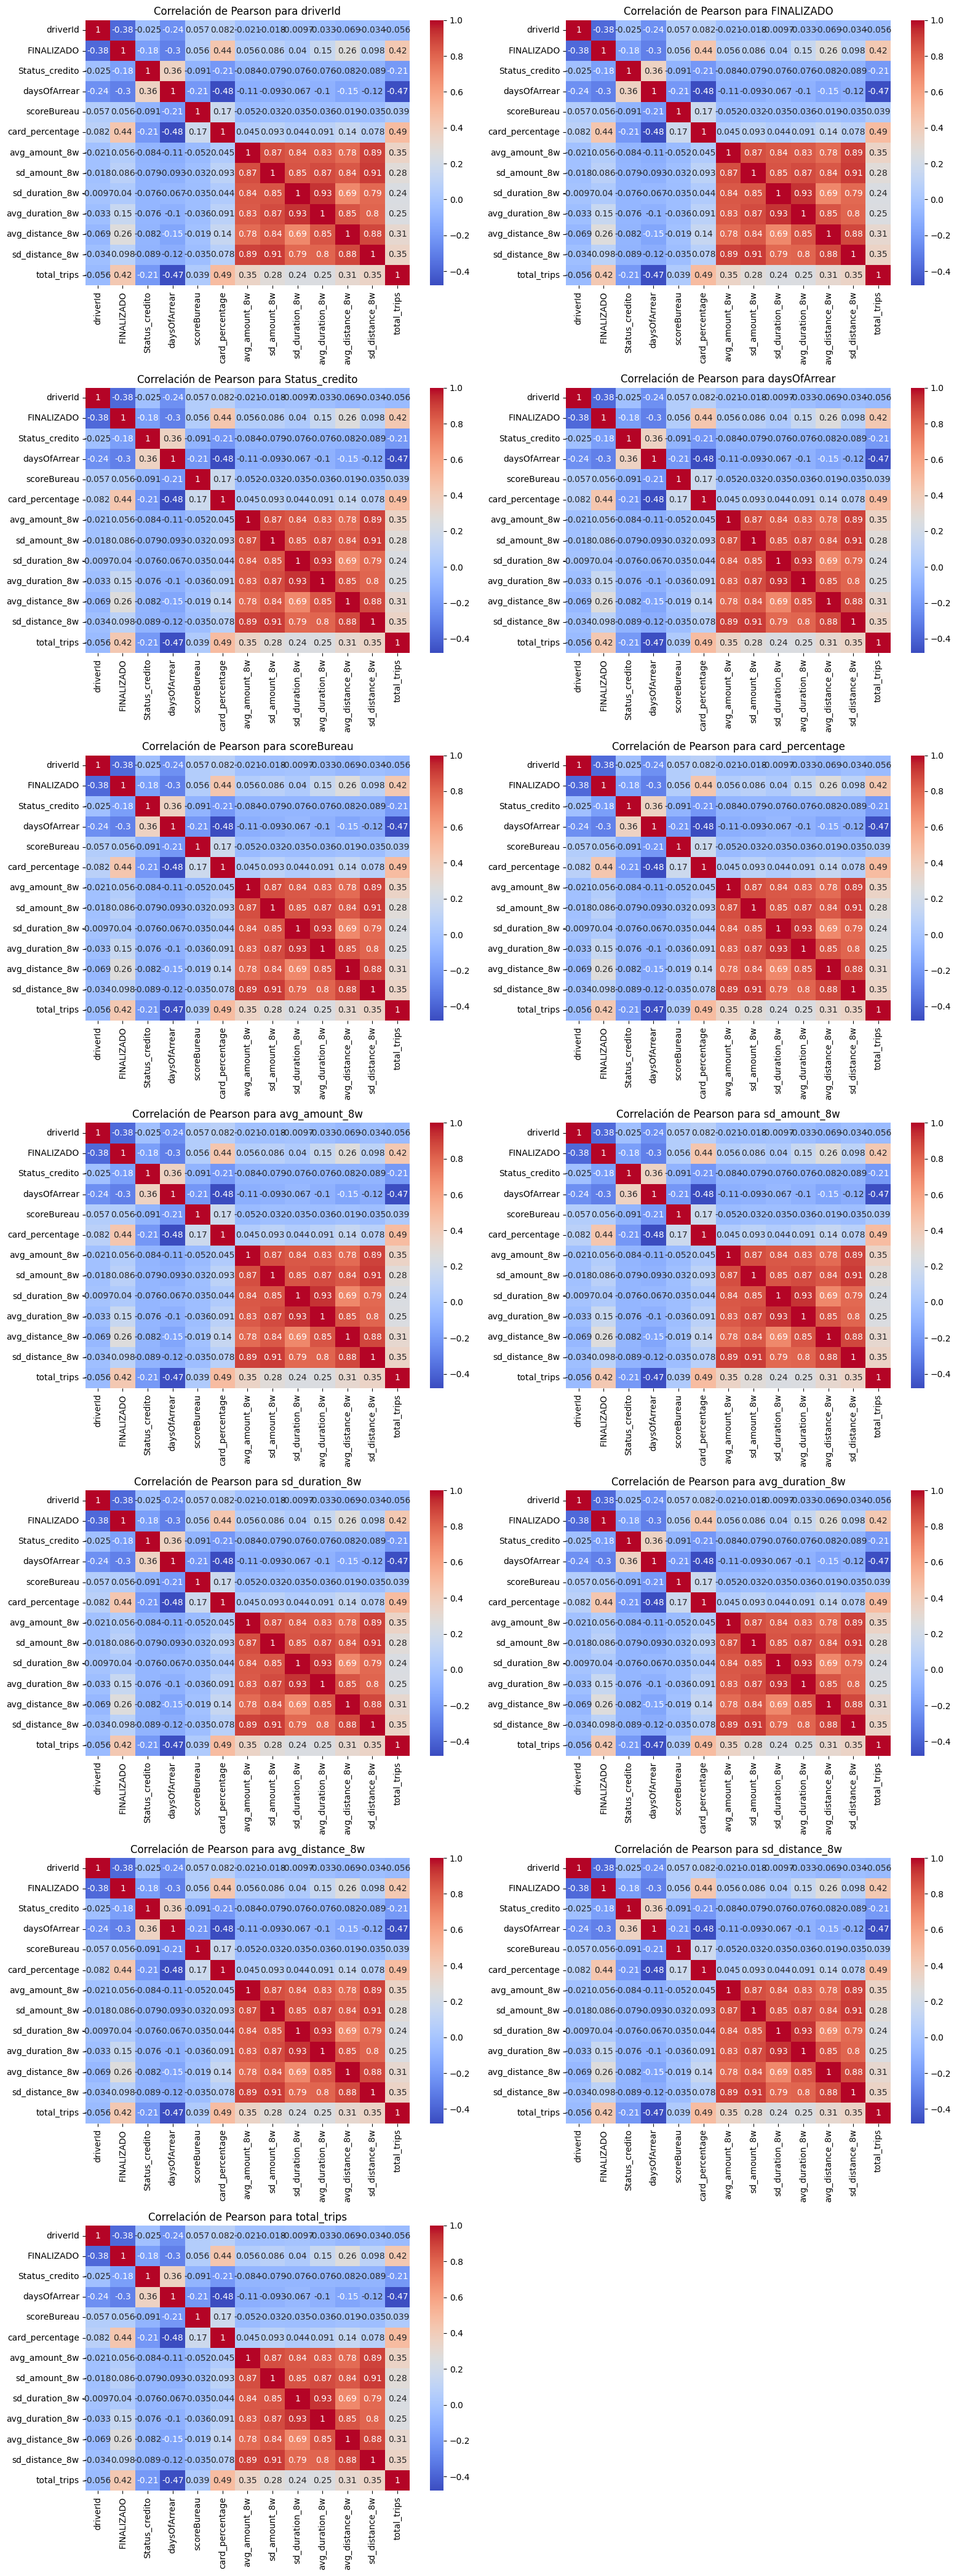

In [486]:
features_to_keep = ["driverId", "FINALIZADO", "Status_credito", "daysOfArrear", "scoreBureau",
                     "card_percentage", "avg_amount_8w", "sd_amount_8w", "sd_duration_8w",
                     "avg_duration_8w", "avg_distance_8w", "sd_distance_8w", "total_trips"]

# ||||||||||||||
# columnas_creditos = ["driverId", "FINALIZADO", "Status_credito", "daysOfArrear", "scoreBureau",
#                     "card_percentage", "avg_amount_8w", "sd_amount_8w", "sd_duration_8w",
#                     "avg_duration_8w", "avg_distance_8w", "sd_distance_8w", "total_trips"]

num_columnas = len(columnas_creditos)
num_horizontal = 2
num_vertical = (num_columnas + num_horizontal - 1) // num_horizontal

fig, axs = plt.subplots(num_vertical, num_horizontal, figsize=(16, num_vertical * 6))

for i, columna in enumerate(columnas_creditos):
    df = df_modelo[[columna]]  # Accessing DataFrame column
    correlacion = df_modelo.corr()

    ax = axs[i // num_horizontal, i % num_horizontal] if num_columnas > 1 else axs
    sns.heatmap(correlacion, annot=True, cmap='coolwarm', cbar=True, ax=ax)
    ax.set_title(f'Correlación de Pearson para {columna}')

# Eliminatios of empty axis. | Eliminar ejes vacíos
for i in range(num_columnas, num_vertical * num_horizontal):
    axs[i // num_horizontal, i % num_horizontal].axis('off')

plt.tight_layout()
plt.show()


#### Linear Regression | Regresion Lineal

In [487]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


results = []

for column in columnas_creditos:
    df = df_modelo
    X = df.drop(columns=column)
    y = df['Status_credito'	]  # Replace 'default' with the appropriate target column
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    results.append({'Columna': column, 'R^2 Score': r2, 'Mean Squared Error': mse})

results_df = pd.DataFrame(results)
results_df


Columna  R^2 Score  Mean Squared Error
0          driverId   1.000000        4.667519e-24
1        FINALIZADO   1.000000        3.457655e-24
2    Status_credito   0.128509        6.575109e-02
3      daysOfArrear   1.000000        4.103133e-24
4       scoreBureau   1.000000        2.725085e-25
5   card_percentage   1.000000        2.409740e-24
6     avg_amount_8w   1.000000        5.634264e-24
7      sd_amount_8w   1.000000        1.222742e-24
8    sd_duration_8w   1.000000        9.046971e-25
9   avg_duration_8w   1.000000        3.773418e-25
10  avg_distance_8w   1.000000        6.229781e-25
11   sd_distance_8w   1.000000        3.824908e-25
12      total_trips   1.000000        3.626396e-24

In [488]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Step 1: Data Preprocessing
# Assuming df_modelo contains your DataFrame
# Perform necessary preprocessing steps such as handling missing values, encoding categorical variables, etc.

# Step 2: Split the data into train and test sets
X = df_modelo.drop(columns=['Status_credito'])
y = df_modelo['Status_credito']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Model Selection, Training, and Evaluation
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f"{name} - Accuracy: {score}")

    if hasattr(model, 'coef_'):  # Check if the model has coefficients (e.g., Logistic Regression)
        coefficients = model.coef_[0]
        feature_names = X.columns
        feature_importance = dict(zip(feature_names, coefficients))
        print(f"{name} - Feature Importance: {feature_importance}")

# Step 4: Feature Importance Analysis
# Visualize feature importance if applicable

# Step 5: Visualization
# Visualize the results (e.g., feature importance plots)


Logistic Regression - Accuracy: 0.9119638826185101
Logistic Regression - Feature Importance: {'driverId': -0.003367376197698931, 'FINALIZADO': -0.046400009196600644, 'daysOfArrear': 0.0017211111751158528, 'scoreBureau': -0.16318265127499348, 'card_percentage': -0.04552943881656833, 'avg_amount_8w': -0.5602778836785551, 'sd_amount_8w': 0.10567408823381753, 'sd_duration_8w': 0.0008765952061288286, 'avg_duration_8w': 0.00021491877103313632, 'avg_distance_8w': 0.08523193400666919, 'sd_distance_8w': -0.2837641352503727, 'total_trips': -0.00024861879912389253}
Random Forest - Accuracy: 0.9255079006772009


In [489]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Assuming df_modelo is your DataFrame
# Let's say you want to calculate correlations between all columns and the 'Status_credito' column
# And then perform linear regression between 'Status_credito' and other columns

# Calculating correlations
correlations = df_modelo.corr()['Status_credito'].sort_values(ascending=False)
print("Correlations with 'Status_credito':")
print(correlations)

# Perform linear regression
for column in df_modelo.columns:
    if column != 'Status_credito':  # Skip 'Status_credito' column itself
        X = df_modelo[[column]]
        y = df_modelo['Status_credito']

        # Create and fit the linear regression model
        model = LinearRegression()
        model.fit(X, y)

        # Print the results
        print(f"\nLinear Regression Results for '{column}':")
        print("Coefficient:", model.coef_[0])
        print("Intercept:", model.intercept_)
        print("R-squared:", model.score(X, y))


Correlations with 'Status_credito':
Status_credito     1.000000
daysOfArrear       0.363876
driverId          -0.024934
sd_duration_8w    -0.075507
avg_duration_8w   -0.075536
sd_amount_8w      -0.079370
avg_distance_8w   -0.082486
avg_amount_8w     -0.084370
sd_distance_8w    -0.089028
scoreBureau       -0.090573
FINALIZADO        -0.181672
total_trips       -0.205871
card_percentage   -0.210362
Name: Status_credito, dtype: float64

Linear Regression Results for 'driverId':
Coefficient: -2.0719597585021237e-05
Intercept: 0.08707241373346188
R-squared: 0.0006217163682843418

Linear Regression Results for 'FINALIZADO':
Coefficient: -0.0008026448856389919
Intercept: 0.12682739754111386
R-squared: 0.03300462864301523

Linear Regression Results for 'daysOfArrear':
Coefficient: 0.0005975304905383715
Intercept: -0.017021381454402074
R-squared: 0.1324053938597809

Linear Regression Results for 'scoreBureau':
Coefficient: -0.00021703508064708216
Intercept: 0.09109676589398298
R-squared: 0.0082

#### Random Forest and Gradient Boosting

In [490]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Assuming df_modelo is your DataFrame
# Let's say you want to calculate feature importances using Random Forest and Gradient Boosting

# Convert the dataframe into features (X) and target variable (y)
X = df_modelo.drop('Status_credito', axis=1)
y = df_modelo['Status_credito']

# Initialize Random Forest Regressor and Gradient Boosting Regressor
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()

# Fit the models
rf.fit(X, y)
gb.fit(X, y)

# Extract feature importances
rf_feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
gb_feature_importances = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print feature importances
print("Random Forest Feature Importances:")
print(rf_feature_importances)

print("\nGradient Boosting Feature Importances:")
print(gb_feature_importances)


Random Forest Feature Importances:
daysOfArrear       0.437034
FINALIZADO         0.380373
driverId           0.095359
card_percentage    0.022957
total_trips        0.019223
sd_amount_8w       0.011501
avg_amount_8w      0.008652
avg_duration_8w    0.008102
scoreBureau        0.006366
sd_duration_8w     0.005427
sd_distance_8w     0.003179
avg_distance_8w    0.001827
dtype: float64

Gradient Boosting Feature Importances:
daysOfArrear       0.496273
FINALIZADO         0.397490
driverId           0.033478
avg_amount_8w      0.020370
card_percentage    0.015709
sd_amount_8w       0.013462
total_trips        0.009142
avg_duration_8w    0.008051
scoreBureau        0.005740
sd_duration_8w     0.000234
avg_distance_8w    0.000052
sd_distance_8w     0.000000
dtype: float64


#### Spearman


In [491]:
# Measure for calculating Spearman correlation. | Calcula la correlación de Spearman
spearman_correlation = df_modelo.corr(method='spearman')

# Display Spearman correlation. | Muestra la correlación de Spearman
print("Spearman's correlation:") # | Correlación de Spearman
print(spearman_correlation["Status_credito"])


Spearman's correlation:
driverId           0.102788
FINALIZADO        -0.251276
Status_credito     1.000000
daysOfArrear       0.330526
scoreBureau       -0.155531
card_percentage   -0.178191
avg_amount_8w     -0.072645
sd_amount_8w      -0.072572
sd_duration_8w    -0.071385
avg_duration_8w   -0.072107
avg_distance_8w   -0.071471
sd_distance_8w    -0.070478
total_trips       -0.237972
Name: Status_credito, dtype: float64


#### Kendall

In [492]:
# Measure for calculating Kendall correlation. | Calcula la correlación de Kendall
kendall_correlation = df_modelo.corr(method='kendall')

# Display Kendall correlation. | Muestra la correlación de Kendall
print("Kendall's correlation:") # | Correlación de Kendall
print(kendall_correlation["Status_credito"])


Kendall's correlation:
driverId           0.085148
FINALIZADO        -0.209512
Status_credito     1.000000
daysOfArrear       0.275725
scoreBureau       -0.149693
card_percentage   -0.150510
avg_amount_8w     -0.070813
sd_amount_8w      -0.070743
sd_duration_8w    -0.069695
avg_duration_8w   -0.070366
avg_distance_8w   -0.069770
sd_distance_8w    -0.068835
total_trips       -0.201005
Name: Status_credito, dtype: float64


### Conclusion of correlations | Conclusion de las correlaciones

In reviewing the conclusions drawn from the correlation analysis, it's evident that the calculated correlations are not as accurate as expected. This discrepancy appears to be associated with the size of the dataframe used for the analysis. Due to its limited scope, the correlations obtained may not fully capture the underlying relationships within the data.

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Al revisar las conclusiones obtenidas del análisis de correlación, es evidente que las correlaciones calculadas no son tan precisas como se esperaba. Esta discrepancia parece esta asociada al tamaño del dataframe utilizado para el análisis. Debido a su alcance limitado, las correlaciones obtenidas pueden no capturar completamente las relaciones subyacentes dentro de los datos.

## Model | Modelo

#### Number of Completed Credits | Cantidad de creditos finalizados

In [493]:
df_modelo.head(1)

driverId  FINALIZADO  Status_credito  daysOfArrear  scoreBureau  \
0         5          43               0           413          249   

   card_percentage  avg_amount_8w  sd_amount_8w  sd_duration_8w  \
0         0.627107            0.0           0.0             0.0   

   avg_duration_8w  avg_distance_8w  sd_distance_8w  total_trips  
0              0.0              0.0             0.0       1527.0

In [494]:
# I create a dataframe only with the credit information to assign a value to this variable. | Creo df solo con la info de creditos para asignar valor a esta variable
df_modelo_creditos = df_modelo[["driverId", "FINALIZADO", "Status_credito"]]
df_modelo_creditos.drop_duplicates(inplace = True)
df_modelo_creditos.head()

driverId  FINALIZADO  Status_credito
0          5          43               0
1          1           4               0
17         9           4               0
21        13           1               0
25        12           2               0

In [495]:
## Complete credits. | CREDITOS FINALIZADOS

## The driver with completed credits, has more credibility and due to that we want them to have more score. Also those that had a credit in Arrear in their history should be also penalized. | EL DRIVER CON CREDITOS FINALIZADOS, TIENE MAS CREDIBILIDAD Y POR ENDE MAS SCORE. A SU VEZ AQUELLOS QUE TUVIERON MORA DEBERIAN SER PENALIZADOS

puntos_creditos_finalizados = 300 # Points for completed credits, first attemp

# Function to calculate scores based on credits and status
def calculate_score(FINALIZADO, Status_credito):
    if FINALIZADO >= 10:
        if Status_credito == 1:
            return 70
        else:
            return 100
    elif FINALIZADO >= 1 and FINALIZADO <= 9:
        if Status_credito == 1:
            return 25
        else:
            return 50
    elif FINALIZADO == 0:
        return 0



# Apply the function to the 'Credits' and 'Status' columns to get 'Score'
df_modelo_creditos['Score_creditos_finalizados'] = [calculate_score(FINALIZADO, Status_credito) for FINALIZADO, Status_credito in zip(df_modelo_creditos['FINALIZADO'], df_modelo_creditos['Status_credito'])]


df_modelo_creditos.head()



driverId  FINALIZADO  Status_credito  Score_creditos_finalizados
0          5          43               0                         100
1          1           4               0                          50
17         9           4               0                          50
21        13           1               0                          50
25        12           2               0                          50

In [496]:
df_modelo_creditos.max()

driverId                      1940
FINALIZADO                     209
Status_credito                   1
Score_creditos_finalizados     100
dtype: int64

#### Max driver arrear

In [497]:
## Days of Arrear

#These are the days when the driver was in debt, which is why we take the highest day of debt they have had and assign a portion of the score
# to whether they take a long time to repay their loan
#||||||
# son los dias en los que el driver estuvo con deuda, es por eso que tomamos el mayor dia de la deuda que haya tenido y asignamos una parte del score
# a si se demora mucho o no en abonar su prestamo

puntos_max_daysofarrear = 75 # Points assing to max_days_of_arrear
df_modelo_arrear = df_modelo[["driverId", "daysOfArrear"]]
df_modelo_arrear.head(1)

driverId  daysOfArrear
0         5           413

In [498]:
# Function to calculate scores based on max days of arrear
def calculate_score(daysOfArrear):
    if daysOfArrear <= 0:
      return 100

    elif daysOfArrear >= 5 and daysOfArrear <= 15:
      return 80

    elif daysOfArrear >= 15 and daysOfArrear <= 60 :
      return 50

    elif daysOfArrear >=60:
      return 0

In [499]:
# Apply the function to the 'Credits' column to get 'Score'
df_modelo_arrear['Score_max_days_of_Arrear'] = [calculate_score(daysOfArrear) for daysOfArrear in df_modelo_arrear['daysOfArrear']]
df_modelo_arrear.drop_duplicates(inplace = True)
df_modelo_arrear.head()

driverId  daysOfArrear  Score_max_days_of_Arrear
0          5           413                       0.0
1          1             0                     100.0
17         9            74                       0.0
21        13             0                     100.0
25        12           316                       0.0

#### Bureau Score

In [500]:
## The bureau score that the driver has with financial institutions in Argentina also gives us a good indication of how reliable a driver is,
# and what assigned score they have from other platforms
# |||||||||||||||||||||||||||||||||||||||||
# El bureau score que el driver tiene con las instituciones financieras de Argentina tambien nos da un buen indicio de que tan confiable
# es un driver y que score asignado tiene de otras plataformas

puntos_Bureau_Score = 200 # Points assigned to the Bureau Score obtained from an application owned by the company
df_modelo_bureau = df_modelo[["driverId", "scoreBureau"]]
df_modelo_bureau.drop_duplicates(inplace = True)
df_modelo_bureau.head(1)


driverId  scoreBureau
0         5          249

#### Card %

In [501]:
puntos_card_percentage = 50 # Points assign to card percentage
df_modelo_card_pct = df_modelo[["driverId", "card_percentage"]]
df_modelo_card_pct.drop_duplicates(inplace = True)
df_modelo_card_pct.head(1)


driverId  card_percentage
0         5         0.627107

#### Amount

In [502]:
df_sorted.columns
df_amount = df_sorted[['driverId', 'Fecha','avg_amount_8w', 'avg_amount_4w','sd_amount_8w']] #,'amount_usd'
df_amount[df_amount["driverId"]== 5]

driverId      Fecha  avg_amount_8w  avg_amount_4w  sd_amount_8w
8423          5 2023-07-10            NaN            NaN           NaN
8418          5 2023-07-17       0.000000       0.000000      0.000000
8422          5 2023-07-24       0.000000       0.000000      0.000000
8421          5 2023-07-31       0.000000       0.000000      0.000000
8420          5 2023-08-07       0.000000       0.000000      0.000000
8417          5 2023-08-14       0.000000       0.000000      0.000000
8419          5 2023-08-21       0.000000       0.000000      0.000000
2290          5 2023-08-28       0.000000       0.000000      0.000000
2292          5 2023-09-04      59.811044     119.622089    169.171180
2293          5 2023-09-11     131.922473     263.844946    245.684617
2295          5 2023-09-18     192.431044     384.862089    267.218357
11151         5 2023-09-25     259.584566     519.169133    279.187122
2299          5 2023-09-25     259.584566     399.547044    279.187122
2294          5 2023-10-02     330.977781     398.110615    276.335308
11152         5 2023-10-02     366.907914     348.953738    243.940794
11153         5 2023-10-09     366.907914     214.646694    243.940794
2296          5 2023-10-09     307.096869     214.646694    269.947643
11145         5 2023-10-16     321.972867     245.835119    289.509453
2297          5 2023-10-16     261.464296     173.974854    301.143363
2291          5 2023-10-23     284.695087     354.743480    331.130571
11165         5 2023-10-23     362.366897     510.087101    327.669395
11146         5 2023-10-23     290.973683     336.112247    337.747977
2303          5 2023-10-30     255.043550     336.112247    353.116994
11161         5 2023-10-30     331.724505     308.705529    356.412243
11156         5 2023-10-30     331.724505     153.361909    356.412243
11154         5 2023-11-06     244.737078     153.361909    339.346239
11160         5 2023-11-06     244.737078     153.361909    339.346239
2298          5 2023-11-06     154.352765       0.000000    285.813636
11147         5 2023-11-13     153.518097     153.674286    284.260476
11162         5 2023-11-13     153.518097     153.674286    284.260476
2300          5 2023-11-13     153.518097     153.674286    284.260476
2302          5 2023-11-20     152.430408     304.860816    282.258801
11158         5 2023-11-20     222.455208     291.236130    307.409020
11157         5 2023-11-20     222.455208     291.236130    307.409020
11150         5 2023-11-27     222.455208     291.236130    307.409020
11167         5 2023-11-27     222.455208     140.049600    307.409020
2305          5 2023-11-27     145.618065       0.000000    269.894993
2301          5 2023-12-04     219.279439     147.322747    302.875790
11163         5 2023-12-04     294.438426     297.640722    315.046480
11149         5 2023-12-04     218.845161     297.640722    302.245968
2304          5 2023-12-11     148.820361     297.640722    275.580366
11148         5 2023-12-11     193.679290     240.035833    277.099036
11166         5 2023-12-11     193.679290      89.717858    277.099036
2306          5 2023-12-18     193.679290      89.717858    277.099036
11164         5 2023-12-18     228.099767     158.558812    266.503731
11155         5 2023-12-18     154.438393      68.840954    231.557489
8426          5 2023-12-25      79.279406      68.840954    148.483834
3561          5 2023-12-25      79.279406      68.840954    148.483834
3566          5 2023-12-25     100.143650      41.728487    147.476002
3565          5 2024-01-01      55.672186      42.503417    106.166963
3567          5 2024-01-01      81.541780      94.242606    115.470287
8427          5 2024-01-01      94.127339     119.413724    110.701607
8424          5 2024-01-01      59.706862      77.685237     86.453176
3555          5 2024-01-01      59.706862      76.910307     86.453176
3556          5 2024-01-01     102.509602     110.776597    127.629687
3568          5 2024-01-08     

In [503]:
# Checking the amount of drivers to see if it works getting the last of them
df_amount.driverId.nunique()

510

In [504]:
df_amount = df_sorted[['driverId', 'Fecha','avg_amount_8w', 'avg_amount_4w','sd_amount_8w','amount_usd']] #
df_amount.head()
df_amount.amount_usd.describe()

count    17103.000000
mean        86.086464
std        150.002089
min          0.000000
25%          0.000000
50%          0.000000
75%        117.567912
max       1202.245826
Name: amount_usd, dtype: float64

In [505]:
dfWeekly_Earnings2.driverId.nunique()
dfWeekly_Earnings2.head()
dfWeekly_Earnings2.amount_usd.describe()

count    17103.000000
mean        86.086464
std        150.002089
min          0.000000
25%          0.000000
50%          0.000000
75%        117.567912
max       1202.245826
Name: amount_usd, dtype: float64

In [506]:
dfWeekly_Earnings2.head()

driverId  card_percentage  cash_percentage  total_trips      Fecha  \
5106        381         0.000000         0.000000            0 2023-02-27   
360          31         0.828982         0.171018           10 2023-02-27   
5486        399         0.000000         0.000000            0 2023-02-27   
36           31         0.828982         0.171018           10 2023-02-27   
14123       374         1.000000         0.000000            5 2023-02-27   

       amount_usd  cash_amount_usd  card_amount_usd  Suma_de_porcentajes  \
5106     0.000000         0.000000         0.000000                  0.0   
360     51.701763         8.841913        42.859851                100.0   
5486     0.000000         0.000000         0.000000                  0.0   
36      51.701763         8.841913        42.859851                100.0   
14123   41.990904         0.000000        41.990904                100.0   

       nueva_suma_%  
5106            0.0  
360             1.0  
5486            0.0  
36              1.0  
14123           1.0

In [507]:
# Convert 'Fecha' (date) to date format. | Convertir 'Fecha' a formato de fecha
dfWeekly_Earnings2['Fecha'] = pd.to_datetime(df_prueba_weekly['Fecha'])

# Order the df for 'driverId' and 'Fecha'.| Ordenar el DataFrame por 'driver_id' y 'Fecha'
df_amount_rework = dfWeekly_Earnings2.sort_values(by=['driverId', 'Fecha'])

# Function to calculate the average taking into consideration handling of special cases. | fn calcula el promedio con manejo de casos especiales
def custom_mean(x):
    if x.notna().sum() == 0:
        return x.iloc[0]  # If there's no data, returns the same value. | Si no hay datos, devolver el mismo valor
    elif x.notna().sum() == 1:
        return x.iloc[0]  # If there's one value, return the same value. | Si hay solo un dato, devolver el mismo valor
    else:
        return x.mean()  # If there's more than one value, returns the average. | Si hay más de un dato, devolver el promedio


# Function to calculate the average taking into consideration handling of special cases. | n tfn calcula la std con manejo de casos especiales
def custom_std(x):
    if x.notna().sum() == 0:
        return None  # If there's no data, returns None. | Si no hay datos, devolver None
    elif x.notna().sum() == 1:
        return 0  # If there's only one value, returns 0 for std dev. | Si hay solo un dato, devolver 0 para la desviación estándar
    else:
        return x.std()  # If there's more than one value, returns the std dev. | Si hay más de un dato, devolver la desviación estándar

# Calculate the columns with customized mean and standard deviation. | Calcular las columnas con promedio y desviación estándar personalizadas
df_amount_rework['cumsum_amount_8w'] = df_amount_rework.groupby(['driverId'])['amount_usd'].transform(lambda x: x.rolling(window=8, min_periods=1).sum().shift())
df_amount_rework['cumsum_amount_4w'] = df_amount_rework.groupby(['driverId'])['amount_usd'].transform(lambda x: x.rolling(window=4, min_periods=1).sum().shift())
df_amount_rework['cumsum_trips_8w'] = df_amount_rework.groupby(['driverId'])['total_trips'].transform(lambda x: x.rolling(window=8, min_periods=1).sum().shift())
df_amount_rework['cumsum_trips_4w'] = df_amount_rework.groupby(['driverId'])['total_trips'].transform(lambda x: x.rolling(window=4, min_periods=1).sum().shift())

df_amount_rework['avg_amount_8w'] = df_amount_rework.groupby(['driverId'])['amount_usd'].transform(lambda x: x.rolling(window=8, min_periods=1).apply(custom_mean).shift())
df_amount_rework['avg_amount_4w'] = df_amount_rework.groupby(['driverId'])['amount_usd'].transform(lambda x: x.rolling(window=4, min_periods=1).apply(custom_mean).shift())
df_amount_rework['avg_trips_8w'] = df_amount_rework.groupby(['driverId'])['total_trips'].transform(lambda x: x.rolling(window=8, min_periods=1).apply(custom_mean).shift())
df_amount_rework['avg_trips_4w'] = df_amount_rework.groupby(['driverId'])['total_trips'].transform(lambda x: x.rolling(window=4, min_periods=1).apply(custom_mean).shift())

df_amount_rework['sd_amount_8w'] = df_amount_rework.groupby(['driverId'])['amount_usd'].transform(lambda x: x.rolling(window=8, min_periods=1).apply(custom_std).shift())
df_amount_rework['sd_amount_4w'] = df_amount_rework.groupby(['driverId'])['amount_usd'].transform(lambda x: x.rolling(window=4, min_periods=1).apply(custom_std).shift())
df_amount_rework['sd_trips_8w'] = df_amount_rework.groupby(['driverId'])['total_trips'].transform(lambda x: x.rolling(window=8, min_periods=1).apply(custom_std).shift())
df_amount_rework['sd_trips_4w'] = df_amount_rework.groupby(['driverId'])['total_trips'].transform(lambda x: x.rolling(window=4, min_periods=1).apply(custom_std).shift())

In [508]:
df_amount_rework.head()

driverId  card_percentage  cash_percentage  total_trips      Fecha  \
8423         5              0.0              0.0            0 2023-07-10   
8418         5              0.0              0.0            0 2023-07-17   
8422         5              0.0              0.0            0 2023-07-24   
8421         5              0.0              0.0            0 2023-07-31   
8420         5              0.0              0.0            0 2023-08-07   

      amount_usd  cash_amount_usd  card_amount_usd  Suma_de_porcentajes  \
8423         0.0              0.0              0.0                  0.0   
8418         0.0              0.0              0.0                  0.0   
8422         0.0              0.0              0.0                  0.0   
8421         0.0              0.0              0.0                  0.0   
8420         0.0              0.0              0.0                  0.0   

      nueva_suma_%  cumsum_amount_8w  cumsum_amount_4w  cumsum_trips_8w  \
8423           0.0               NaN               NaN              NaN   
8418           0.0               0.0               0.0              0.0   
8422           0.0               0.0               0.0              0.0   
8421           0.0               0.0               0.0              0.0   
8420           0.0               0.0               0.0              0.0   

      cumsum_trips_4w  avg_amount_8w  avg_amount_4w  avg_trips_8w  \
8423              NaN            NaN            NaN           NaN   
8418              0.0            0.0            0.0           0.0   
8422              0.0            0.0            0.0           0.0   
8421              0.0            0.0            0.0           0.0   
8420              0.0            0.0            0.0           0.0   

      avg_trips_4w  sd_amount_8w  sd_amount_4w  sd_trips_8w  sd_trips_4w  
8423           NaN           NaN           NaN          NaN          NaN  
8418           0.0           0.0           0.0          0.0          0.0  
8422           0.0           0.0           0.0          0.0          0.0  
8421           0.0           0.0           0.0          0.0          0.0  
8420           0.0           0.0           0.0          0.0          0.0

In [509]:
df_amount_rework1 = df_amount_rework[['driverId', 'Fecha', 'avg_amount_8w', 'avg_amount_4w', 'sd_amount_8w']]
df_amount_rework1.fillna(0, inplace = True)
df_amount_rework1.head()

driverId      Fecha  avg_amount_8w  avg_amount_4w  sd_amount_8w
8423         5 2023-07-10            0.0            0.0           0.0
8418         5 2023-07-17            0.0            0.0           0.0
8422         5 2023-07-24            0.0            0.0           0.0
8421         5 2023-07-31            0.0            0.0           0.0
8420         5 2023-08-07            0.0            0.0           0.0

In [510]:
# Group by 'driverids' and select the last row in each group. This is too get the last information of the amount made to make the df for the scoring
last_day_df_amount = df_amount_rework1.groupby('driverId').last().reset_index()

last_day_df_amount.shape


(510, 5)

In [511]:
last_day_df_amount.describe()

driverId                          Fecha  avg_amount_8w  \
count   510.000000                            510     510.000000   
mean    888.768627  2023-12-14 18:55:03.529411840      70.152421   
min       5.000000            2023-06-05 00:00:00       0.000000   
25%     450.250000            2023-10-30 00:00:00       0.000000   
50%     773.000000            2024-02-05 00:00:00      24.498152   
75%    1339.250000            2024-02-05 00:00:00      96.617504   
max    2025.000000            2024-02-19 00:00:00     639.452974   
std     533.706822                            NaN     106.679372   

       avg_amount_4w  sd_amount_8w  
count     510.000000    510.000000  
mean       69.400642     52.959422  
min         0.000000      0.000000  
25%         0.000000      0.000000  
50%        12.630086     33.982653  
75%        90.860763     85.796000  
max       768.888214    332.105475  
std       116.735468     62.270075

In [512]:
# Sort values by 'avg_amount_8w' column in descending order
last_day_df_amount = last_day_df_amount.sort_values(by='avg_amount_8w', ascending=False)
last_day_df_amount.head(10)

driverId      Fecha  avg_amount_8w  avg_amount_4w  sd_amount_8w
219       661 2023-12-18     639.452974     768.888214    332.105475
103       403 2023-12-11     602.709156     662.535081    227.490996
147       491 2023-07-03     588.873010     702.528331    301.947429
15         55 2023-07-17     566.424284     542.233285    187.771995
303       989 2023-12-18     528.935452     536.486665    196.444723
16         60 2023-08-07     527.629710     577.833240    108.090789
401      1445 2024-01-08     468.796938     340.403680    142.184310
18         63 2023-07-17     433.092283     500.770746    159.286388
210       628 2023-10-30     415.849948     407.864882    185.400885
140       480 2024-02-12     403.837828     388.518773    132.863429

In [513]:
df_amount_rework1 = df_amount_rework1[['driverId', 'Fecha','avg_amount_8w', 'avg_amount_4w','sd_amount_8w']] #,'amount_usd'
df_amount_rework1[df_amount_rework1["driverId"]== 257]

Empty DataFrame
Columns: [driverId, Fecha, avg_amount_8w, avg_amount_4w, sd_amount_8w]
Index: []

In [514]:
last_day_df_amount.head()

driverId      Fecha  avg_amount_8w  avg_amount_4w  sd_amount_8w
219       661 2023-12-18     639.452974     768.888214    332.105475
103       403 2023-12-11     602.709156     662.535081    227.490996
147       491 2023-07-03     588.873010     702.528331    301.947429
15         55 2023-07-17     566.424284     542.233285    187.771995
303       989 2023-12-18     528.935452     536.486665    196.444723

In [515]:
# Step 1: Identify and remove outliers from the earnings column using 1.5 of the mean. All of them that are 1.5 above the average will be treated as
# outliers and will receive 100% of the points.

# todos los que esten 1.5 por encima del promedio seran considerados outliers y llevaran el 100% de los puntos
# al resto se los normalizara y con eso tendremos un %

mean_avg_amount_8w = last_day_df_amount['avg_amount_8w'].mean()


last_day_df_amount["Outlier_avg_amount_8w"] = last_day_df_amount['avg_amount_8w'].apply(lambda x: 'Yes' if x > mean_avg_amount_8w else 'No')
last_day_df_amount.head(2)

# Now, taking the dataframe that does not has outliers and normalize. | Tomo los no outliers y los normalizo
No_outliers_avg_amount_8w = last_day_df_amount[last_day_df_amount["Outlier_avg_amount_8w"]== "No"]
No_outliers_avg_amount_8w.head()
# Step 2: Normalize avg_amount_8w without outliers
avg_amount_8w_min = No_outliers_avg_amount_8w['avg_amount_8w'].min()
avg_amount_8w_max = No_outliers_avg_amount_8w['avg_amount_8w'].max()
No_outliers_avg_amount_8w['normalized_avg_amount_8w'] = (No_outliers_avg_amount_8w['avg_amount_8w'] - avg_amount_8w_min) / (avg_amount_8w_max - avg_amount_8w_min)
No_outliers_avg_amount_8w.head()

# Step 3: Calculate the percentage based on normalized avg_amount_8w
No_outliers_avg_amount_8w['normalized_avg_amount_8w'] = No_outliers_avg_amount_8w['normalized_avg_amount_8w'] * 100
No_outliers_avg_amount_8w.head()

# Outliers receive a score of 100 that would be 100% of the points. | Marco los outliers como 100 que seria el 100% del puntaje
# Map 'Yes' to 1 and 'No' to 0
last_day_df_amount['Score_avg_amount_8w'] = last_day_df_amount['Outlier_avg_amount_8w'].map({'Yes': 100, 'No': 0})
last_day_df_amount.head(2)
last_day_df_amount['Outlier_avg_amount_8w']== "No"

# Merge the two DataFrames based on 'driver' column, but only for rows where 'outlier' is 'No'
last_day_df_amount= pd.merge(last_day_df_amount, No_outliers_avg_amount_8w, on='driverId', how='left')
last_day_df_amount.head()
# Taking 100 for the outliers and the normalize dataframe from not outliers for having the feature uniform. |  Tomo 100 para los que son outliers y el puntaje normalizado para no outliers para tener la variable uniforme
last_day_df_amount['Score_avg_amount_8weeks'] = last_day_df_amount.apply(lambda row: row['Score_avg_amount_8w'] if row['Outlier_avg_amount_8w_x'] == 'Yes' else row['normalized_avg_amount_8w'], axis=1)

last_day_df_amount_8_w = last_day_df_amount[['driverId','Fecha_x', 'Score_avg_amount_8weeks' ]]

last_day_df_amount_8_w.head()





driverId    Fecha_x  Score_avg_amount_8weeks
0       661 2023-12-18                    100.0
1       403 2023-12-11                    100.0
2       491 2023-07-03                    100.0
3        55 2023-07-17                    100.0
4       989 2023-12-18                    100.0

In [516]:
last_day_df_amount_8_w.Score_avg_amount_8weeks.max()
#last_day_df_amount_8_w.Score_avg_amount_8weeks.value_counts()

100.0

In [517]:
# Group by 'driverids' and select the last row in each group. This is too get the last information of the amount made to make the df for the scoring
last_day_df_amount = df_amount_rework1.groupby('driverId').last().reset_index()
last_day_df_amount.head(1)

driverId      Fecha  avg_amount_8w  avg_amount_4w  sd_amount_8w
0         5 2024-02-19     112.908177     134.946426     173.49035

In [518]:
# Same proccess but for this feature. | Mismo proceso pero para otra variable

mean_avg_amount_4w = last_day_df_amount['avg_amount_4w'].mean()

last_day_df_amount["Outlier_avg_amount_4w"] = last_day_df_amount['avg_amount_4w'].apply(lambda x: 'Yes' if x > mean_avg_amount_4w else 'No')
last_day_df_amount.head(2)

No_outliers_avg_amount_4w = last_day_df_amount[last_day_df_amount["Outlier_avg_amount_4w"]== "No"]
No_outliers_avg_amount_4w.head()

avg_amount_4w_min = No_outliers_avg_amount_4w['avg_amount_4w'].min()
avg_amount_4w_max = No_outliers_avg_amount_4w['avg_amount_4w'].max()
No_outliers_avg_amount_4w['normalized_avg_amount_4w'] = (No_outliers_avg_amount_4w['avg_amount_4w'] - avg_amount_4w_min) / (avg_amount_4w_max - avg_amount_4w_min)
No_outliers_avg_amount_4w.head()


No_outliers_avg_amount_4w['normalized_avg_amount_4w'] = No_outliers_avg_amount_4w['normalized_avg_amount_4w'] * 100
No_outliers_avg_amount_4w.head()


last_day_df_amount['Score_avg_amount_4w'] = last_day_df_amount['Outlier_avg_amount_4w'].map({'Yes': 100, 'No': 0})
last_day_df_amount.head(2)
last_day_df_amount['Outlier_avg_amount_4w']== "No"


last_day_df_amount= pd.merge(last_day_df_amount, No_outliers_avg_amount_4w, on='driverId', how='left')
last_day_df_amount.head()

last_day_df_amount['Score_avg_amount_4weeks'] = last_day_df_amount.apply(lambda row: row['Score_avg_amount_4w'] if row['Outlier_avg_amount_4w_x'] == 'Yes' else row['normalized_avg_amount_4w'], axis=1)

last_day_df_amount_4_w = last_day_df_amount[['driverId','Fecha_x', 'Score_avg_amount_4weeks' ]]

last_day_df_amount_4_w.head()

driverId    Fecha_x  Score_avg_amount_4weeks
0         5 2024-02-19                    100.0
1        10 2024-02-19                      0.0
2        15 2023-06-12                    100.0
3        19 2024-02-19                    100.0
4        22 2024-02-05                    100.0

In [519]:
last_day_df_amount_4_w.Score_avg_amount_4weeks.max()
#last_day_df_amount_4_w.Score_avg_amount_4weeks.value_counts()

100.0

In [520]:
# Group by 'driverids' and select the last row in each group. This is too get the last information of the amount made to make the df for the scoring
last_day_df_amount = df_amount_rework1.groupby('driverId').last().reset_index()
last_day_df_amount.head(5)

driverId      Fecha  avg_amount_8w  avg_amount_4w  sd_amount_8w
0         5 2024-02-19     112.908177     134.946426    173.490350
1        10 2024-02-19       0.000000       0.000000      0.000000
2        15 2023-06-12      69.813845      83.757761     88.986973
3        19 2024-02-19     146.706100     157.748345     87.190760
4        22 2024-02-05      71.955530      81.274683     35.087965

In [521]:
last_day_df_amount_std_dev_8w = last_day_df_amount[["driverId", "Fecha","sd_amount_8w"]]
last_day_df_amount_std_dev_8w.head(1)

driverId      Fecha  sd_amount_8w
0         5 2024-02-19     173.49035

In [522]:
# Same proccess but for this feature. | Mismo proceso pero para otra variable

mean_sd_amount_8w = last_day_df_amount_std_dev_8w['sd_amount_8w'].mean()


last_day_df_amount_std_dev_8w["Outlier_sd_amount_8w"] = last_day_df_amount_std_dev_8w['sd_amount_8w'].apply(lambda x: 'Yes' if x > mean_sd_amount_8w else 'No')
last_day_df_amount_std_dev_8w.head(2)


No_outliers_sd_amount_8w = last_day_df_amount_std_dev_8w[last_day_df_amount_std_dev_8w["Outlier_sd_amount_8w"]== "No"]
No_outliers_sd_amount_8w.head()

sd_amount_8w_min = No_outliers_sd_amount_8w['sd_amount_8w'].min()
sd_amount_8w_max = No_outliers_sd_amount_8w['sd_amount_8w'].max()
No_outliers_sd_amount_8w['normalized_sd_amount_8w'] = (No_outliers_sd_amount_8w['sd_amount_8w'] - sd_amount_8w_min) / (sd_amount_8w_max - sd_amount_8w_min)
No_outliers_sd_amount_8w.head()


No_outliers_sd_amount_8w['normalized_sd_amount_8w'] = No_outliers_sd_amount_8w['normalized_sd_amount_8w'] * 100
No_outliers_sd_amount_8w.head()

last_day_df_amount_std_dev_8w['Score_sd_amount_8w'] = last_day_df_amount_std_dev_8w['Outlier_sd_amount_8w'].map({'Yes': 100, 'No': 0})
last_day_df_amount_std_dev_8w.head(2)
last_day_df_amount_std_dev_8w['Outlier_sd_amount_8w']== "No"


last_day_df_amount_std_dev_8w= pd.merge(last_day_df_amount_std_dev_8w, No_outliers_sd_amount_8w, on='driverId', how='left')
last_day_df_amount_std_dev_8w.head()

last_day_df_amount_std_dev_8w['Score_sd_amount_8weeks'] = last_day_df_amount_std_dev_8w.apply(lambda row: row['Score_sd_amount_8w'] if row['Outlier_sd_amount_8w_x'] == 'Yes' else row['normalized_sd_amount_8w'], axis=1)

last_day_df_amount_std_dev_8w_4_w = last_day_df_amount_std_dev_8w[['driverId','Fecha_x', 'Score_sd_amount_8weeks' ]]

last_day_df_amount_std_dev_8w_4_w.head()

driverId    Fecha_x  Score_sd_amount_8weeks
0         5 2024-02-19              100.000000
1        10 2024-02-19                0.000000
2        15 2023-06-12              100.000000
3        19 2024-02-19              100.000000
4        22 2024-02-05               66.353877

In [523]:
last_day_df_amount_std_dev_8w_4_w.Score_sd_amount_8weeks.max()

100.0

#### Distance

In [524]:
df_sorted_trips.columns
df_trips = df_sorted_trips[['driverId', 'Fecha','avg_distance_8w', 'avg_distance_4w','sd_distance_8w','avg_duration_8w', 'avg_duration_4w', 'sd_duration_8w']] #,'amount_usd'
df_trips[df_trips["driverId"]== 5].head(5)

driverId      Fecha  avg_distance_8w  avg_distance_4w  sd_distance_8w  \
5         5 2021-12-27              NaN              NaN             NaN   
6         5 2022-01-03       119.990000       119.990000        0.000000   
7         5 2022-01-10       283.165000       283.165000      230.764298   
8         5 2022-01-17       397.176667       397.176667      256.168033   
9         5 2022-01-24       429.532500       429.532500      218.942094   

   avg_duration_8w  avg_duration_4w  sd_duration_8w  
5              NaN              NaN             NaN  
6         14346.00         14346.00        0.000000  
7         31209.50         31209.50    23848.590409  
8         39676.00         39676.00    22347.762729  
9         46195.25         46195.25    22426.564938

In [525]:
# Checking the amount of drivers to see if it works getting the last of them
df_trips.driverId.nunique()

203

In [526]:
# Group by 'driverids' and select the last row in each group. This is too get the last information of the amount made to make the df for the scoring
last_day_df_trips = df_trips.groupby('driverId').last().reset_index()

last_day_df_trips.shape

(203, 8)

In [527]:
last_day_df_trips.describe()

driverId                          Fecha  avg_distance_8w  \
count       203.0                            203       190.000000   
mean   162.236453  2022-11-27 04:08:16.551724032       200.629118   
min           1.0            2022-02-14 00:00:00         0.000000   
25%          69.0            2022-09-12 00:00:00        26.381250   
50%         143.0            2022-10-24 00:00:00       144.818750   
75%         228.0            2023-05-01 00:00:00       290.506250   
max         467.0            2023-11-06 00:00:00      1080.387500   
std    111.655957                            NaN       210.894063   

       avg_distance_4w  sd_distance_8w  avg_duration_8w  avg_duration_4w  \
count       190.000000      190.000000       190.000000       190.000000   
mean        195.387500      103.762964     40240.893734     36469.567544   
min           0.000000        0.000000         0.000000         0.000000   
25%          23.400000        0.000000     17512.239583     14663.750000   
50%         141.975000       86.920703     32516.250000     27346.000000   
75%         301.570833      160.447555     55993.137500     51819.437500   
max         962.000000      453.691913    288695.400000    159534.666667   
std         207.394428      100.412467     34099.546059     28701.220787   

       sd_duration_8w  
count      190.000000  
mean     22574.445153  
min          0.000000  
25%       8197.880272  
50%      17305.132043  
75%      29707.942015  
max     475519.452713  
std      37608.529588

In [528]:
# Same proccess than before but for this feature. | Mismo proceso pero para otra variable

mean_avg_distance_8w = last_day_df_trips['avg_distance_8w'].mean()


last_day_df_trips["Outlier_avg_distance_8w"] = last_day_df_trips['avg_distance_8w'].apply(lambda x: 'Yes' if x > mean_avg_distance_8w else 'No')
last_day_df_trips.head(5)

No_outliers_avg_distance_8w = last_day_df_trips[last_day_df_trips["Outlier_avg_distance_8w"]== "No"]
No_outliers_avg_distance_8w.head()

avg_distance_8w_min = No_outliers_avg_distance_8w['avg_distance_8w'].min()
avg_distance_8w_max = No_outliers_avg_distance_8w['avg_distance_8w'].max()
No_outliers_avg_distance_8w['normalized_avg_distance_8w'] = (No_outliers_avg_distance_8w['avg_distance_8w'] - avg_distance_8w_min) / (avg_distance_8w_max - avg_distance_8w_min)
No_outliers_avg_distance_8w.head()

No_outliers_avg_distance_8w['normalized_avg_distance_8w'] = No_outliers_avg_distance_8w['normalized_avg_distance_8w'] * 100
No_outliers_avg_distance_8w.head()


last_day_df_trips['Score_avg_distance_8w'] = last_day_df_trips['Outlier_avg_distance_8w'].map({'Yes': 100, 'No': 0})
last_day_df_trips.head(2)

last_day_df_trips= pd.merge(last_day_df_trips, No_outliers_avg_distance_8w, on='driverId', how='left')
last_day_df_trips.head()

last_day_df_trips['Score_avg_distance_8weeks'] = last_day_df_trips.apply(lambda row: row['Score_avg_distance_8w'] if row['Outlier_avg_distance_8w_x'] == 'Yes' else row['normalized_avg_distance_8w'], axis=1)

last_day_df_trips_8_w = last_day_df_trips[['driverId','Fecha_x', 'Score_avg_distance_8weeks' ]]

last_day_df_trips_8_w.head()

driverId    Fecha_x  Score_avg_distance_8weeks
0         1 2023-11-06                  16.973055
1         4 2023-11-06                   8.713170
2         5 2022-10-31                 100.000000
3         6 2023-11-06                  35.406699
4         8 2023-11-06                  65.909091

In [529]:
# Group by 'driverids' and select the last row in each group. This is too get the last information of the amount made to make the df for the scoring
last_day_df_trips = df_trips.groupby('driverId').last().reset_index()

last_day_df_trips.shape

(203, 8)

In [530]:
# Same proccess than before but for this feature. | Mismo proceso pero para otra variable

mean_avg_distance_4w = last_day_df_trips['avg_distance_4w'].mean()
last_day_df_trips["Outlier_avg_distance_4w"] = last_day_df_trips['avg_distance_4w'].apply(lambda x: 'Yes' if x > mean_avg_distance_4w else 'No')
last_day_df_trips.head(5)

No_outliers_avg_distance_4w = last_day_df_trips[last_day_df_trips["Outlier_avg_distance_4w"]== "No"]
No_outliers_avg_distance_4w.head()

avg_distance_4w_min = No_outliers_avg_distance_4w['avg_distance_4w'].min()
avg_distance_4w_max = No_outliers_avg_distance_4w['avg_distance_4w'].max()
No_outliers_avg_distance_4w['normalized_avg_distance_4w'] = (No_outliers_avg_distance_4w['avg_distance_4w'] - avg_distance_4w_min) / (avg_distance_4w_max - avg_distance_4w_min)
No_outliers_avg_distance_4w.head()

No_outliers_avg_distance_4w['normalized_avg_distance_4w'] = No_outliers_avg_distance_4w['normalized_avg_distance_4w'] * 100
No_outliers_avg_distance_4w.head()

last_day_df_trips['Score_avg_distance_4w'] = last_day_df_trips['Outlier_avg_distance_4w'].map({'Yes': 100, 'No': 0})
last_day_df_trips.head(2)

last_day_df_trips= pd.merge(last_day_df_trips, No_outliers_avg_distance_4w, on='driverId', how='left')
last_day_df_trips.head()

last_day_df_trips['Score_avg_distance_4weeks'] = last_day_df_trips.apply(lambda row: row['Score_avg_distance_4w'] if row['Outlier_avg_distance_4w_x'] == 'Yes' else row['normalized_avg_distance_4w'], axis=1)

last_day_df_trips_4_w = last_day_df_trips[['driverId','Fecha_x', 'Score_avg_distance_4weeks' ]]

last_day_df_trips_4_w.head()

driverId    Fecha_x  Score_avg_distance_4weeks
0         1 2023-11-06                  17.863769
1         4 2023-11-06                   9.170421
2         5 2022-10-31                 100.000000
3         6 2023-11-06                  37.264776
4         8 2023-11-06                  17.267426

In [531]:
# Group by 'driverids' and select the last row in each group. This is too get the last information of the amount made to make the df for the scoring
last_day_df_trips = df_trips.groupby('driverId').last().reset_index()

last_day_df_trips.head(2)
last_day_df_trips_std_dev_distance8w = last_day_df_trips[['driverId','Fecha', 'sd_distance_8w' ]]

last_day_df_trips_std_dev_distance8w.head(2)

driverId      Fecha  sd_distance_8w
0         1 2023-11-06        0.000000
1         4 2023-11-06       13.435029

In [532]:
# Same proccess than before but for this feature. | Mismo proceso pero para otra variable

mean_sd_distance_8w = last_day_df_trips_std_dev_distance8w['sd_distance_8w'].mean()

last_day_df_trips_std_dev_distance8w["Outlier_sd_distance_8w"] = last_day_df_trips_std_dev_distance8w['sd_distance_8w'].apply(lambda x: 'Yes' if x > mean_sd_distance_8w else 'No')
last_day_df_trips_std_dev_distance8w.head(5)

No_outliers_sd_distance_8w = last_day_df_trips_std_dev_distance8w[last_day_df_trips_std_dev_distance8w["Outlier_sd_distance_8w"]== "No"]
No_outliers_sd_distance_8w.head()

sd_distance_8w_min = No_outliers_sd_distance_8w['sd_distance_8w'].min()
sd_distance_8w_max = No_outliers_sd_distance_8w['sd_distance_8w'].max()
No_outliers_sd_distance_8w['normalized_sd_distance_8w'] = (No_outliers_sd_distance_8w['sd_distance_8w'] - sd_distance_8w_min) / (sd_distance_8w_max - sd_distance_8w_min)
No_outliers_sd_distance_8w.head()

No_outliers_sd_distance_8w['normalized_sd_distance_8w'] = No_outliers_sd_distance_8w['normalized_sd_distance_8w'] * 100
No_outliers_sd_distance_8w.head()

last_day_df_trips_std_dev_distance8w['Score_sd_distance_8w'] = last_day_df_trips_std_dev_distance8w['Outlier_sd_distance_8w'].map({'Yes': 100, 'No': 0})
last_day_df_trips_std_dev_distance8w.head(2)

last_day_df_trips_std_dev_distance8w= pd.merge(last_day_df_trips_std_dev_distance8w, No_outliers_sd_distance_8w, on='driverId', how='left')
last_day_df_trips_std_dev_distance8w.head()

last_day_df_trips_std_dev_distance8w['Score_sd_distance_8weeks'] = last_day_df_trips_std_dev_distance8w.apply(lambda row: row['Score_sd_distance_8w'] if row['Outlier_sd_distance_8w_x'] == 'Yes' else row['normalized_sd_distance_8w'], axis=1)

last_day_df_trips_std_dev_distance8w_4_w = last_day_df_trips_std_dev_distance8w[['driverId','Fecha_x', 'Score_sd_distance_8weeks' ]]

last_day_df_trips_std_dev_distance8w_4_w.head()

driverId    Fecha_x  Score_sd_distance_8weeks
0         1 2023-11-06                  0.000000
1         4 2023-11-06                 13.013699
2         5 2022-10-31                100.000000
3         6 2023-11-06                  0.000000
4         8 2023-11-06                100.000000

#### Duration

In [533]:
## DURATION

# Group by 'driverids' and select the last row in each group. This is too get the last information of the amount made to make the df for the scoring
last_day_df_trips = df_trips.groupby('driverId').last().reset_index()
last_day_df_trips.head(2)

driverId      Fecha  avg_distance_8w  avg_distance_4w  sd_distance_8w  \
0         1 2023-11-06             33.7             33.7        0.000000   
1         4 2023-11-06             17.3             17.3       13.435029   

   avg_duration_8w  avg_duration_4w  sd_duration_8w  
0            477.0            477.0         0.00000  
1           9244.0           9244.0       226.27417

In [534]:
# Same proccess than before but for this feature. | Mismo proceso pero para otra variable

mean_avg_duration_8w = last_day_df_trips['avg_duration_8w'].mean()

last_day_df_trips["Outlier_avg_duration_8w"] = last_day_df_trips['avg_duration_8w'].apply(lambda x: 'Yes' if x > mean_avg_duration_8w else 'No')
last_day_df_trips.head(5)

No_outliers_avg_duration_8w = last_day_df_trips[last_day_df_trips["Outlier_avg_duration_8w"]== "No"]
No_outliers_avg_duration_8w.head()

avg_duration_8w_min = No_outliers_avg_duration_8w['avg_duration_8w'].min()
avg_duration_8w_max = No_outliers_avg_duration_8w['avg_duration_8w'].max()
No_outliers_avg_duration_8w['normalized_avg_duration_8w'] = (No_outliers_avg_duration_8w['avg_duration_8w'] - avg_duration_8w_min) / (avg_duration_8w_max - avg_duration_8w_min)
No_outliers_avg_duration_8w.head()

No_outliers_avg_duration_8w['normalized_avg_duration_8w'] = No_outliers_avg_duration_8w['normalized_avg_duration_8w'] * 100
No_outliers_avg_duration_8w.head()

last_day_df_trips['Score_avg_duration_8w'] = last_day_df_trips['Outlier_avg_duration_8w'].map({'Yes': 100, 'No': 0})
last_day_df_trips.head(2)

last_day_df_trips= pd.merge(last_day_df_trips, No_outliers_avg_duration_8w, on='driverId', how='left')
last_day_df_trips.head()

last_day_df_trips['Score_avg_duration_8weeks'] = last_day_df_trips.apply(lambda row: row['Score_avg_duration_8w'] if row['Outlier_avg_duration_8w_x'] == 'Yes' else row['normalized_avg_duration_8w'], axis=1)

last_day_df_trips_duration_8w = last_day_df_trips[['driverId','Fecha_x', 'Score_avg_duration_8weeks' ]]

last_day_df_trips_duration_8w.head()

driverId    Fecha_x  Score_avg_duration_8weeks
0         1 2023-11-06                   1.190822
1         4 2023-11-06                  23.077475
2         5 2022-10-31                 100.000000
3         6 2023-11-06                   4.501156
4         8 2023-11-06                  52.765633

In [535]:
# Group by 'driverids' and select the last row in each group. This is too get the last information of the amount made to make the df for the scoring
last_day_df_trips = df_trips.groupby('driverId').last().reset_index()


In [536]:
# Same proccess than before but for this feature. | Mismo proceso pero para otra variable

mean_avg_duration_4w = last_day_df_trips['avg_duration_4w'].mean()

last_day_df_trips["Outlier_avg_duration_4w"] = last_day_df_trips['avg_duration_4w'].apply(lambda x: 'Yes' if x > mean_avg_duration_4w else 'No')
last_day_df_trips.head(5)

No_outliers_avg_duration_4w = last_day_df_trips[last_day_df_trips["Outlier_avg_duration_4w"]== "No"]
No_outliers_avg_duration_4w.head()

avg_duration_4w_min = No_outliers_avg_duration_4w['avg_duration_4w'].min()
avg_duration_4w_max = No_outliers_avg_duration_4w['avg_duration_4w'].max()
No_outliers_avg_duration_4w['normalized_avg_duration_4w'] = (No_outliers_avg_duration_4w['avg_duration_4w'] - avg_duration_4w_min) / (avg_duration_4w_max - avg_duration_4w_min)
No_outliers_avg_duration_4w.head()

No_outliers_avg_duration_4w['normalized_avg_duration_4w'] = No_outliers_avg_duration_4w['normalized_avg_duration_4w'] * 100
No_outliers_avg_duration_4w.head()

last_day_df_trips['Score_avg_duration_4w'] = last_day_df_trips['Outlier_avg_duration_4w'].map({'Yes': 100, 'No': 0})
last_day_df_trips.head(2)

last_day_df_trips= pd.merge(last_day_df_trips, No_outliers_avg_duration_4w, on='driverId', how='left')
last_day_df_trips.head()

last_day_df_trips['Score_avg_duration_4weeks'] = last_day_df_trips.apply(lambda row: row['Score_avg_duration_4w'] if row['Outlier_avg_duration_4w_x'] == 'Yes' else row['normalized_avg_duration_4w'], axis=1)

last_day_df_trips_duration_4w = last_day_df_trips[['driverId','Fecha_x', 'Score_avg_duration_4weeks' ]]

last_day_df_trips_duration_4w.head()

driverId    Fecha_x  Score_avg_duration_4weeks
0         1 2023-11-06                   1.335573
1         4 2023-11-06                  25.882682
2         5 2022-10-31                 100.000000
3         6 2023-11-06                   5.048299
4         8 2023-11-06                  12.330953

In [537]:
# Group by 'driverids' and select the last row in each group. This is too get the last information of the amount made to make the df for the scoring
last_day_df_trips = df_trips.groupby('driverId').last().reset_index()
last_day_df_trips_std_dev_duration8w = last_day_df_trips[['driverId','Fecha', 'sd_duration_8w' ]]

last_day_df_trips_std_dev_duration8w.head(2)

driverId      Fecha  sd_duration_8w
0         1 2023-11-06         0.00000
1         4 2023-11-06       226.27417

In [538]:
# Same proccess than before but for this feature. | Mismo proceso pero para otra variable

mean_sd_duration_8w = last_day_df_trips_std_dev_duration8w['sd_duration_8w'].mean()

last_day_df_trips_std_dev_duration8w["Outlier_sd_duration_8w"] = last_day_df_trips_std_dev_duration8w['sd_duration_8w'].apply(lambda x: 'Yes' if x > mean_sd_duration_8w else 'No')
last_day_df_trips_std_dev_duration8w.head(5)

No_outliers_sd_duration_8w = last_day_df_trips_std_dev_duration8w[last_day_df_trips_std_dev_duration8w["Outlier_sd_duration_8w"]== "No"]
No_outliers_sd_duration_8w.head()

sd_duration_8w_min = No_outliers_sd_duration_8w['sd_duration_8w'].min()
sd_duration_8w_max = No_outliers_sd_duration_8w['sd_duration_8w'].max()
No_outliers_sd_duration_8w['normalized_sd_duration_8w'] = (No_outliers_sd_duration_8w['sd_duration_8w'] - sd_duration_8w_min) / (sd_duration_8w_max - sd_duration_8w_min)
No_outliers_sd_duration_8w.head()

No_outliers_sd_duration_8w['normalized_sd_duration_8w'] = No_outliers_sd_duration_8w['normalized_sd_duration_8w'] * 100
No_outliers_sd_duration_8w.head()

last_day_df_trips_std_dev_duration8w['Score_sd_duration_8w'] = last_day_df_trips_std_dev_duration8w['Outlier_sd_duration_8w'].map({'Yes': 100, 'No': 0})
last_day_df_trips_std_dev_duration8w.head(2)

last_day_df_trips_std_dev_duration8w= pd.merge(last_day_df_trips_std_dev_duration8w, No_outliers_sd_duration_8w, on='driverId', how='left')
last_day_df_trips_std_dev_duration8w.head()

last_day_df_trips_std_dev_duration8w['Score_sd_duration_8weeks'] = last_day_df_trips_std_dev_duration8w.apply(lambda row: row['Score_sd_duration_8w'] if row['Outlier_sd_duration_8w_x'] == 'Yes' else row['normalized_sd_duration_8w'], axis=1)

last_day_df_trips_std_dev_duration8w_duration_4w = last_day_df_trips_std_dev_duration8w[['driverId','Fecha_x', 'Score_sd_duration_8weeks' ]]

last_day_df_trips_std_dev_duration8w_duration_4w.head()

driverId    Fecha_x  Score_sd_duration_8weeks
0         1 2023-11-06                  0.000000
1         4 2023-11-06                  1.004746
2         5 2022-10-31                 89.785125
3         6 2023-11-06                  0.000000
4         8 2023-11-06                100.000000

#### Trips

In [539]:
df_trips_score = df_modelo
df_trips_score = df_trips_score[["driverId", "total_trips"]]
df_trips_score.drop_duplicates (inplace = True)
df_trips_score.head(2)

driverId  total_trips
0         5       1527.0
1         1          0.0

In [540]:
df_trips_score.describe()

driverId  total_trips
count       234.0   234.000000
mean   517.777778   650.085470
std    518.034244   863.716345
min           1.0     0.000000
25%        128.25     0.000000
50%         333.5   384.500000
75%        744.25   852.500000
max        1940.0  4951.000000

In [541]:
# Function to calculate scores based on total trips
def calculate_score(total_trips):
    if total_trips == 0:
      return 0

    elif total_trips > 0 and total_trips <= 100:
      return 10

    elif total_trips >= 100 and total_trips <= 200:
      return 20

    elif total_trips >= 200 and total_trips <= 400 :
      return 30

    elif total_trips >= 400 and total_trips <= 600 :
      return 40

    elif total_trips >= 600 and total_trips <= 800 :
      return 50

    elif total_trips >= 800 and total_trips <= 1000 :
      return 65

    elif total_trips >= 1000 and total_trips <= 1500 :
      return 75

    elif total_trips >= 1500 and total_trips <= 2500 :
      return 85

    elif total_trips >= 2500:
      return 100

In [542]:
# Apply the function to the 'Credits' column to get 'Score'
df_trips_score['Score_total_trips'] = [calculate_score(total_trips) for total_trips in df_trips_score['total_trips']]

df_trips_score.head()

driverId  total_trips  Score_total_trips
0          5       1527.0                 85
1          1          0.0                  0
17         9          0.0                  0
21        13          0.0                  0
25        12          0.0                  0

#### Features with score | Variables con puntaje

In [543]:
## All the features together with their dataframes. | Las variables ya cocinadas con sus dataframes

puntos_creditos_finalizados = 250
puntos_max_daysofarrear = 150
puntos_Bureau_Score = 0.15
puntos_card_percentage = 50
puntos_amount_8_weeks = 100
puntos_amount_4_weeks = 30
puntos_stddev_amount_8_weeks = 25
puntos_distance_8_weeks = 50
puntos_distance_4_weeks = 15
puntos_stddev_distance_8_weeks = 25
puntos_duration_8_weeks = 50
puntos_duration_4_weeks = 15
puntos_stddev_duration_8_weeks = 15
puntos_total_trips = 50


df_modelo_creditos
df_modelo_arrear
df_modelo_bureau
df_modelo_card_pct
last_day_df_amount_8_w
last_day_df_amount_4_w
last_day_df_amount_std_dev_8w_4_w
last_day_df_trips_8_w
last_day_df_trips_4_w
last_day_df_trips_std_dev_distance8w_4_w
last_day_df_trips_duration_8w
last_day_df_trips_duration_4w
last_day_df_trips_std_dev_duration8w_duration_4w
df_trips_score.head(1)


driverId  total_trips  Score_total_trips
0         5       1527.0                 85

In [544]:
CHECK_1000 = puntos_creditos_finalizados + puntos_max_daysofarrear + (puntos_Bureau_Score *100) + puntos_card_percentage + puntos_amount_8_weeks + puntos_amount_4_weeks + puntos_stddev_amount_8_weeks + puntos_distance_8_weeks + puntos_distance_4_weeks + puntos_stddev_distance_8_weeks + puntos_duration_8_weeks + puntos_duration_4_weeks + puntos_stddev_duration_8_weeks + puntos_total_trips
CHECK_1000

840.0

In [545]:
df_modelo.driverId.nunique()

234

In [546]:
df_sem_week_trip_credit.driverId.nunique()

234

In [547]:
# I take the drivers from the dfcompanydriver database, which is the one with the most drivers, as there may be some who do not have all the measurements and therefore
#their score will not take those variables into account and will be low, since we cannot rely on something that does not exist
# |||||||||||||||||
# Tomo los drivers de la base de datos de dfcompanydriver que es el que mas drivers tiene, ya que seguramente haya algunos que no cuenten
# con todas las mediciones y por ende su score no tendra en cuenta esas variables y sera bajo, ya que no se podria confiar en algo que no existe
dfCompanyDriver.driverId.nunique()

782

##### Merging dataframes with drivers score | Juntando los scores de los drivers

In [548]:
df_score = dfCompanyDriver[['driverId','DriverStatus']]
df_score.head()

driverId  DriverStatus
0         1             0
1       167             0
2       166             0
3       196             0
4       198             0

In [549]:
df_score = pd.merge(df_score, df_modelo_creditos, on='driverId', how = 'left' )
df_score = df_score[['driverId', 'DriverStatus', 'Score_creditos_finalizados']]
df_score.head(1)

driverId  DriverStatus  Score_creditos_finalizados
0         1             0                        50.0

In [550]:
df_score = pd.merge(df_score, df_modelo_arrear, on='driverId', how = 'left' )
df_score = df_score[['driverId', 'DriverStatus', 'Score_creditos_finalizados', 'Score_max_days_of_Arrear']]
df_score.head(1)

driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   

   Score_max_days_of_Arrear  
0                     100.0

In [551]:
df_score = pd.merge(df_score, df_modelo_bureau, on='driverId', how = 'left' )
df_score = df_score[['driverId',  'DriverStatus',  'Score_creditos_finalizados', 'Score_max_days_of_Arrear', 'scoreBureau']]
df_score.head(1)


driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   

   Score_max_days_of_Arrear  scoreBureau  
0                     100.0            0

In [552]:
df_score = pd.merge(df_score, df_modelo_card_pct, on='driverId', how = 'left' )
df_score = df_score[['driverId',  'DriverStatus',  'Score_creditos_finalizados', 'Score_max_days_of_Arrear', 'scoreBureau','card_percentage']]
df_score.head(1)

driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   

   Score_max_days_of_Arrear  scoreBureau  card_percentage  
0                     100.0            0              0.0

In [553]:
df_score = pd.merge(df_score, last_day_df_amount_8_w, on='driverId', how = 'left' )
df_score = df_score[['driverId',  'DriverStatus',  'Score_creditos_finalizados', 'Score_max_days_of_Arrear', 'scoreBureau','card_percentage',
'Score_avg_amount_8weeks']]
df_score.head(1)

driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   

   Score_max_days_of_Arrear  scoreBureau  card_percentage  \
0                     100.0            0              0.0   

   Score_avg_amount_8weeks  
0                      NaN

In [554]:
df_score = pd.merge(df_score, last_day_df_amount_4_w, on='driverId', how = 'left' )
df_score = df_score[['driverId',  'DriverStatus', 'Score_creditos_finalizados', 'Score_max_days_of_Arrear', 'scoreBureau','card_percentage',
'Score_avg_amount_8weeks', 'Score_avg_amount_4weeks']]
df_score.head(1)

driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   

   Score_max_days_of_Arrear  scoreBureau  card_percentage  \
0                     100.0            0              0.0   

   Score_avg_amount_8weeks  Score_avg_amount_4weeks  
0                      NaN                      NaN

In [555]:
df_score = pd.merge(df_score, last_day_df_amount_std_dev_8w_4_w, on='driverId', how = 'left' )
df_score = df_score[['driverId', 'DriverStatus', 'Score_creditos_finalizados', 'Score_max_days_of_Arrear', 'scoreBureau','card_percentage',
'Score_avg_amount_8weeks', 'Score_avg_amount_4weeks', 'Score_sd_amount_8weeks']]
df_score.head(1)

driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   

   Score_max_days_of_Arrear  scoreBureau  card_percentage  \
0                     100.0            0              0.0   

   Score_avg_amount_8weeks  Score_avg_amount_4weeks  Score_sd_amount_8weeks  
0                      NaN                      NaN                     NaN

In [556]:
df_score = pd.merge(df_score, last_day_df_trips_8_w, on='driverId', how = 'left' )
df_score = df_score[['driverId', 'DriverStatus', 'Score_creditos_finalizados', 'Score_max_days_of_Arrear', 'scoreBureau','card_percentage',
'Score_avg_amount_8weeks', 'Score_avg_amount_4weeks', 'Score_sd_amount_8weeks', 'Score_avg_distance_8weeks']]
df_score.head(1)

driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   

   Score_max_days_of_Arrear  scoreBureau  card_percentage  \
0                     100.0            0              0.0   

   Score_avg_amount_8weeks  Score_avg_amount_4weeks  Score_sd_amount_8weeks  \
0                      NaN                      NaN                     NaN   

   Score_avg_distance_8weeks  
0                  16.973055

In [557]:
df_score = pd.merge(df_score, last_day_df_trips_4_w, on='driverId', how = 'left' )
df_score = df_score[['driverId',  'DriverStatus', 'Score_creditos_finalizados', 'Score_max_days_of_Arrear', 'scoreBureau','card_percentage',
'Score_avg_amount_8weeks', 'Score_avg_amount_4weeks', 'Score_sd_amount_8weeks', 'Score_avg_distance_8weeks', 'Score_avg_distance_4weeks']]
df_score.head(1)

driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   

   Score_max_days_of_Arrear  scoreBureau  card_percentage  \
0                     100.0            0              0.0   

   Score_avg_amount_8weeks  Score_avg_amount_4weeks  Score_sd_amount_8weeks  \
0                      NaN                      NaN                     NaN   

   Score_avg_distance_8weeks  Score_avg_distance_4weeks  
0                  16.973055                  17.863769

In [558]:
df_score = pd.merge(df_score, last_day_df_trips_std_dev_distance8w_4_w, on='driverId', how = 'left' )
df_score = df_score[['driverId', 'DriverStatus', 'Score_creditos_finalizados', 'Score_max_days_of_Arrear', 'scoreBureau','card_percentage',
'Score_avg_amount_8weeks', 'Score_avg_amount_4weeks', 'Score_sd_amount_8weeks', 'Score_avg_distance_8weeks', 'Score_avg_distance_4weeks', 'Score_sd_distance_8weeks']]
df_score.head(1)

driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   

   Score_max_days_of_Arrear  scoreBureau  card_percentage  \
0                     100.0            0              0.0   

   Score_avg_amount_8weeks  Score_avg_amount_4weeks  Score_sd_amount_8weeks  \
0                      NaN                      NaN                     NaN   

   Score_avg_distance_8weeks  Score_avg_distance_4weeks  \
0                  16.973055                  17.863769   

   Score_sd_distance_8weeks  
0                       0.0

In [559]:
df_score = pd.merge(df_score, last_day_df_trips_duration_8w, on='driverId', how = 'left' )
df_score = df_score[['driverId', 'DriverStatus', 'Score_creditos_finalizados', 'Score_max_days_of_Arrear', 'scoreBureau','card_percentage',
'Score_avg_amount_8weeks', 'Score_avg_amount_4weeks', 'Score_sd_amount_8weeks', 'Score_avg_distance_8weeks', 'Score_avg_distance_4weeks', 'Score_sd_distance_8weeks'
, 'Score_avg_duration_8weeks']]
df_score.head(1)

driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   

   Score_max_days_of_Arrear  scoreBureau  card_percentage  \
0                     100.0            0              0.0   

   Score_avg_amount_8weeks  Score_avg_amount_4weeks  Score_sd_amount_8weeks  \
0                      NaN                      NaN                     NaN   

   Score_avg_distance_8weeks  Score_avg_distance_4weeks  \
0                  16.973055                  17.863769   

   Score_sd_distance_8weeks  Score_avg_duration_8weeks  
0                       0.0                   1.190822

In [560]:
df_score = pd.merge(df_score, last_day_df_trips_duration_4w, on='driverId', how = 'left' )
df_score = df_score[['driverId', 'DriverStatus', 'Score_creditos_finalizados', 'Score_max_days_of_Arrear', 'scoreBureau','card_percentage',
'Score_avg_amount_8weeks', 'Score_avg_amount_4weeks', 'Score_sd_amount_8weeks', 'Score_avg_distance_8weeks', 'Score_avg_distance_4weeks', 'Score_sd_distance_8weeks'
, 'Score_avg_duration_8weeks', 'Score_avg_duration_4weeks']]
df_score.head(1)

driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   

   Score_max_days_of_Arrear  scoreBureau  card_percentage  \
0                     100.0            0              0.0   

   Score_avg_amount_8weeks  Score_avg_amount_4weeks  Score_sd_amount_8weeks  \
0                      NaN                      NaN                     NaN   

   Score_avg_distance_8weeks  Score_avg_distance_4weeks  \
0                  16.973055                  17.863769   

   Score_sd_distance_8weeks  Score_avg_duration_8weeks  \
0                       0.0                   1.190822   

   Score_avg_duration_4weeks  
0                   1.335573

In [561]:
df_score = pd.merge(df_score, last_day_df_trips_std_dev_duration8w_duration_4w, on='driverId', how = 'left' )
df_score = df_score[['driverId', 'DriverStatus', 'Score_creditos_finalizados', 'Score_max_days_of_Arrear', 'scoreBureau','card_percentage',
'Score_avg_amount_8weeks', 'Score_avg_amount_4weeks', 'Score_sd_amount_8weeks', 'Score_avg_distance_8weeks', 'Score_avg_distance_4weeks', 'Score_sd_distance_8weeks'
, 'Score_avg_duration_8weeks', 'Score_avg_duration_4weeks', 'Score_sd_duration_8weeks']]
df_score.head(1)

driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   

   Score_max_days_of_Arrear  scoreBureau  card_percentage  \
0                     100.0            0              0.0   

   Score_avg_amount_8weeks  Score_avg_amount_4weeks  Score_sd_amount_8weeks  \
0                      NaN                      NaN                     NaN   

   Score_avg_distance_8weeks  Score_avg_distance_4weeks  \
0                  16.973055                  17.863769   

   Score_sd_distance_8weeks  Score_avg_duration_8weeks  \
0                       0.0                   1.190822   

   Score_avg_duration_4weeks  Score_sd_duration_8weeks  
0                   1.335573                       0.0

In [562]:
df_score = pd.merge(df_score, df_trips_score, on='driverId', how = 'left' )
df_score = df_score[['driverId', 'DriverStatus', 'Score_creditos_finalizados', 'Score_max_days_of_Arrear', 'scoreBureau','card_percentage',
'Score_avg_amount_8weeks', 'Score_avg_amount_4weeks', 'Score_sd_amount_8weeks', 'Score_avg_distance_8weeks', 'Score_avg_distance_4weeks', 'Score_sd_distance_8weeks'
, 'Score_avg_duration_8weeks', 'Score_avg_duration_4weeks', 'Score_sd_duration_8weeks', 'Score_total_trips']]
df_score.head(5)

driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   
1       167             0                         NaN   
2       166             0                        50.0   
3       196             0                         NaN   
4       198             0                         NaN   

   Score_max_days_of_Arrear  scoreBureau  card_percentage  \
0                     100.0            0              0.0   
1                       NaN         <NA>              NaN   
2                       0.0            0              0.0   
3                       NaN         <NA>              NaN   
4                       NaN         <NA>              NaN   

   Score_avg_amount_8weeks  Score_avg_amount_4weeks  Score_sd_amount_8weeks  \
0                      NaN                      NaN                     NaN   
1                      NaN                      NaN                     NaN   
2                      NaN                      NaN                     NaN   
3                      NaN                      NaN                     NaN   
4                      NaN                      NaN                     NaN   

   Score_avg_distance_8weeks  Score_avg_distance_4weeks  \
0                  16.973055                  17.863769   
1                        NaN                        NaN   
2                  83.782423                  78.982242   
3                   0.000000                   0.000000   
4                  75.837321                  47.362841   

   Score_sd_distance_8weeks  Score_avg_duration_8weeks  \
0                  0.000000                   1.190822   
1                       NaN                        NaN   
2                 50.975709                  64.559012   
3                  0.000000                 100.000000   
4                100.000000                  31.782394   

   Score_avg_duration_4weeks  Score_sd_duration_8weeks  Score_total_trips  
0                   1.335573                  0.000000                0.0  
1                        NaN                       NaN                NaN  
2                  65.476690                 31.952750                0.0  
3                  26.654067                100.000000                NaN  
4                  18.227635                 40.635044                NaN

In [563]:
df_score[df_score['driverId']==19]

driverId  DriverStatus  Score_creditos_finalizados  \
338         19             1                       100.0   
564         19             1                       100.0   
870         19             0                       100.0   
1080        19             0                       100.0   

      Score_max_days_of_Arrear  scoreBureau  card_percentage  \
338                       50.0           64         0.946783   
564                       50.0           64         0.946783   
870                       50.0           64         0.946783   
1080                      50.0           64         0.946783   

      Score_avg_amount_8weeks  Score_avg_amount_4weeks  \
338                     100.0                    100.0   
564                     100.0                    100.0   
870                     100.0                    100.0   
1080                    100.0                    100.0   

      Score_sd_amount_8weeks  Score_avg_distance_8weeks  \
338                    100.0                      100.0   
564                    100.0                      100.0   
870                    100.0                      100.0   
1080                   100.0                      100.0   

      Score_avg_distance_4weeks  Score_sd_distance_8weeks  \
338                       100.0                 93.084283   
564                       100.0                 93.084283   
870                       100.0                 93.084283   
1080                      100.0                 93.084283   

      Score_avg_duration_8weeks  Score_avg_duration_4weeks  \
338                       100.0                      100.0   
564                       100.0                      100.0   
870                       100.0                      100.0   
1080                      100.0                      100.0   

      Score_sd_duration_8weeks  Score_total_trips  
338                  55.326051              100.0  
564                  55.326051              100.0  
870                  55.326051              100.0  
1080                 55.326051              100.0

In [564]:
puntos_creditos_finalizados + puntos_max_daysofarrear + puntos_Bureau_Score + puntos_card_percentage + puntos_amount_8_weeks + puntos_amount_4_weeks + puntos_stddev_amount_8_weeks + puntos_distance_8_weeks + puntos_distance_4_weeks + puntos_stddev_distance_8_weeks + puntos_duration_8_weeks + puntos_duration_4_weeks + puntos_stddev_duration_8_weeks + puntos_total_trips
# Fill NaN values in 'Score_max_days_of_Arrear' column with 100
df_score['Score_max_days_of_Arrear'].fillna(100, inplace=True)

# Fill NaN values with 0, for not having errors in nan values
df_score.fillna(0, inplace=True)



In [565]:
df_score.head(5)

driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                        50.0   
1       167             0                         0.0   
2       166             0                        50.0   
3       196             0                         0.0   
4       198             0                         0.0   

   Score_max_days_of_Arrear  scoreBureau  card_percentage  \
0                     100.0            0              0.0   
1                     100.0            0              0.0   
2                       0.0            0              0.0   
3                     100.0            0              0.0   
4                     100.0            0              0.0   

   Score_avg_amount_8weeks  Score_avg_amount_4weeks  Score_sd_amount_8weeks  \
0                      0.0                      0.0                     0.0   
1                      0.0                      0.0                     0.0   
2                      0.0                      0.0                     0.0   
3                      0.0                      0.0                     0.0   
4                      0.0                      0.0                     0.0   

   Score_avg_distance_8weeks  Score_avg_distance_4weeks  \
0                  16.973055                  17.863769   
1                   0.000000                   0.000000   
2                  83.782423                  78.982242   
3                   0.000000                   0.000000   
4                  75.837321                  47.362841   

   Score_sd_distance_8weeks  Score_avg_duration_8weeks  \
0                  0.000000                   1.190822   
1                  0.000000                   0.000000   
2                 50.975709                  64.559012   
3                  0.000000                 100.000000   
4                100.000000                  31.782394   

   Score_avg_duration_4weeks  Score_sd_duration_8weeks  Score_total_trips  
0                   1.335573                  0.000000                0.0  
1                   0.000000                  0.000000                0.0  
2                  65.476690                 31.952750                0.0  
3                  26.654067                100.000000                0.0  
4                  18.227635                 40.635044                0.0

In [566]:
# Columns to be divided by 100
columns_to_divide = ['Score_creditos_finalizados', 'Score_max_days_of_Arrear','Score_avg_amount_8weeks', 'Score_avg_amount_4weeks',
       'Score_sd_amount_8weeks', 'Score_avg_distance_8weeks','Score_avg_distance_4weeks', 'Score_sd_distance_8weeks',
                     'Score_avg_duration_8weeks', 'Score_avg_duration_4weeks', 'Score_sd_duration_8weeks', 'Score_total_trips']

# Divide the columns by 100
df_score[columns_to_divide] = df_score[columns_to_divide].divide(100)

# Display the DataFrame
df_score.head()


driverId  DriverStatus  Score_creditos_finalizados  \
0         1             0                         0.5   
1       167             0                         0.0   
2       166             0                         0.5   
3       196             0                         0.0   
4       198             0                         0.0   

   Score_max_days_of_Arrear  scoreBureau  card_percentage  \
0                       1.0            0              0.0   
1                       1.0            0              0.0   
2                       0.0            0              0.0   
3                       1.0            0              0.0   
4                       1.0            0              0.0   

   Score_avg_amount_8weeks  Score_avg_amount_4weeks  Score_sd_amount_8weeks  \
0                      0.0                      0.0                     0.0   
1                      0.0                      0.0                     0.0   
2                      0.0                      0.0                     0.0   
3                      0.0                      0.0                     0.0   
4                      0.0                      0.0                     0.0   

   Score_avg_distance_8weeks  Score_avg_distance_4weeks  \
0                   0.169731                   0.178638   
1                   0.000000                   0.000000   
2                   0.837824                   0.789822   
3                   0.000000                   0.000000   
4                   0.758373                   0.473628   

   Score_sd_distance_8weeks  Score_avg_duration_8weeks  \
0                  0.000000                   0.011908   
1                  0.000000                   0.000000   
2                  0.509757                   0.645590   
3                  0.000000                   1.000000   
4                  1.000000                   0.317824   

   Score_avg_duration_4weeks  Score_sd_duration_8weeks  Score_total_trips  
0                   0.013356                  0.000000                0.0  
1                   0.000000                  0.000000                0.0  
2                   0.654767                  0.319527                0.0  
3                   0.266541                  1.000000                0.0  
4                   0.182276                  0.406350                0.0

In [567]:
df_score.describe()

driverId  DriverStatus  Score_creditos_finalizados  \
count      1436.0        1436.0                 1436.000000   
mean   656.488858      0.062674                    0.203795   
std    571.417728       0.24246                    0.302604   
min           1.0           0.0                    0.000000   
25%        177.25           0.0                    0.000000   
50%         462.0           0.0                    0.000000   
75%        1077.5           0.0                    0.500000   
max        2025.0           1.0                    1.000000   

       Score_max_days_of_Arrear  scoreBureau  card_percentage  \
count               1436.000000       1436.0      1436.000000   
mean                   0.696448    13.318942         0.177045   
std                    0.440472    82.310951         0.330616   
min                    0.000000          0.0        -0.029070   
25%                    0.000000          0.0         0.000000   
50%                    1.000000          0.0         0.000000   
75%                    1.000000          0.0         0.173167   
max                    1.000000        798.0         1.000008   

       Score_avg_amount_8weeks  Score_avg_amount_4weeks  \
count              1436.000000              1436.000000   
mean                  0.279501                 0.249283   
std                   0.403616                 0.399105   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.524907                 0.465526   
max                   1.000000                 1.000000   

       Score_sd_amount_8weeks  Score_avg_distance_8weeks  \
count             1436.000000                1436.000000   
mean                 0.332980                   0.247785   
std                  0.435026                   0.400556   
min                  0.000000                   0.000000   
25%                  0.000000                   0.000000   
50%                  0.000000                   0.000000   
75%                  0.902312                   0.468241   
max                  1.000000                   1.000000   

       Score_avg_distance_4weeks  Score_sd_distance_8weeks  \
count                1436.000000               1436.000000   
mean                    0.246313                  0.260173   
std                     0.399760                  0.416540   
min                     0.000000                  0.000000   
25%                     0.000000                  0.000000   
50%                     0.000000                  0.000000   
75%                     0.437726                  0.537447   
max                     1.000000                  1.000000   

       Score_avg_duration_8weeks  Score_avg_duration_4weeks  \
count                1436.000000                1436.000000   
mean                    0.279106                   0.273440   
std                     0.403857                   0.402387   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     0.000000                   0.000000   
75%                     0.645590                   0.643501   
max                     1.000000                   1.000000   

       Score_sd_duration_8weeks  Score_total_trips  
count               1436.000000        1436.000000  
mean                   0.267688           0.155327  
std                    0.401197           0.288848  
min                    0.000000           0.000000  
25%                    0.000000           0.000000  
50%                    0.000000           0.000000  
75%                    0.594274           0.200000  
max                    1.000000           1.000000

#### Score

In [568]:
## Taken into consideration the correlations run in the section correlations.

# As there were few remarkable correlations, considering business knowledge and these correlation values that can't be taken for granted.
# We assigned values to the score

# The most interesting points from the results we obtained from the following correlations

# - Pearson --> "DaysofArrear" = 0.36
#                "FINALIZADO" = 0.18

# - Random Forest --> "DaysofArrear" = 0.33
#                     "FINALIZADO" = 0.29

# - Gradient boosting --> "DaysofArrear" = 0.44
#                         "FINALIZADO" = 0.28
#                         "Avg_amount_8w" = 0.079
#                         "sd_amount_8w" = 0.05


# ||||||||||||||||||||||||||||||||||||||||||||||||||
# TENIENDO EN CUENTA LAS CORRELACIONES CORRIDAS EN SU SECCION DE CORRELACION, no son muy relevantes. Basandonos en conocimiento de negocio y en estos pequeños
# insights que nos dieron la seccion de correlaciones, es que asignamos los puntos para correr el score

# Los puntos mas interesantes por resultados que obtuvimos de las siguientes Correlaciones:

# - Pearson --> "DaysofArrear" = 0.36
#                "FINALIZADO" = 0.18

# - Random Forest --> "DaysofArrear" = 0.33
#                     "FINALIZADO" = 0.29

# - Gradient boosting --> "DaysofArrear" = 0.44
#                         "FINALIZADO" = 0.28
#                         "Avg_amount_8w" = 0.079
#                         "sd_amount_8w" = 0.05


## All the features together with their dataframes. | Las variables ya cocinadas con sus dataframes
puntos_creditos_finalizados = 250
puntos_max_daysofarrear = 150
puntos_Bureau_Score = 0.15
puntos_card_percentage = 50
puntos_amount_8_weeks = 100
puntos_amount_4_weeks = 30
puntos_stddev_amount_8_weeks = 50
puntos_distance_8_weeks = 50
puntos_distance_4_weeks = 25
puntos_stddev_distance_8_weeks = 15
puntos_duration_8_weeks = 50
puntos_duration_4_weeks = 15
puntos_stddev_duration_8_weeks = 15
puntos_total_trips = 50

df_score["Score_final"] = puntos_creditos_finalizados * df_score['Score_creditos_finalizados']   +  puntos_max_daysofarrear * df_score['Score_max_days_of_Arrear']  + puntos_Bureau_Score * df_score['scoreBureau'] +puntos_card_percentage * df_score['card_percentage'] + puntos_amount_8_weeks * df_score['Score_avg_amount_8weeks'] + puntos_amount_4_weeks * df_score['Score_avg_amount_4weeks'] + puntos_stddev_amount_8_weeks * df_score['Score_sd_amount_8weeks'] + puntos_distance_8_weeks * df_score['Score_avg_distance_8weeks'] +puntos_distance_4_weeks * df_score['Score_avg_distance_4weeks'] + puntos_stddev_distance_8_weeks * df_score['Score_sd_distance_8weeks'] + puntos_duration_8_weeks * df_score['Score_avg_duration_8weeks'] + puntos_duration_4_weeks * df_score['Score_avg_duration_4weeks'] + puntos_stddev_duration_8_weeks * df_score['Score_sd_duration_8weeks'] + puntos_total_trips* df_score['Score_total_trips']



In [569]:
CHECK_1000 = puntos_creditos_finalizados + puntos_max_daysofarrear + puntos_Bureau_Score * 1000 + puntos_card_percentage + puntos_amount_8_weeks + puntos_amount_4_weeks + puntos_stddev_amount_8_weeks + puntos_distance_8_weeks + puntos_distance_4_weeks + puntos_stddev_distance_8_weeks + puntos_duration_8_weeks + puntos_duration_4_weeks + puntos_stddev_duration_8_weeks + puntos_total_trips
CHECK_1000

1000.0

In [570]:
# Reorder columns
columns_ordered = ['driverId',  'Score_final', 'Score_creditos_finalizados', 'Score_max_days_of_Arrear', 'scoreBureau',
                   'card_percentage', 'Score_avg_amount_8weeks', 'Score_avg_amount_4weeks',
                   'Score_sd_amount_8weeks', 'Score_avg_distance_8weeks',
                   'Score_avg_distance_4weeks', 'Score_sd_distance_8weeks',
                   'Score_avg_duration_8weeks', 'Score_avg_duration_4weeks',
                   'Score_sd_duration_8weeks', 'Score_total_trips']

# Reorder the DataFrame columns
df_score = df_score.reindex(columns=columns_ordered)
df_score = df_score.drop_duplicates()

# Sort values by 'Score_final' column in descending order
df_score = df_score.sort_values(by='Score_final', ascending=False)
df_score["Score_final"] = round(df_score["Score_final"],2)

df_score.head(10)


driverId  Score_final  Score_creditos_finalizados  \
692       139       840.16                         1.0   
567        53       831.04                         1.0   
816        63        815.0                         1.0   
338        19        774.2                         1.0   
402        31       772.62                         1.0   
566        33       763.84                         1.0   
275         5       709.67                         1.0   
284        61       691.87                         1.0   
401        10       691.56                         1.0   
752        91       664.99                         1.0   

     Score_max_days_of_Arrear  scoreBureau  card_percentage  \
692                       1.0            0         0.803229   
567                       1.0            0         1.000000   
816                       1.0            0         1.000000   
338                       0.5           64         0.946783   
402                       1.0           84         0.795844   
566                       0.8          798         0.609196   
275                       0.0          249         0.627107   
284                       0.0            0         1.000000   
401                       1.0          428         0.926356   
752                       0.5            0         0.513240   

     Score_avg_amount_8weeks  Score_avg_amount_4weeks  Score_sd_amount_8weeks  \
692                 1.000000                 1.000000                1.000000   
567                 1.000000                 1.000000                0.893185   
816                 1.000000                 1.000000                1.000000   
338                 1.000000                 1.000000                1.000000   
402                 0.752405                 1.000000                1.000000   
566                 0.472825                 0.706285                0.510375   
275                 1.000000                 1.000000                1.000000   
284                 1.000000                 1.000000                1.000000   
401                 0.000000                 0.000000                0.000000   
752                 0.912021                 0.574383                0.624058   

     Score_avg_distance_8weeks  Score_avg_distance_4weeks  \
692                   1.000000                   1.000000   
567                   1.000000                   1.000000   
816                   1.000000                   1.000000   
338                   1.000000                   1.000000   
402                   1.000000                   0.773257   
566                   0.939688                   1.000000   
275                   1.000000                   1.000000   
284                   1.000000                   1.000000   
401                   1.000000                   0.436390   
752                   1.000000                   1.000000   

     Score_sd_distance_8weeks  Score_avg_duration_8weeks  \
692                  1.000000                   1.000000   
567                  1.000000                   1.000000   
816                  1.000000                   1.000000   
338                  0.930843                   1.000000   
402                  1.000000                   0.572986   
566                  1.000000                   0.500963   
275                  1.000000                   1.000000   
284                  1.000000                   1.000000   
401                  1.000000                   0.862160   
752                  1.000000                   0.868776   

     Score_avg_duration_4weeks  Score_sd_duration_8weeks  Score_total_trips  
692                   1.000000                  1.000000               1.00  
567                   0.948908                  0.976633               0.75  
816                   1.000000                  1.000000               0.30  
338                   1.000000                  0.553261               1.00  
402                   0.471140                  0.496096 

In [571]:
# 10, 19, 31, 5, 24, 23, 366, 98, 53, 33, 63, 182, 139
# List of driver IDs you want to filter
#driver_ids = [10, 19, 31, 5, 24, 23, 366, 98, 53, 33, 63, 182, 139]

# Filter the DataFrame based on the driver IDs
#filtered_df = df_score[df_score['driverId'].isin(driver_ids)]
#filtered_df

